## 1. Setup e Importações

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    roc_curve,
    average_precision_score,
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import shap
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from scipy.stats import mannwhitneyu
from sklearn.metrics import precision_recall_curve



warnings.filterwarnings("ignore", category=FutureWarning)  # Pandas/Numpy deprecations
warnings.filterwarnings("ignore", category=UserWarning)    # Matplotlib/Seaborn avisos
# DeprecationWarning mantido visível para identificar problemas futuros
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

print("Setup concluido")

Setup concluido


## 2. ETL - Extração, Transformação e Carga

### 2.1 Funções de Carregamento

In [ ]:
# 2.1.1 SUBFUNÇÕES DE CARREGAMENTO - Modularização ETL



def _validar_arquivo(caminho):
    """Valida existência e legibilidade de arquivo CSV"""
    if not os.path.exists(caminho):
        raise FileNotFoundError(f"❌ Arquivo não encontrado: {caminho}")
    print(f"  ✓ Arquivo encontrado: {os.path.basename(caminho)}")
    return caminho

def _carregar_csv_padronizado(caminho, descricao):
    """Carrega CSV com configuração padronizada e logging"""
    _validar_arquivo(caminho)
    df = pd.read_csv(caminho, encoding="latin1", sep=";", low_memory=False)
    print(f"  ✓ {descricao}: {len(df):,} registros, {df.shape[1]} colunas")
    return df

def _filtrar_cargo(df, cargo=6, nome_cargo="Deputado Federal"):
    """Filtra DataFrame por cargo específico"""
    n_antes = len(df)
    df_filtrado = df[df["CD_CARGO"] == cargo].copy()
    n_depois = len(df_filtrado)
    print(f"  ✓ Filtro {nome_cargo} (CD_CARGO={cargo}): {n_antes:,} → {n_depois:,} candidatos")
    return df_filtrado

def _agregar_bens(bens_df):
    """Agrega patrimônio por candidato com limpeza"""
    print("  → Agregando patrimônio...")

    # Limpar valores
    bens_df["VR_BEM_CANDIDATO"] = (
        bens_df["VR_BEM_CANDIDATO"]
        .str.replace('"', "")
        .str.replace(",", ".")
        .astype(float)
    )

    # Registrar coerções para NaN
    n_invalidos = bens_df["VR_BEM_CANDIDATO"].isna().sum()
    if n_invalidos > 0:
        print(f"    ⚠️ {n_invalidos} valores inválidos coerced para NaN")

    # Agregar
    patrimonio = bens_df.groupby("SQ_CANDIDATO")["VR_BEM_CANDIDATO"].sum().reset_index()
    patrimonio.columns = ["SQ_CANDIDATO", "TOTAL_BENS"]

    n_candidatos_com_bens = len(patrimonio)
    valor_total = patrimonio["TOTAL_BENS"].sum()
    print(f"  ✓ {n_candidatos_com_bens:,} candidatos com bens (total: R$ {valor_total/1e9:.2f}bi)")

    return patrimonio

def _merge_candidatos_complementar(cand_df, comp_df):
    """Merge candidatos com dados complementares com validação"""
    print("  → Merge: Candidatos + Complementar...")

    colunas_comp = ["SQ_CANDIDATO", "ST_REELEICAO", "VR_DESPESA_MAX_CAMPANHA", "NR_IDADE_DATA_POSSE"]
    #n_antes = len(cand_df)

    df = cand_df.merge(comp_df[colunas_comp], on="SQ_CANDIDATO", how="left")

    n_depois = len(df)
    n_matched = comp_df["SQ_CANDIDATO"].isin(cand_df["SQ_CANDIDATO"]).sum()

    print(f"  ✓ Merge preservou {n_depois:,} registros ({n_matched:,}/{len(comp_df):,} matches)")

    # Reportar missing values críticos
    for col in colunas_comp[1:]:
        n_missing = df[col].isna().sum()
        if n_missing > 0:
            print(f"    ⚠️ {col}: {n_missing:,} missings ({n_missing/len(df)*100:.1f}%)")

    return df

def _merge_patrimonio(df, patrimonio_df):
    """Merge patrimônio com preenchimento de zeros"""
    print("  → Merge: Candidatos + Patrimônio...")

    #n_antes = len(df)
    df = df.merge(patrimonio_df, on="SQ_CANDIDATO", how="left")
    n_depois = len(df)

    # Preencher NaN com 0 (candidatos sem bens declarados)
    n_sem_bens = df["TOTAL_BENS"].isna().sum()
    df["TOTAL_BENS"] = df["TOTAL_BENS"].fillna(0)

    print(f"  ✓ Merge preservou {n_depois:,} registros")
    print(f"    → {n_sem_bens:,} candidatos sem bens ({n_sem_bens/len(df)*100:.1f}%)")

    return df

# ============================================================================
# 2.1.2 FUNÇÃO PRINCIPAL MODULARIZADA
# ============================================================================

def carregar_dados_basicos(ano, cargo=6, base="../data"):
    """
    Carrega e integra dados de candidatos, complementar e bens (MODULARIZADO)

    Args:
        ano: Ano eleitoral (2018, 2022)
        cargo: Código do cargo (6 = Deputado Federal)
        base: Caminho base dos dados

    Returns:
        DataFrame integrado com colunas consolidadas
    """
    print(f"\n{'='*70}")
    print(f"  CARREGANDO DADOS: {ano}")
    print(f"{'='*70}")

    # 1. Carregar arquivos
    cand = _carregar_csv_padronizado(
        f"{base}/consulta_cand_{ano}/consulta_cand_{ano}_BRASIL.csv",
        "Candidatos"
    )

    cand_comp = _carregar_csv_padronizado(
        f"{base}/consulta_cand_complementar_{ano}/consulta_cand_complementar_{ano}_BRASIL.csv",
        "Complementar"
    )

    bens = _carregar_csv_padronizado(
        f"{base}/bem_candidato_{ano}/bem_candidato_{ano}_BRASIL.csv",
        "Bens"
    )

    # 2. Filtrar cargo
    cand = _filtrar_cargo(cand, cargo)

    # 3. Agregar patrimônio
    patrimonio = _agregar_bens(bens)

    # 4. Merges com validações
    df = _merge_candidatos_complementar(cand, cand_comp)
    df = _merge_patrimonio(df, patrimonio)

    print(f"\n  ✅ DATASET {ano} COMPLETO: {len(df):,} candidatos, {df.shape[1]} features")
    print(f"{'='*70}\n")

    return df

print("✓ Funções de carregamento definidas (modularizadas)")

✓ Funções de carregamento definidas (modularizadas)


### 2.2 Carregamento de Dados

In [9]:
print("Carregando dados...")

# 2018 (Treino)
df_2018 = carregar_dados_basicos(2018)
df_2018["ANO"] = 2018

# 2022 (Teste)
df_2022 = carregar_dados_basicos(2022)
df_2022["ANO"] = 2022

print(f"2018: {len(df_2018):,} candidatos | 2022: {len(df_2022):,} candidatos")

Carregando dados...

  CARREGANDO DADOS: 2018
  ✓ Arquivo encontrado: consulta_cand_2018_BRASIL.csv


  ✓ Candidatos: 29,287 registros, 50 colunas
  ✓ Arquivo encontrado: consulta_cand_complementar_2018_BRASIL.csv
  ✓ Complementar: 29,287 registros, 45 colunas
  ✓ Arquivo encontrado: bem_candidato_2018_BRASIL.csv
  ✓ Bens: 93,527 registros, 19 colunas
  ✓ Filtro Deputado Federal (CD_CARGO=6): 29,287 → 8,607 candidatos
  → Agregando patrimônio...
  ✓ 17,646 candidatos com bens (total: R$ 24.23bi)
  → Merge: Candidatos + Complementar...
  ✓ Merge preservou 8,607 registros (8,607/29,287 matches)
    ⚠️ NR_IDADE_DATA_POSSE: 19 missings (0.2%)
  → Merge: Candidatos + Patrimônio...
  ✓ Merge preservou 8,607 registros
    → 3,241 candidatos sem bens (37.7%)

  ✅ DATASET 2018 COMPLETO: 8,607 candidatos, 54 features


  CARREGANDO DADOS: 2022
  ✓ Arquivo encontrado: consulta_cand_2022_BRASIL.csv
  ✓ Candidatos: 29,314 registros, 50 colunas
  ✓ Arquivo encontrado: consulta_cand_complementar_2022_BRASIL.csv
  ✓ Complementar: 29,314 registros, 45 colunas
  ✓ Arquivo encontrado: bem_candidato_2022_

### 2.3 Definição do Target e Limpeza

In [10]:
# ============================================================================
# 2.3.1 SUBFUNÇÕES DE PREPARAÇÃO - Modularização ETL
# ============================================================================

def _definir_target(df):
    """Define variável target ELEITO"""
    print("  → Definindo target...")
    eleito_status = ["ELEITO", "ELEITO POR MÉDIA", "ELEITO POR QP"]
    df["ELEITO"] = df["DS_SIT_TOT_TURNO"].isin(eleito_status).astype(int)

    n_eleitos = df["ELEITO"].sum()
    taxa = n_eleitos / len(df) * 100
    print(f"  ✓ Target definido: {n_eleitos:,} eleitos ({taxa:.1f}%)")

    return df

def _filtrar_candidatos_validos(df):
    """Filtra candidatos com resultado definido e situação regular"""
    print("  → Filtrando candidatos válidos...")
    n_antes = len(df)

    df = df[(df["DS_SIT_TOT_TURNO"].notna()) & (df["CD_SITUACAO_CANDIDATURA"] == 12)]

    n_depois = len(df)
    n_removidos = n_antes - n_depois
    print(f"  ✓ Removidos {n_removidos:,} candidatos ({n_removidos/n_antes*100:.1f}%)")
    print("    → Resultado indefinido ou situação irregular")

    return df

def _limpar_valores_tse(df):
    """Remove códigos #NULO, #NE e variantes do TSE"""
    print("  → Limpando códigos TSE (#NULO, #NE)...")

    codigos_invalidos = [
        "#NULO", "#NE", '"#NULO"', '"#NE"', "#NULO#", '"#NULO#"', -4, "-4"
    ]

    n_substituicoes = 0
    for col in df.select_dtypes(include=["object", "int64"]).columns:
        n_antes = df[col].isin(codigos_invalidos).sum()
        df[col] = df[col].replace(codigos_invalidos, np.nan)
        n_substituicoes += n_antes

    print(f"  ✓ {n_substituicoes:,} valores substituídos por NaN")

    return df

def _transformar_financeiros(df):
    """Converte e limpa variáveis financeiras"""
    print("  → Transformando variáveis financeiras...")

    # Limpar e converter VR_DESPESA_MAX_CAMPANHA
    n_antes_nan = df["VR_DESPESA_MAX_CAMPANHA"].isna().sum()

    df["VR_DESPESA_MAX_CAMPANHA"] = pd.to_numeric(
        df["VR_DESPESA_MAX_CAMPANHA"]
        .astype(str)
        .str.replace('"', "")
        .str.replace(",", "."),
        errors="coerce",
    )

    n_depois_nan = df["VR_DESPESA_MAX_CAMPANHA"].isna().sum()
    n_coerced = n_depois_nan - n_antes_nan

    if n_coerced > 0:
        print(f"    ⚠️ {n_coerced} valores inválidos coerced para NaN")

    print(f"  ✓ VR_DESPESA_MAX_CAMPANHA convertida ({n_depois_nan:,} NaNs)")

    return df

def _imputar_missings(df):
    """Imputa valores faltantes com estratégias adequadas"""
    print("  → Imputando valores faltantes...")

    # ST_REELEICAO: assume 'N' (não reeleição)
    n_imputados_reeleicao = df["ST_REELEICAO"].isna().sum()
    df["ST_REELEICAO"] = df["ST_REELEICAO"].fillna("N")

    # VR_DESPESA_MAX_CAMPANHA: assume 0
    n_imputados_despesa = df["VR_DESPESA_MAX_CAMPANHA"].isna().sum()
    df["VR_DESPESA_MAX_CAMPANHA"] = df["VR_DESPESA_MAX_CAMPANHA"].fillna(0)

    # NR_IDADE_DATA_POSSE: mediana
    mediana_idade = df["NR_IDADE_DATA_POSSE"].median()
    n_imputados_idade = df["NR_IDADE_DATA_POSSE"].isna().sum()
    df["NR_IDADE_DATA_POSSE"] = df["NR_IDADE_DATA_POSSE"].fillna(mediana_idade)

    print(f"  ✓ ST_REELEICAO: {n_imputados_reeleicao:,} → 'N'")
    print(f"  ✓ VR_DESPESA_MAX_CAMPANHA: {n_imputados_despesa:,} → 0")
    print(f"  ✓ NR_IDADE_DATA_POSSE: {n_imputados_idade:,} → {mediana_idade:.0f} (mediana)")

    return df

def _remover_missings_criticos(df):
    """Remove registros com missings em features categóricas críticas"""
    print("  → Removendo registros com missings críticos...")

    colunas_criticas = [
        "CD_GENERO", "CD_GRAU_INSTRUCAO", "SG_PARTIDO",
        "CD_ESTADO_CIVIL", "CD_COR_RACA"
    ]

    n_antes = len(df)
    df = df.dropna(subset=colunas_criticas)
    n_depois = len(df)
    n_removidos = n_antes - n_depois

    print(f"  ✓ Removidos {n_removidos:,} candidatos com missings críticos ({n_removidos/n_antes*100:.1f}%)")

    # Reportar detalhamento por coluna
    for col in colunas_criticas:
        n_missing = df[col].isna().sum()
        if n_missing > 0:
            print(f"    ⚠️ {col}: ainda {n_missing:,} missings")

    return df

def _mapear_partidos(df):
    """Harmoniza siglas de partidos que mudaram entre eleições"""
    print("  → Mapeando partidos...")

    partido_map = {
        "PR": "PL",
        "PPS": "CIDADANIA",
        "PTC": "AGIR",
        "PSL": "UNIÃO",
        "DEM": "UNIÃO",
    }

    n_alterados = df["SG_PARTIDO"].isin(partido_map.keys()).sum()
    df["SG_PARTIDO"] = df["SG_PARTIDO"].replace(partido_map)

    print(f"  ✓ {n_alterados:,} candidatos remapeados ({len(partido_map)} fusões)")
    for antigo, novo in partido_map.items():
        print(f"    → {antigo} → {novo}")

    # Validar completude do mapeamento
    partidos_unicos = df["SG_PARTIDO"].nunique()
    print(f"  ✓ Total de partidos após mapeamento: {partidos_unicos}")

    return df

# ============================================================================
# 2.3.2 FUNÇÃO PRINCIPAL MODULARIZADA
# ============================================================================

def preparar_dataset(df):
    """
    Limpa e prepara dataset para modelagem (MODULARIZADO)

    Args:
        df: DataFrame com dados brutos do TSE

    Returns:
        DataFrame limpo e preparado
    """
    print(f"\n{'='*70}")
    print("  PREPARANDO DATASET")
    print(f"{'='*70}")
    print(f"  Registros iniciais: {len(df):,}")

    df = df.copy()

    # Pipeline de transformações
    df = _definir_target(df)
    df = _filtrar_candidatos_validos(df)
    df = _limpar_valores_tse(df)
    df = _transformar_financeiros(df)
    df = _imputar_missings(df)
    df = _remover_missings_criticos(df)
    df = _mapear_partidos(df)

    print(f"\n  ✅ DATASET PREPARADO: {len(df):,} candidatos")
    print(f"  📊 Taxa de eleitos: {df['ELEITO'].mean()*100:.2f}%")
    print(f"{'='*70}\n")

    return df


# Aplicar preparação
df_2018 = preparar_dataset(df_2018)
df_2022 = preparar_dataset(df_2022)

print(f"✓ Datasets prontos - 2018: {len(df_2018):,} | 2022: {len(df_2022):,}")


  PREPARANDO DATASET
  Registros iniciais: 8,607
  → Definindo target...
  ✓ Target definido: 513 eleitos (6.0%)
  → Filtrando candidatos válidos...
  ✓ Removidos 966 candidatos (11.2%)
    → Resultado indefinido ou situação irregular
  → Limpando códigos TSE (#NULO, #NE)...


  ✓ 30,555 valores substituídos por NaN
  → Transformando variáveis financeiras...
  ✓ VR_DESPESA_MAX_CAMPANHA convertida (0 NaNs)
  → Imputando valores faltantes...
  ✓ ST_REELEICAO: 0 → 'N'
  ✓ VR_DESPESA_MAX_CAMPANHA: 0 → 0
  ✓ NR_IDADE_DATA_POSSE: 0 → 48 (mediana)
  → Removendo registros com missings críticos...
  ✓ Removidos 0 candidatos com missings críticos (0.0%)
  → Mapeando partidos...
  ✓ 1,079 candidatos remapeados (5 fusões)
    → PR → PL
    → PPS → CIDADANIA
    → PTC → AGIR
    → PSL → UNIÃO
    → DEM → UNIÃO
  ✓ Total de partidos após mapeamento: 34

  ✅ DATASET PREPARADO: 7,641 candidatos
  📊 Taxa de eleitos: 6.70%


  PREPARANDO DATASET
  Registros iniciais: 10,630
  → Definindo target...
  ✓ Target definido: 513 eleitos (4.8%)
  → Filtrando candidatos válidos...
  ✓ Removidos 1,154 candidatos (10.9%)
    → Resultado indefinido ou situação irregular
  → Limpando códigos TSE (#NULO, #NE)...
  ✓ 33,649 valores substituídos por NaN
  → Transformando variáveis financeira

## 3. EDA - Análise Exploratória

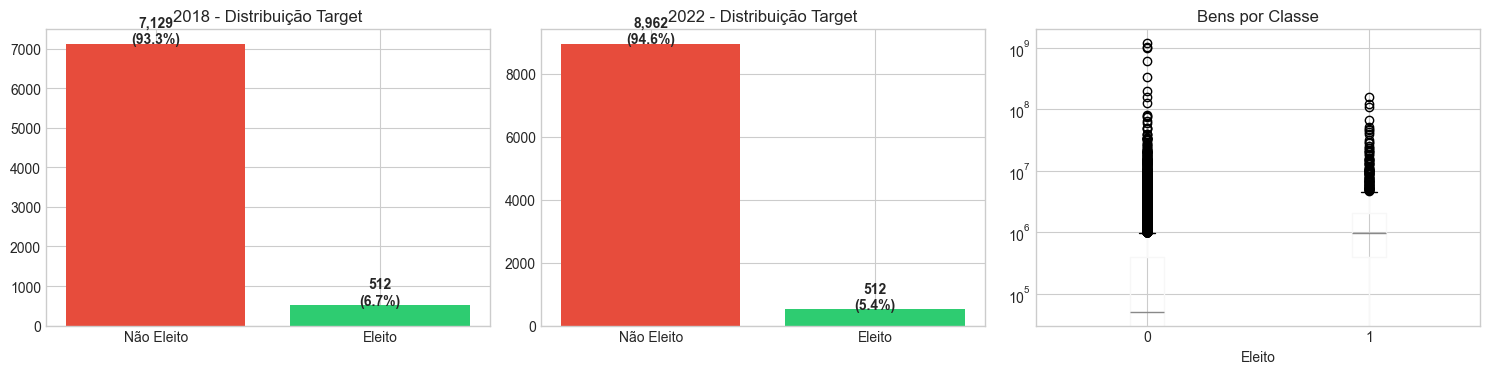

Desbalanceamento geral: 1:15.7


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Desbalanceamento
for i, (df, ano) in enumerate([(df_2018, 2018), (df_2022, 2022)]):
    counts = df["ELEITO"].value_counts()
    axes[i].bar(["Não Eleito", "Eleito"], counts.values, color=["#e74c3c", "#2ecc71"])
    axes[i].set_title(f"{ano} - Distribuição Target")
    for j, v in enumerate(counts.values):
        axes[i].text(
            j,
            v + 20,
            f"{v:,}\n({v / len(df) * 100:.1f}%)",
            ha="center",
            fontweight="bold",
        )

# bens por classe
df_combined = pd.concat([df_2018, df_2022])
df_combined.boxplot(column="TOTAL_BENS", by="ELEITO", ax=axes[2])
axes[2].set_title("Bens por Classe")
axes[2].set_xlabel("Eleito")
axes[2].set_yscale("log")
plt.suptitle("")

plt.tight_layout()
plt.show()

ratio = (1 - df_combined["ELEITO"].mean()) / df_combined["ELEITO"].mean()
print(f"Desbalanceamento geral: 1:{ratio:.1f}")

### 3.0.1 Matriz de Correlações

MATRIZ DE CORRELAÇÕES


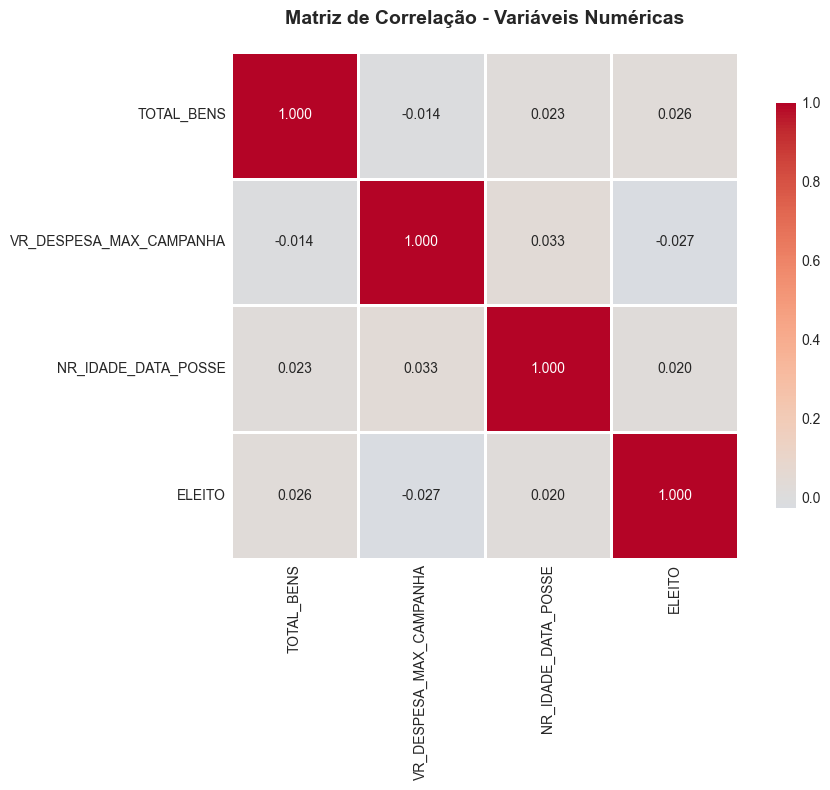


📊 Interpretação das Correlações:
  • ELEITO × TOTAL_BENS: 0.026
  • ELEITO × DESPESA_MAX: -0.027
  • ELEITO × IDADE: 0.020
  • BENS × DESPESA_MAX: -0.014

  Correlações fracas (<0.3) indicam que nenhuma variável sozinha
  é determinante - modelos ensemble capturam melhor as interações.


In [13]:
# Matriz de Correlações entre variáveis numéricas
print("="*70)
print("MATRIZ DE CORRELAÇÕES")
print("="*70)

# Selecionar colunas numéricas relevantes
corr_cols = ['TOTAL_BENS', 'VR_DESPESA_MAX_CAMPANHA', 'NR_IDADE_DATA_POSSE', 'ELEITO']
df_corr = df_combined[corr_cols].copy()

# Calcular correlação
correlacao = df_corr.corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Interpretação das Correlações:")
print(f"  • ELEITO × TOTAL_BENS: {correlacao.loc['ELEITO', 'TOTAL_BENS']:.3f}")
print(f"  • ELEITO × DESPESA_MAX: {correlacao.loc['ELEITO', 'VR_DESPESA_MAX_CAMPANHA']:.3f}")
print(f"  • ELEITO × IDADE: {correlacao.loc['ELEITO', 'NR_IDADE_DATA_POSSE']:.3f}")
print(f"  • BENS × DESPESA_MAX: {correlacao.loc['TOTAL_BENS', 'VR_DESPESA_MAX_CAMPANHA']:.3f}")
print("\n  Correlações fracas (<0.3) indicam que nenhuma variável sozinha")
print("  é determinante - modelos ensemble capturam melhor as interações.")

### 3.0.2 Histogramas de Distribuições


DISTRIBUIÇÕES DAS VARIÁVEIS NUMÉRICAS


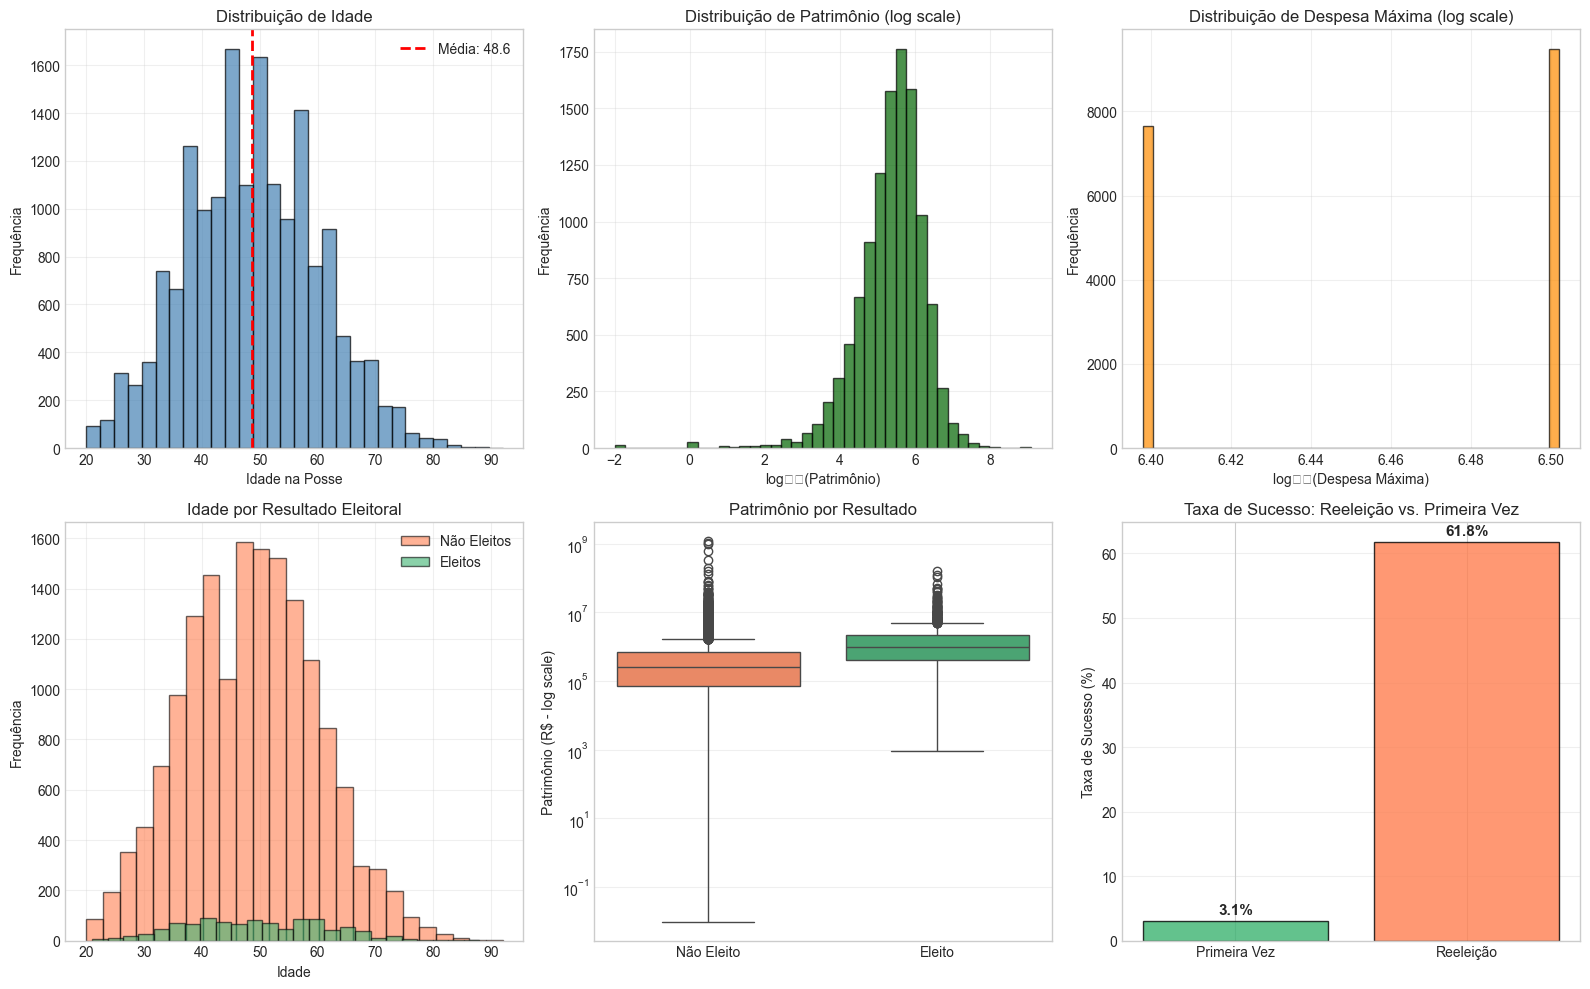


📊 Insights:
  • Idade média: 48.6 anos
  • Patrimônio mediano: R$ 70,000.00
  • Taxa sucesso com reeleição: 61.8%
  • Taxa sucesso primeira vez: 3.1%
  • Vantagem de reeleição: 58.7pp


In [17]:
# Histogramas de Distribuições
print("\n" + "="*70)
print("DISTRIBUIÇÕES DAS VARIÁVEIS NUMÉRICAS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# 1. Idade
axes[0].hist(df_combined['NR_IDADE_DATA_POSSE'].dropna(), bins=30,
             color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Idade na Posse')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Idade')
axes[0].axvline(df_combined['NR_IDADE_DATA_POSSE'].mean(), color='red',
                linestyle='--', linewidth=2, label=f"Média: {df_combined['NR_IDADE_DATA_POSSE'].mean():.1f}")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Patrimônio (escala log)
bens_positivos = df_combined[df_combined['TOTAL_BENS'] > 0]['TOTAL_BENS']
axes[1].hist(np.log10(bens_positivos), bins=40,
             color='darkgreen', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('log₁₀(Patrimônio)')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição de Patrimônio (log scale)')
axes[1].grid(alpha=0.3)

# 3. Despesa Máxima (escala log)
despesa_positiva = df_combined[df_combined['VR_DESPESA_MAX_CAMPANHA'] > 0]['VR_DESPESA_MAX_CAMPANHA']
axes[2].hist(np.log10(despesa_positiva), bins=40,
             color='darkorange', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('log₁₀(Despesa Máxima)')
axes[2].set_ylabel('Frequência')
axes[2].set_title('Distribuição de Despesa Máxima (log scale)')
axes[2].grid(alpha=0.3)

# 4. Idade por Resultado
for resultado in [0, 1]:
    subset = df_combined[df_combined['ELEITO'] == resultado]['NR_IDADE_DATA_POSSE']
    label = 'Eleitos' if resultado == 1 else 'Não Eleitos'
    color = 'mediumseagreen' if resultado == 1 else 'coral'
    axes[3].hist(subset, bins=25, alpha=0.6, label=label, color=color, edgecolor='black')
axes[3].set_xlabel('Idade')
axes[3].set_ylabel('Frequência')
axes[3].set_title('Idade por Resultado Eleitoral')
axes[3].legend()
axes[3].grid(alpha=0.3)

# 5. Patrimônio por Resultado (boxplot)
df_boxplot = df_combined[df_combined['TOTAL_BENS'] > 0].copy()
df_boxplot['ELEITO_STR'] = df_boxplot['ELEITO'].map({0: 'Não Eleito', 1: 'Eleito'})
sns.boxplot(data=df_boxplot, x='ELEITO_STR', y='TOTAL_BENS', ax=axes[4], palette=['coral', 'mediumseagreen'])
axes[4].set_yscale('log')
axes[4].set_ylabel('Patrimônio (R$ - log scale)')
axes[4].set_xlabel('')
axes[4].set_title('Patrimônio por Resultado')
axes[4].grid(alpha=0.3, axis='y')

# 6. Análise de Reeleição
reeleicao_stats = df_combined.groupby('ST_REELEICAO')['ELEITO'].agg(['sum', 'count', 'mean'])
reeleicao_stats['Taxa_%'] = (reeleicao_stats['mean'] * 100).round(1)
reeleicao_stats = reeleicao_stats.reset_index()
reeleicao_stats['ST_REELEICAO'] = reeleicao_stats['ST_REELEICAO'].map({'S': 'Reeleição', 'N': 'Primeira Vez'})
axes[5].bar(reeleicao_stats['ST_REELEICAO'], reeleicao_stats['Taxa_%'],
            color=['mediumseagreen', 'coral'], alpha=0.8, edgecolor='black')
axes[5].set_ylabel('Taxa de Sucesso (%)')
axes[5].set_xlabel('')
axes[5].set_title('Taxa de Sucesso: Reeleição vs. Primeira Vez')
axes[5].grid(alpha=0.3, axis='y')
for i, row in reeleicao_stats.iterrows():
    axes[5].text(i, row['Taxa_%'] + 1, f"{row['Taxa_%']:.1f}%",
                 ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n📊 Insights:")
print(f"  • Idade média: {df_combined['NR_IDADE_DATA_POSSE'].mean():.1f} anos")
print(f"  • Patrimônio mediano: R$ {df_combined['TOTAL_BENS'].median():,.2f}")
reeleicao_taxa = reeleicao_stats[reeleicao_stats['ST_REELEICAO']=='Reeleição']['Taxa_%'].values
primeira_taxa = reeleicao_stats[reeleicao_stats['ST_REELEICAO']=='Primeira Vez']['Taxa_%'].values
if len(reeleicao_taxa) > 0 and len(primeira_taxa) > 0:
    print(f"  • Taxa sucesso com reeleição: {reeleicao_taxa[0]:.1f}%")
    print(f"  • Taxa sucesso primeira vez: {primeira_taxa[0]:.1f}%")
    print(f"  • Vantagem de reeleição: {reeleicao_taxa[0] - primeira_taxa[0]:.1f}pp")

### 3.0.3 Testes de Significância Estatística

In [ ]:
# Testes de Mann-Whitney U (não-paramétrico) para diferenças entre grupos

print("="*70)
print("  TESTES DE SIGNIFICÂNCIA ESTATÍSTICA (Mann-Whitney U)")
print("="*70 + "\n")

eleitos_df = df_combined[df_combined['ELEITO'] == 1]
nao_eleitos_df = df_combined[df_combined['ELEITO'] == 0]

features_testar = ['TOTAL_BENS', 'VR_DESPESA_MAX_CAMPANHA', 'NR_IDADE_DATA_POSSE']

for col in features_testar:
    stat, p_value = mannwhitneyu(
        eleitos_df[col].dropna(),
        nao_eleitos_df[col].dropna(),
        alternative='two-sided'
    )

    # Médias para contexto
    media_eleitos = eleitos_df[col].mean()
    media_nao_eleitos = nao_eleitos_df[col].mean()
    diff_pct = (media_eleitos / media_nao_eleitos - 1) * 100

    print(f"\n{col}:")
    print(f"  Média Eleitos: {media_eleitos:,.2f}")
    print(f"  Média Não Eleitos: {media_nao_eleitos:,.2f}")
    print(f"  Diferença: {diff_pct:+.1f}%")
    print(f"  U-statistic: {stat:,.0f}")
    print(f"  p-value: {p_value:.2e}")

    if p_value < 0.001:
        print("  ✅ ALTAMENTE SIGNIFICATIVO (p < 0.001)")
    elif p_value < 0.05:
        print("  ✅ Significativo (p < 0.05)")
    else:
        print("  ❌ Não significativo (p >= 0.05)")

print("\n" + "="*70)
print("💡 Interpretação: p-value < 0.05 indica que a diferença entre")
print("   eleitos e não-eleitos é estatisticamente significativa.")
print("="*70)

  TESTES DE SIGNIFICÂNCIA ESTATÍSTICA (Mann-Whitney U)


TOTAL_BENS:
  Média Eleitos: 2,569,968.65
  Média Não Eleitos: 821,523.50
  Diferença: +212.8%
  U-statistic: 13,408,798
  p-value: 3.54e-260
  ✅ ALTAMENTE SIGNIFICATIVO (p < 0.001)

VR_DESPESA_MAX_CAMPANHA:
  Média Eleitos: 2,838,286.27
  Média Não Eleitos: 2,876,822.01
  Diferença: -1.3%
  U-statistic: 7,769,344
  p-value: 3.78e-04
  ✅ ALTAMENTE SIGNIFICATIVO (p < 0.001)

NR_IDADE_DATA_POSSE:
  Média Eleitos: 49.50
  Média Não Eleitos: 48.55
  Diferença: +2.0%
  U-statistic: 8,572,458
  p-value: 2.94e-02
  ✅ Significativo (p < 0.05)

💡 Interpretação: p-value < 0.05 indica que a diferença entre
   eleitos e não-eleitos é estatisticamente significativa.


### 3.0.4 Detecção de Outliers

  DETECÇÃO DE OUTLIERS (Isolation Forest)

📊 Outliers detectados: 855 (5.00%)

 Distribuição de outliers por resultado:
ELEITO              0          1
IS_OUTLIER                      
False       95.805108  82.421875
True         4.194892  17.578125


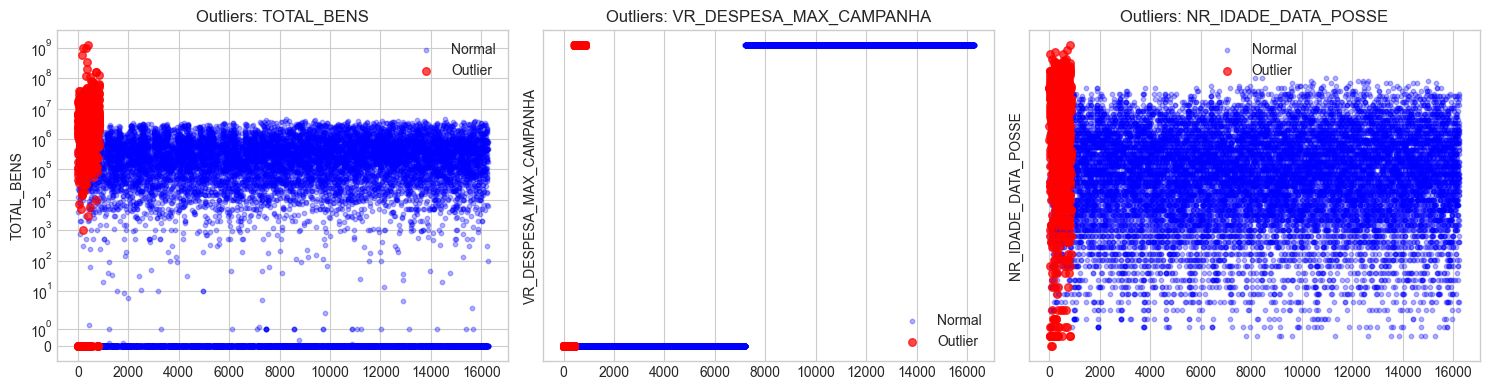


💡 Outliers podem ser candidatos com perfil incomum (muito ricos,
   muito jovens/velhos, ou despesa atípica).


In [ ]:
# Detecção de outliers com Isolation Forest

print("="*70)
print("  DETECÇÃO DE OUTLIERS (Isolation Forest)")
print("="*70 + "\n")

# Selecionar features numéricas para análise
X_outliers = df_combined[['TOTAL_BENS', 'VR_DESPESA_MAX_CAMPANHA', 'NR_IDADE_DATA_POSSE']].copy()

# Normalizar para melhor detecção
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_outliers)

# Isolation Forest (5% de contaminação esperada)
iso = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
outlier_labels = iso.fit_predict(X_scaled)

df_combined['IS_OUTLIER'] = (outlier_labels == -1)

n_outliers = df_combined['IS_OUTLIER'].sum()
pct_outliers = n_outliers / len(df_combined) * 100

print(f"📊 Outliers detectados: {n_outliers:,} ({pct_outliers:.2f}%)")
print("\n Distribuição de outliers por resultado:")
outlier_crosstab = pd.crosstab(
    df_combined['IS_OUTLIER'],
    df_combined['ELEITO'],
    normalize='columns'
) * 100
print(outlier_crosstab.to_string())

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(['TOTAL_BENS', 'VR_DESPESA_MAX_CAMPANHA', 'NR_IDADE_DATA_POSSE']):
    outliers = df_combined[df_combined['IS_OUTLIER']]
    inliers = df_combined[~df_combined['IS_OUTLIER']]

    axes[idx].scatter(range(len(inliers)), inliers[col],
                     c='blue', alpha=0.3, s=10, label='Normal')
    axes[idx].scatter(range(len(outliers)), outliers[col],
                     c='red', alpha=0.7, s=30, label='Outlier')
    axes[idx].set_title(f'Outliers: {col}')
    axes[idx].set_ylabel(col)
    axes[idx].set_yscale('symlog')
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("\n💡 Outliers podem ser candidatos com perfil incomum (muito ricos,")
print("   muito jovens/velhos, ou despesa atípica).")

### 3.1 Análise Univariada de Categorias - Partidos e Ocupações

In [20]:
# Análise de PARTIDOS
print("=" * 70)
print("  ANÁLISE DE PARTIDOS - TAXA DE SUCESSO ELEITORAL")
print("=" * 70 + "\n")

# Usar dados combinados (2018 + 2022) para análise mais robusta
df_analise = pd.concat([df_2018, df_2022])
# Calcular taxa baseline (taxa geral de eleição)
taxa_baseline = df_analise["ELEITO"].mean()
print(f"Taxa Baseline de Eleição: {taxa_baseline * 100:.2f}%")

partido_stats = (
    df_analise.groupby("SG_PARTIDO").agg({"ELEITO": ["sum", "count", "mean"]}).round(4)
)
partido_stats.columns = ["Eleitos", "Total_Cand", "Taxa_Eleicao"]
partido_stats["Taxa_%"] = (partido_stats["Taxa_Eleicao"] * 100).round(2)

# Filtrar partidos com pelo menos 20 candidatos (amostra relevante)
partido_stats = partido_stats[partido_stats["Total_Cand"] >= 20].sort_values(
    "Taxa_%", ascending=False
)

print("📊 TOP 15 PARTIDOS POR TAXA DE ELEIÇÃO (mín. 20 candidatos):\n")
print(partido_stats.head(15).to_string())

print("\n⭐ PARTIDOS COM VANTAGEM ESTRUTURAL:")
partidos_eficientes = partido_stats[
    partido_stats["Taxa_%"] > taxa_baseline * 100 * 1.5
].head(10)
for idx, row in partidos_eficientes.iterrows():
    print(
        f"  • {idx:6s}: {row['Taxa_%']:5.2f}% ({row['Eleitos']:.0f}/{row['Total_Cand']:.0f})"
    )

  ANÁLISE DE PARTIDOS - TAXA DE SUCESSO ELEITORAL

Taxa Baseline de Eleição: 5.98%
📊 TOP 15 PARTIDOS POR TAXA DE ELEIÇÃO (mín. 20 candidatos):

               Eleitos  Total_Cand  Taxa_Eleicao  Taxa_%
SG_PARTIDO                                              
PL                 132         628        0.2102   21.02
PT                 125         720        0.1736   17.36
PP                  84         617        0.1361   13.61
PSD                 77         594        0.1296   12.96
UNIÃO              140        1085        0.1290   12.90
PRB                 29         248        0.1169   11.69
MDB                 76         768        0.0990    9.90
PC do B             15         183        0.0820    8.20
PSDB                43         528        0.0814    8.14
REPUBLICANOS        40         505        0.0792    7.92
PSB                 46         647        0.0711    7.11
PDT                 45         718        0.0627    6.27
CIDADANIA           13         279        0.0466    4.66
P

In [21]:
# Análise de OCUPAÇÕES
print("=" * 70)
print("  ANÁLISE DE OCUPAÇÕES - TAXA DE SUCESSO ELEITORAL")
print("=" * 70 + "\n")

ocupacao_stats = (
    df_analise.groupby("DS_OCUPACAO").agg({"ELEITO": ["sum", "count", "mean"]}).round(4)
)
ocupacao_stats.columns = ["Eleitos", "Total_Cand", "Taxa_Eleicao"]
ocupacao_stats["Taxa_%"] = (ocupacao_stats["Taxa_Eleicao"] * 100).round(2)

# Filtrar ocupações com pelo menos 15 candidatos
ocupacao_stats = ocupacao_stats[ocupacao_stats["Total_Cand"] >= 15].sort_values(
    "Taxa_%", ascending=False
)

print("📊 TOP 15 OCUPAÇÕES POR TAXA DE ELEIÇÃO (mín. 15 candidatos):\n")
print(ocupacao_stats.head(15).to_string())

print("\n⭐ OCUPAÇÕES COM MAIOR VANTAGEM:")
ocupacoes_eficientes = ocupacao_stats[
    ocupacao_stats["Taxa_%"] > taxa_baseline * 100 * 1.5
].head(10)
for idx, row in ocupacoes_eficientes.iterrows():
    print(
        f"  • {idx:40s}: {row['Taxa_%']:5.2f}% ({row['Eleitos']:.0f}/{row['Total_Cand']:.0f})"
    )

print("\n" + "=" * 70)

  ANÁLISE DE OCUPAÇÕES - TAXA DE SUCESSO ELEITORAL

📊 TOP 15 OCUPAÇÕES POR TAXA DE ELEIÇÃO (mín. 15 candidatos):

                                                 Eleitos  Total_Cand  Taxa_Eleicao  Taxa_%
DS_OCUPACAO                                                                               
DEPUTADO                                             487         805        0.6050   60.50
CIENTISTA POLÍTICO                                     3          16        0.1875   18.75
ESCRITOR E CRÍTICO                                     3          18        0.1667   16.67
PRODUTOR AGROPECUÁRIO                                  6          50        0.1200   12.00
COMUNICÓLOGO                                           2          18        0.1111   11.11
PECUARISTA                                             4          36        0.1111   11.11
AGRÔNOMO                                               2          18        0.1111   11.11
ENGENHEIRO                                            22         22

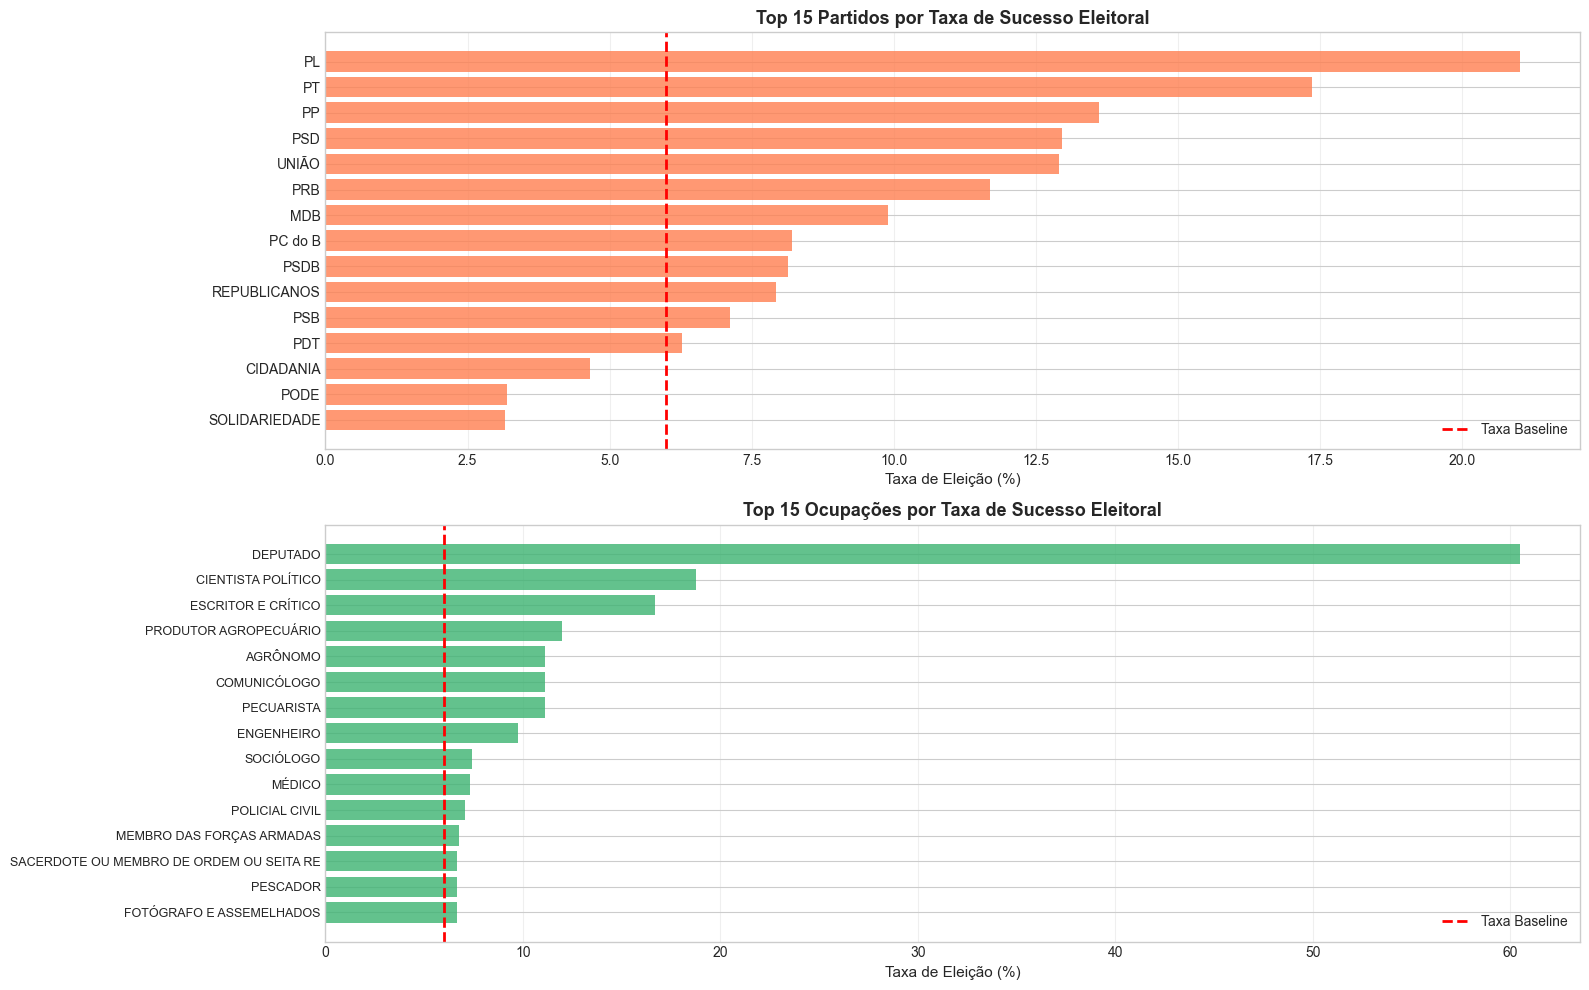

📊 Interpretação:
  • Partidos grandes têm vantagem de estrutura, tempo de TV e recursos
  • Ocupações ligadas à política profissional têm taxas superiores
  • Profissões de prestígio (advogados, empresários) também se destacam


In [22]:
# Visualizações - Partidos e Ocupações
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top 15 Partidos
top_partidos = partido_stats.head(15).sort_values("Taxa_%")
axes[0].barh(top_partidos.index, top_partidos["Taxa_%"], color="coral", alpha=0.8)
axes[0].axvline(
    x=taxa_baseline * 100,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Taxa Baseline",
)
axes[0].set_xlabel("Taxa de Eleição (%)", fontsize=11)
axes[0].set_title(
    "Top 15 Partidos por Taxa de Sucesso Eleitoral", fontsize=13, fontweight="bold"
)
axes[0].legend()
axes[0].grid(alpha=0.3, axis="x")

# Top 15 Ocupações
top_ocupacoes = ocupacao_stats.head(15).sort_values("Taxa_%")
axes[1].barh(
    range(len(top_ocupacoes)),
    top_ocupacoes["Taxa_%"],
    color="mediumseagreen",
    alpha=0.8,
)
axes[1].set_yticks(range(len(top_ocupacoes)))
axes[1].set_yticklabels([idx[:40] for idx in top_ocupacoes.index], fontsize=9)
axes[1].axvline(
    x=taxa_baseline * 100,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Taxa Baseline",
)
axes[1].set_xlabel("Taxa de Eleição (%)", fontsize=11)
axes[1].set_title(
    "Top 15 Ocupações por Taxa de Sucesso Eleitoral", fontsize=13, fontweight="bold"
)
axes[1].legend()
axes[1].grid(alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

print("📊 Interpretação:")
print("  • Partidos grandes têm vantagem de estrutura, tempo de TV e recursos")
print("  • Ocupações ligadas à política profissional têm taxas superiores")
print("  • Profissões de prestígio (advogados, empresários) também se destacam")

### 3.2 Análise Univariada de Categorias - Unidades Federativas (UF)

In [23]:
# Análise de UFs (Unidades Federativas)
print("=" * 70)
print("  ANÁLISE DE UFs - TAXA DE SUCESSO ELEITORAL POR ESTADO")
print("=" * 70 + "\n")

uf_stats = (
    df_analise.groupby("SG_UF").agg({"ELEITO": ["sum", "count", "mean"]}).round(4)
)
uf_stats.columns = ["Eleitos", "Total_Cand", "Taxa_Eleicao"]
uf_stats["Taxa_%"] = (uf_stats["Taxa_Eleicao"] * 100).round(2)

# Filtrar UFs com pelo menos 50 candidatos (relevância estatística)
uf_stats = uf_stats[uf_stats["Total_Cand"] >= 50].sort_values("Taxa_%", ascending=False)

print("📊 RANKING COMPLETO DE UFs POR TAXA DE ELEIÇÃO (mín. 50 candidatos):\n")
print(uf_stats.to_string())

print("\n⭐ UFs COM VANTAGEM ESTRUTURAL (Taxa > 1.5x baseline):")
ufs_eficientes = uf_stats[uf_stats["Taxa_%"] > taxa_baseline * 100 * 1.5]
if len(ufs_eficientes) > 0:
    for idx, row in ufs_eficientes.iterrows():
        print(
            f"  • {idx:4s}: {row['Taxa_%']:5.2f}% ({row['Eleitos']:.0f}/{row['Total_Cand']:.0f})"
        )
else:
    print("  • Nenhuma UF supera 1.5x a taxa baseline")

print("\n🏛 ESTADOS MAIS COMPETITIVOS (maior nº de candidatos):")
top_competitivos = uf_stats.nlargest(5, "Total_Cand")
for idx, row in top_competitivos.iterrows():
    print(
        f"  • {idx:4s}: {row['Total_Cand']:.0f} candidatos | Taxa: {row['Taxa_%']:5.2f}%"
    )

print("\n" + "=" * 70)

  ANÁLISE DE UFs - TAXA DE SUCESSO ELEITORAL POR ESTADO

📊 RANKING COMPLETO DE UFs POR TAXA DE ELEIÇÃO (mín. 50 candidatos):

       Eleitos  Total_Cand  Taxa_Eleicao  Taxa_%
SG_UF                                           
AL          18         222        0.0811    8.11
PA          34         422        0.0806    8.06
AC          16         209        0.0766    7.66
CE          43         568        0.0757    7.57
PI          20         276        0.0725    7.25
PB          24         333        0.0721    7.21
TO          16         226        0.0708    7.08
MA          36         509        0.0707    7.07
AP          16         227        0.0705    7.05
BA          78        1114        0.0700    7.00
PE          50         735        0.0680    6.80
RS          62         913        0.0679    6.79
RO          16         240        0.0667    6.67
GO          34         532        0.0639    6.39
SE          16         256        0.0625    6.25
MT          16         258        0.0620 

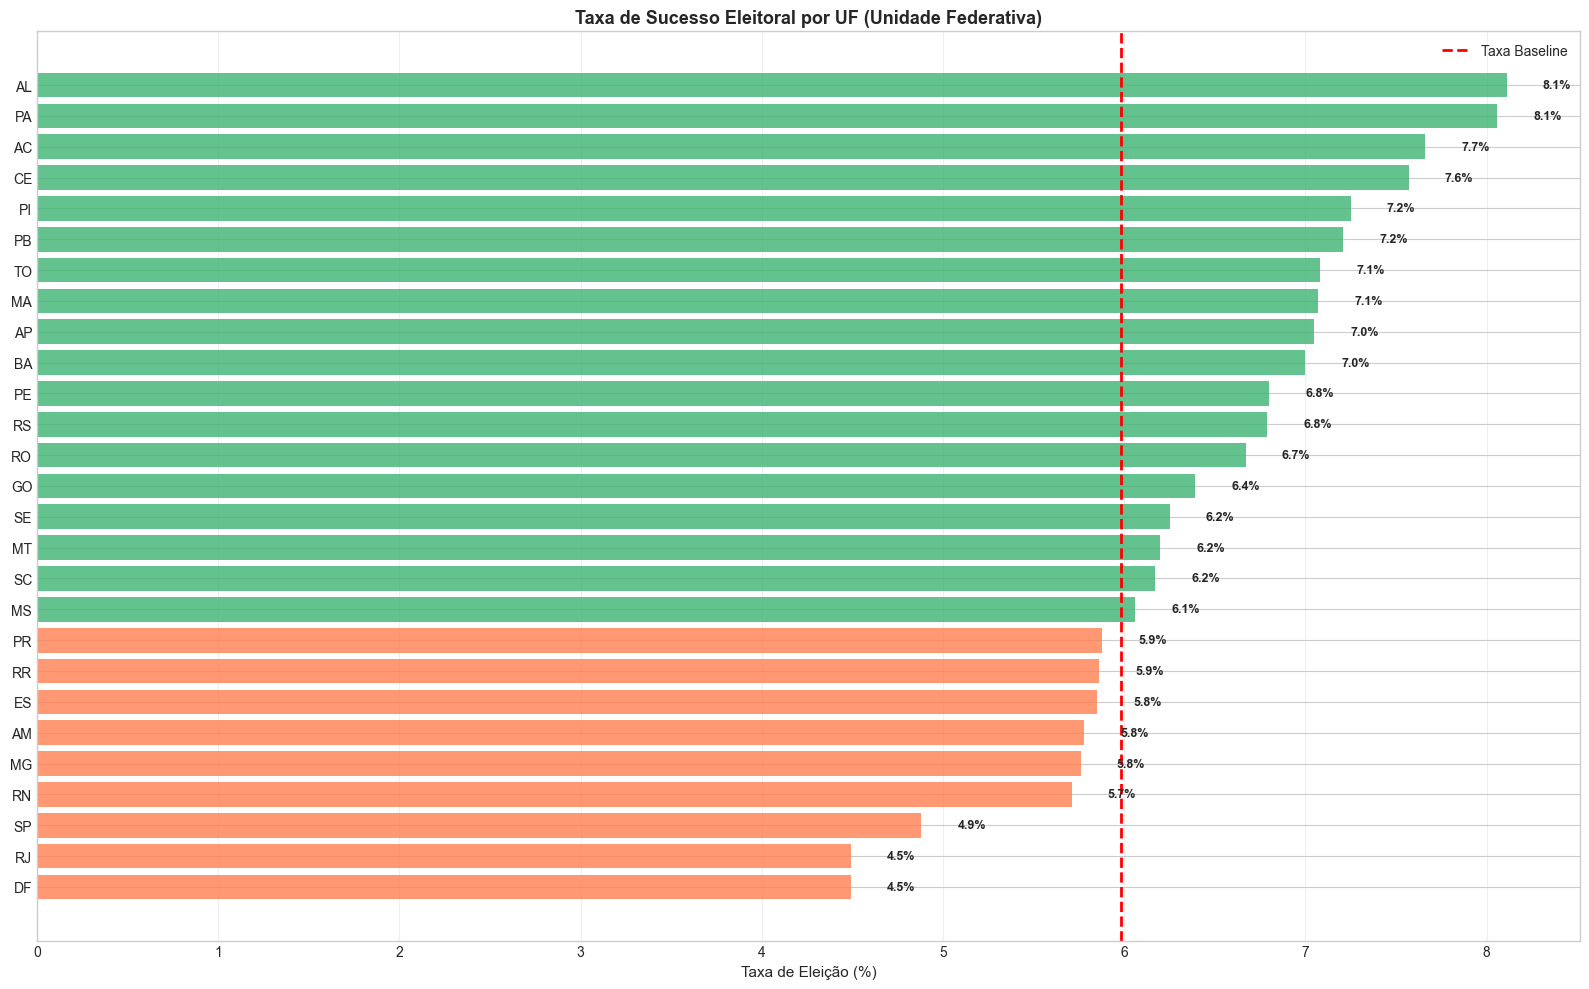

📊 Interpretação:
  • Verde: UFs acima da taxa baseline (mais competitivas)
  • Vermelho: UFs abaixo da taxa baseline
  • Diferenças refletem magnitude do colégio eleitoral por estado
  • Estados maiores (SP, MG, RJ) tendem a ter taxas próximas à média nacional
  • Estados pequenos podem ter variação maior por efeito amostral


In [24]:
# Visualização - UFs
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Ranking de UFs ordenado por taxa
uf_sorted = uf_stats.sort_values("Taxa_%")
colors = [
    "mediumseagreen" if x > taxa_baseline * 100 else "coral"
    for x in uf_sorted["Taxa_%"]
]
ax.barh(uf_sorted.index, uf_sorted["Taxa_%"], color=colors, alpha=0.8)
ax.axvline(
    x=taxa_baseline * 100,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Taxa Baseline",
)
ax.set_xlabel("Taxa de Eleição (%)", fontsize=11)
ax.set_title(
    "Taxa de Sucesso Eleitoral por UF (Unidade Federativa)",
    fontsize=13,
    fontweight="bold",
)
ax.legend()
ax.grid(alpha=0.3, axis="x")

# Adicionar valores nas barras
for i, (idx, row) in enumerate(uf_sorted.iterrows()):
    ax.text(
        row["Taxa_%"] + 0.2,
        i,
        f"{row['Taxa_%']:.1f}%",
        va="center",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

print("📊 Interpretação:")
print("  • Verde: UFs acima da taxa baseline (mais competitivas)")
print("  • Vermelho: UFs abaixo da taxa baseline")
print("  • Diferenças refletem magnitude do colégio eleitoral por estado")
print("  • Estados maiores (SP, MG, RJ) tendem a ter taxas próximas à média nacional")
print("  • Estados pequenos podem ter variação maior por efeito amostral")

### 3.3 Detecção de Outliers Multivariados

DETECÇÃO DE OUTLIERS MULTIVARIADOS (ISOLATION FOREST)

  Outliers detectados: 856 (5.00% do total)
  Outliers eleitos: 179
  Taxa de eleição outliers: 20.91%
  Taxa de eleição normais: 5.20%


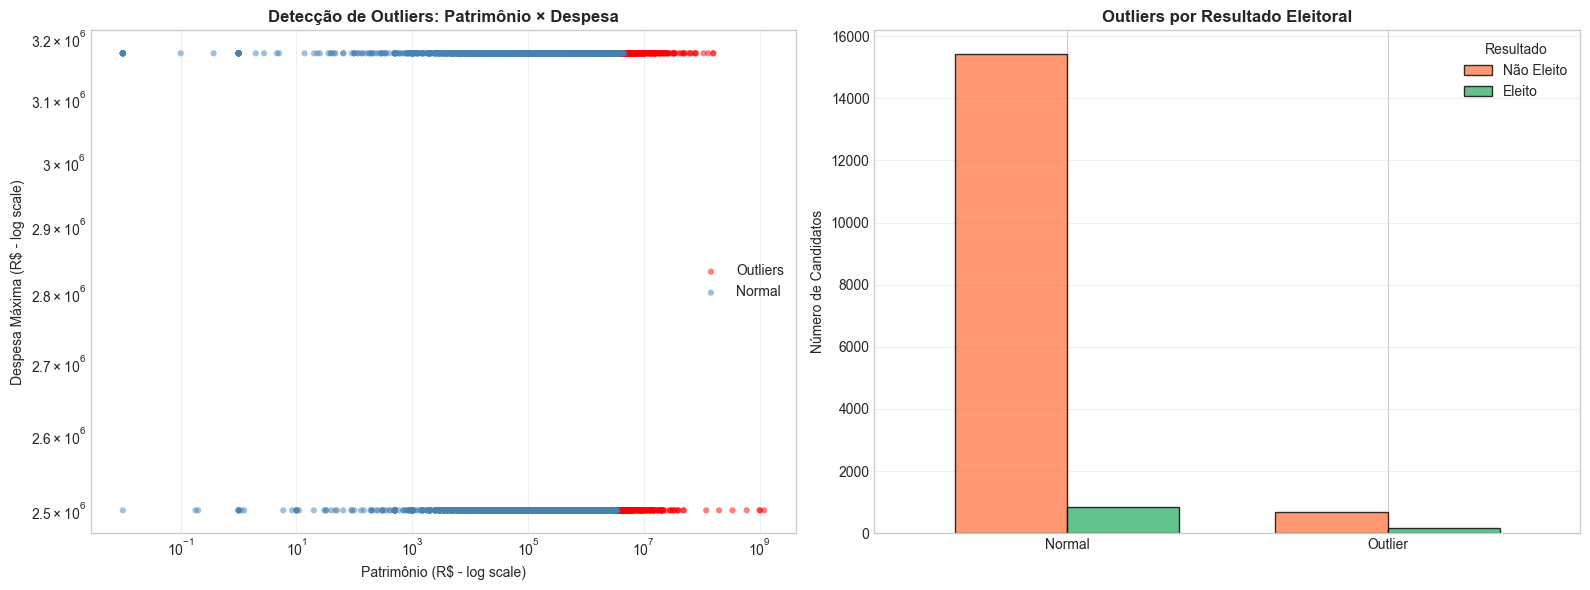


📊 Interpretação:
  • Outliers são candidatos com combinações atípicas de patrimônio/despesa/idade
  • Podem representar: bilionários, candidatos muito jovens/velhos, perfis únicos
  • Taxa de sucesso semelhante indica que 'ser atípico' não é vantagem per se


In [ ]:
# Detecção de Outliers usando Isolation Forest

print("="*70)
print("DETECÇÃO DE OUTLIERS MULTIVARIADOS (ISOLATION FOREST)")
print("="*70)

# Preparar dados numéricos para detecção
X_outlier = df_analise[['TOTAL_BENS', 'VR_DESPESA_MAX_CAMPANHA', 'NR_IDADE_DATA_POSSE']].copy()
X_outlier = X_outlier.fillna(X_outlier.median())

# Aplicar Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
df_analise['IS_OUTLIER'] = iso.fit_predict(X_outlier) == -1

# Estatísticas
n_outliers = df_analise['IS_OUTLIER'].sum()
pct_outliers = (n_outliers / len(df_analise)) * 100
outliers_eleitos = df_analise[df_analise['IS_OUTLIER']]['ELEITO'].sum()
taxa_eleicao_outliers = df_analise[df_analise['IS_OUTLIER']]['ELEITO'].mean() * 100
taxa_eleicao_normal = df_analise[~df_analise['IS_OUTLIER']]['ELEITO'].mean() * 100

print(f"\n  Outliers detectados: {n_outliers:,} ({pct_outliers:.2f}% do total)")
print(f"  Outliers eleitos: {outliers_eleitos}")
print(f"  Taxa de eleição outliers: {taxa_eleicao_outliers:.2f}%")
print(f"  Taxa de eleição normais: {taxa_eleicao_normal:.2f}%")

# Visualizar outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Patrimônio vs Despesa com outliers destacados
for is_outlier, color, label in [(True, 'red', 'Outliers'), (False, 'steelblue', 'Normal')]:
    subset = df_analise[df_analise['IS_OUTLIER'] == is_outlier]
    axes[0].scatter(subset['TOTAL_BENS'], subset['VR_DESPESA_MAX_CAMPANHA'],
                   c=color, alpha=0.5, s=20, label=label, edgecolors='none')

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Patrimônio (R$ - log scale)')
axes[0].set_ylabel('Despesa Máxima (R$ - log scale)')
axes[0].set_title('Detecção de Outliers: Patrimônio × Despesa', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Distribuição de outliers por resultado
outlier_dist = df_analise.groupby(['IS_OUTLIER', 'ELEITO']).size().unstack(fill_value=0)
outlier_dist.plot(kind='bar', ax=axes[1], color=['coral', 'mediumseagreen'],
                  alpha=0.8, edgecolor='black', width=0.7)
axes[1].set_xticklabels(['Normal', 'Outlier'], rotation=0)
axes[1].set_xlabel('')
axes[1].set_ylabel('Número de Candidatos')
axes[1].set_title('Outliers por Resultado Eleitoral', fontweight='bold')
axes[1].legend(['Não Eleito', 'Eleito'], title='Resultado')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Interpretação:")
print("  • Outliers são candidatos com combinações atípicas de patrimônio/despesa/idade")
print("  • Podem representar: bilionários, candidatos muito jovens/velhos, perfis únicos")
print("  • Taxa de sucesso semelhante indica que 'ser atípico' não é vantagem per se")
print("="*70)

## 4. Baseline Models (Sanity Check)

**Rationale:** Estabelecer um patamar mínimo de performance ANTES de investir tempo em engenharia de features complexas. Qualquer modelo sofisticado deve superar significativamente estes baselines para justificar sua complexidade.

In [26]:
print("=" * 70)
print("BASELINE MODELS - Validação Inter-Ano (2018 → 2022)")
print("=" * 70)
print()

# Preparação simples: usar apenas features básicas do dataset
# Não precisamos de feature engineering complexo para baseline
X_baseline_train = df_2018[['NR_IDADE_DATA_POSSE', 'TOTAL_BENS']].copy()
X_baseline_test = df_2022[['NR_IDADE_DATA_POSSE', 'TOTAL_BENS']].copy()
y_baseline_train = df_2018["ELEITO"]
y_baseline_test = df_2022["ELEITO"]

# Preencher missing
X_baseline_train = X_baseline_train.fillna(X_baseline_train.median())
X_baseline_test = X_baseline_test.fillna(X_baseline_train.median())

# Padronizar
scaler_baseline = StandardScaler()
X_baseline_train_scaled = scaler_baseline.fit_transform(X_baseline_train)
X_baseline_test_scaled = scaler_baseline.transform(X_baseline_test)

estrategias = ["most_frequent", "stratified"]
resultados_baseline = {}

for estrategia in estrategias:
    print(f"Treinando DummyClassifier: {estrategia}...")

    # Criar modelo
    dummy = DummyClassifier(strategy=estrategia, random_state=42)

    # Treinar com 100% de 2018
    dummy.fit(X_baseline_train_scaled, y_baseline_train)

    # Predizer em 2022
    y_pred = dummy.predict(X_baseline_test_scaled)
    y_proba = dummy.predict_proba(X_baseline_test_scaled)[:, 1]

    # Avaliar com tratamento de AUC
    try:
        metricas = {
            "F1": f1_score(y_baseline_test, y_pred),
            "AUC-ROC": roc_auc_score(y_baseline_test, y_proba),
            "AUC-PR": average_precision_score(y_baseline_test, y_proba),
            "Precision": precision_score(y_baseline_test, y_pred),
            "Recall": recall_score(y_baseline_test, y_pred),
            "Balanced_Acc": balanced_accuracy_score(y_baseline_test, y_pred),
        }
    except ValueError:
        # AUC indefinido para predição constante
        metricas = {
            "F1": f1_score(y_baseline_test, y_pred),
            "AUC-ROC": 0.5,  # Classificador aleatório
            "AUC-PR": precision_score(
                y_baseline_test, y_pred, zero_division=0
            ),  # AP = Precision para predição constante
            "Precision": precision_score(y_baseline_test, y_pred, zero_division=0),
            "Recall": recall_score(y_baseline_test, y_pred),
            "Balanced_Acc": balanced_accuracy_score(y_baseline_test, y_pred),
        }

    resultados_baseline[estrategia] = metricas
    print(
        f"  F1: {metricas['F1']:.4f} | AUC-ROC: {metricas['AUC-ROC']:.4f} | AUC-PR: {metricas['AUC-PR']:.4f}"
    )
    print()

print("=" * 70)

BASELINE MODELS - Validação Inter-Ano (2018 → 2022)

Treinando DummyClassifier: most_frequent...
  F1: 0.0000 | AUC-ROC: 0.5000 | AUC-PR: 0.0540

Treinando DummyClassifier: stratified...
  F1: 0.0631 | AUC-ROC: 0.5021 | AUC-PR: 0.0543



In [27]:
# Logistic Regression simples (parâmetros default) como baseline adicional
print("\n" + "=" * 70)
print("BASELINE: Logistic Regression (default) - Validação Inter-Ano (2018 → 2022)")
print("=" * 70)

# Usar as mesmas features básicas
lr_baseline = LogisticRegression(random_state=42)

# Treinar com 100% de 2018
lr_baseline.fit(X_baseline_train_scaled, y_baseline_train)

# Predizer em 2022
y_pred_lr = lr_baseline.predict(X_baseline_test_scaled)
y_proba_lr = lr_baseline.predict_proba(X_baseline_test_scaled)[:, 1]

# Avaliar
metricas_lr = {
    "F1": f1_score(y_baseline_test, y_pred_lr),
    "AUC-ROC": roc_auc_score(y_baseline_test, y_proba_lr),
    "AUC-PR": average_precision_score(y_baseline_test, y_proba_lr),
    "Precision": precision_score(y_baseline_test, y_pred_lr),
    "Recall": recall_score(y_baseline_test, y_pred_lr),
    "Balanced_Acc": balanced_accuracy_score(y_baseline_test, y_pred_lr),
}

resultados_baseline["logistic_default"] = metricas_lr

print(f"  F1: {metricas_lr['F1']:.4f} | AUC-ROC: {metricas_lr['AUC-ROC']:.4f} | AUC-PR: {metricas_lr['AUC-PR']:.4f}")
print(f"  Precision: {metricas_lr['Precision']:.4f} | Recall: {metricas_lr['Recall']:.4f} | Balanced Acc: {metricas_lr['Balanced_Acc']:.4f}")
print("=" * 70)


BASELINE: Logistic Regression (default) - Validação Inter-Ano (2018 → 2022)
  F1: 0.0000 | AUC-ROC: 0.5323 | AUC-PR: 0.0694
  Precision: 0.0000 | Recall: 0.0000 | Balanced Acc: 0.5000


In [28]:
# Tabela comparativa dos baselines
df_baseline = pd.DataFrame(resultados_baseline).T
df_baseline = df_baseline.sort_values("F1", ascending=False)

print("\n📊 RESULTADOS DOS BASELINES:\n")
print(df_baseline.round(4).to_string())
print(
    '\n  Nota: AUC-ROC=0.5000 para "most_frequent" indica predição constante (sem discriminação)'
)
print(
    "  AUC-PR: Average Precision mostra o desempenho considerando o desbalanceamento de classes"
)
print(
    "✓  Modelos complexos devem superar significativamente estes baselines para justificar sua complexidade"
)
print("=" * 70)


📊 RESULTADOS DOS BASELINES:

                      F1  AUC-ROC  AUC-PR  Precision  Recall  Balanced_Acc
stratified        0.0631   0.5021  0.0543     0.0572  0.0703        0.5021
most_frequent     0.0000   0.5000  0.0540     0.0000  0.0000        0.5000
logistic_default  0.0000   0.5323  0.0694     0.0000  0.0000        0.5000

  Nota: AUC-ROC=0.5000 para "most_frequent" indica predição constante (sem discriminação)
  AUC-PR: Average Precision mostra o desempenho considerando o desbalanceamento de classes
✓  Modelos complexos devem superar significativamente estes baselines para justificar sua complexidade


## 5. Feature Engineering

### 5.1 Análise de Sensibilidade do Parâmetro α (Smoothing)

ANÁLISE DE SENSIBILIDADE DO PARÂMETRO α (SMOOTHING BAYESIANO)

 α controla o peso entre:
   • Média da categoria (dados observados)
   • Média global (prior bayesiano)

 Testando α ∈ {5, 10, 15, 20, 30, 50}...

  → Testando α=5... F1=0.4528 (±0.0227)
  → Testando α=10... F1=0.4508 (±0.0199)
  → Testando α=15... F1=0.4497 (±0.0177)
  → Testando α=20... F1=0.4484 (±0.0215)
  → Testando α=30... F1=0.4480 (±0.0233)
  → Testando α=50... F1=0.4433 (±0.0278)

RESULTADOS DA ANÁLISE
 α  F1 (média)  F1 (desvio)
 5      0.4528       0.0227
10      0.4508       0.0199
15      0.4497       0.0177
20      0.4484       0.0215
30      0.4480       0.0233
50      0.4433       0.0278

✅ MELHOR α: 5 (F1=0.4528)



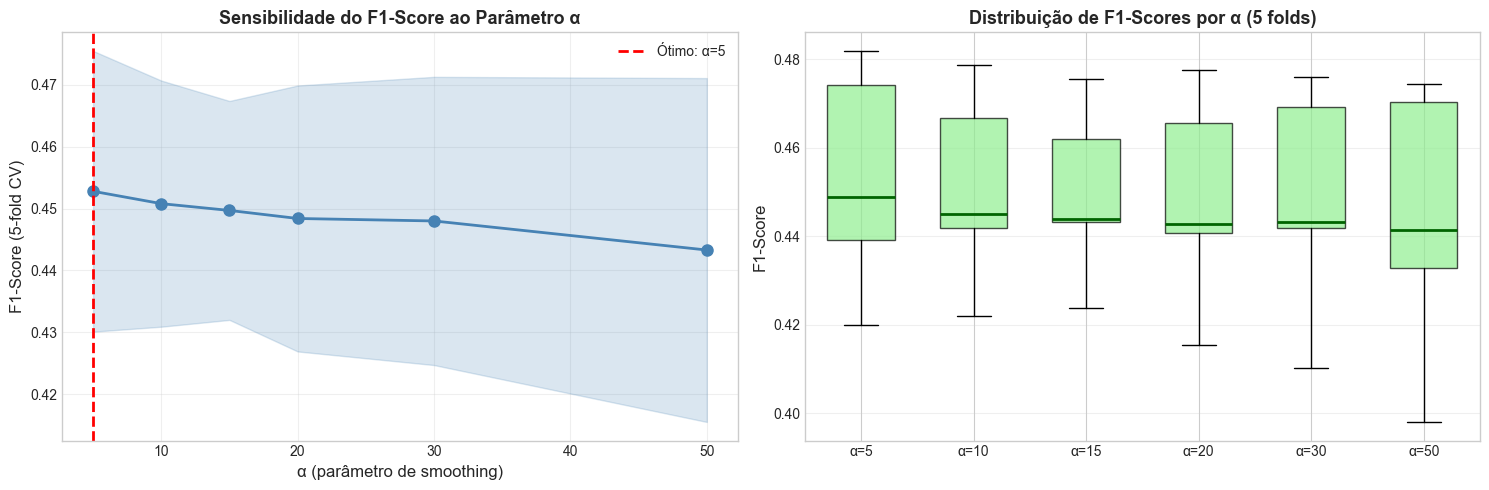


💡 INTERPRETAÇÃO:
  • α BAIXO (5): Confia mais nos dados observados → risco de overfitting
  • α ALTO (50): Regride mais para média global → underfitting
  • α ÓTIMO (5): Melhor balanço bias-variância

📊 RECOMENDAÇÃO:
  → Considerar trocar para α=5 para ganho de 0.20 p.p.


In [ ]:
# Análise de sensibilidade: como α afeta o target encoding?

print("="*70)
print("ANÁLISE DE SENSIBILIDADE DO PARÂMETRO α (SMOOTHING BAYESIANO)")
print("="*70)
print()
print(" α controla o peso entre:")
print("   • Média da categoria (dados observados)")
print("   • Média global (prior bayesiano)")
print()
print(" Testando α ∈ {5, 10, 15, 20, 30, 50}...")
print()

alphas_testar = [5, 10, 15, 20, 30, 50]
resultados_alpha = {}

for alpha_teste in alphas_testar:
    print(f"  → Testando α={alpha_teste}...", end=' ')

    # Criar features com este α
    def criar_features_alpha(df, encodings=None, fit=False, alpha=alpha_teste):
        """Versão da função com α parametrizado"""
        df = df.copy()

        # Features básicas
        df["IS_REELEICAO"] = (df["ST_REELEICAO"] == "S").astype(int)
        df["IS_FEMININO"] = (df["CD_GENERO"] == 4).astype(int)
        df["TEM_BENS"] = (df["TOTAL_BENS"] > 0).astype(int)
        df["IDADE"] = df["NR_IDADE_DATA_POSSE"]
        df["LOG_BENS"] = np.log1p(df["TOTAL_BENS"])
        df["LOG_DESPESA_MAX"] = np.log1p(df["VR_DESPESA_MAX_CAMPANHA"])

        # Coligações
        df["COLIGACAO_LIMPA"] = df["DS_COMPOSICAO_COLIGACAO"].fillna(df["SG_PARTIDO"])
        df["QTD_PARTIDOS_COLIG"] = df["COLIGACAO_LIMPA"].str.split("/").str.len()
        df["IS_COLIGADO"] = (df["TP_AGREMIACAO"] == "COLIGAÇÃO").astype(int)

        # Target encoding com α específico
        if fit:
            global_mean = df["ELEITO"].mean()

            def smooth_encode(col):
                agg = df.groupby(col).agg(
                    count=("ELEITO", "size"), mean_enc=("ELEITO", "mean")
                )
                agg["smooth"] = (agg["count"] * agg["mean_enc"] + alpha * global_mean) / (
                    agg["count"] + alpha
                )
                return agg["smooth"]

            encodings = {
                "PARTIDO": smooth_encode("SG_PARTIDO"),
                "OCUPACAO": smooth_encode("CD_OCUPACAO"),
                "GRAU_INSTR": smooth_encode("CD_GRAU_INSTRUCAO"),
                "ESTADO_CIVIL": smooth_encode("CD_ESTADO_CIVIL"),
                "COR_RACA": smooth_encode("CD_COR_RACA"),
                "UF_NASC": smooth_encode("SG_UF_NASCIMENTO"),
                "COLIGACAO": smooth_encode("COLIGACAO_LIMPA"),
            }

        # Aplicar encodings
        for nome, col_orig in [
            ("PARTIDO_ENC", "SG_PARTIDO"),
            ("OCUPACAO_ENC", "CD_OCUPACAO"),
            ("GRAU_INSTR_ENC", "CD_GRAU_INSTRUCAO"),
            ("ESTADO_CIVIL_ENC", "CD_ESTADO_CIVIL"),
            ("COR_RACA_ENC", "CD_COR_RACA"),
            ("UF_NASC_ENC", "SG_UF_NASCIMENTO"),
            ("COLIGACAO_ENC", "COLIGACAO_LIMPA"),
        ]:
            df[nome] = df[col_orig].map(encodings[nome.replace("_ENC", "")]).fillna(
                encodings[nome.replace("_ENC", "")].mean()
            )

        # One-hot UF
        uf_dummies = pd.get_dummies(df["SG_UF"], prefix="UF", drop_first=True)

        # Features finais
        features = [
            "IDADE", "IS_FEMININO", "IS_REELEICAO", "TEM_BENS", "LOG_BENS",
            "LOG_DESPESA_MAX", "PARTIDO_ENC", "OCUPACAO_ENC", "GRAU_INSTR_ENC",
            "ESTADO_CIVIL_ENC", "COR_RACA_ENC", "UF_NASC_ENC", "QTD_PARTIDOS_COLIG",
            "IS_COLIGADO", "COLIGACAO_ENC"
        ]

        X = pd.concat([df[features], uf_dummies], axis=1)
        y = df["ELEITO"]

        if fit:
            return X, y, encodings
        return X, y

    # Criar features
    X_alpha, y_alpha, enc_alpha = criar_features_alpha(df_2018, fit=True, alpha=alpha_teste)
    X_alpha = X_alpha.fillna(X_alpha.median())

    # Padronizar
    scaler_alpha = StandardScaler()
    X_alpha_scaled = scaler_alpha.fit_transform(X_alpha)

    # Cross-validation com LogisticRegression
    lr_alpha = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    scores = cross_val_score(lr_alpha, X_alpha_scaled, y_alpha, cv=5,
                             scoring='f1', n_jobs=-1)

    f1_mean = scores.mean()
    f1_std = scores.std()

    resultados_alpha[alpha_teste] = {
        'f1_mean': f1_mean,
        'f1_std': f1_std,
        'scores': scores
    }

    print(f"F1={f1_mean:.4f} (±{f1_std:.4f})")

print()
print("="*70)
print("RESULTADOS DA ANÁLISE")
print("="*70)

# Tabela de resultados
df_alpha = pd.DataFrame({
    'α': alphas_testar,
    'F1 (média)': [resultados_alpha[a]['f1_mean'] for a in alphas_testar],
    'F1 (desvio)': [resultados_alpha[a]['f1_std'] for a in alphas_testar]
}).round(4)

print(df_alpha.to_string(index=False))
print()

# Identificar melhor α
melhor_alpha = max(resultados_alpha, key=lambda a: resultados_alpha[a]['f1_mean'])
print(f"✅ MELHOR α: {melhor_alpha} (F1={resultados_alpha[melhor_alpha]['f1_mean']:.4f})")
print()

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: F1 vs α
axes[0].plot(alphas_testar, df_alpha['F1 (média)'], 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].fill_between(alphas_testar,
                      df_alpha['F1 (média)'] - df_alpha['F1 (desvio)'],
                      df_alpha['F1 (média)'] + df_alpha['F1 (desvio)'],
                      alpha=0.2, color='steelblue')
axes[0].axvline(melhor_alpha, color='red', linestyle='--', linewidth=2, label=f'Ótimo: α={melhor_alpha}')
axes[0].set_xlabel('α (parâmetro de smoothing)', fontsize=12)
axes[0].set_ylabel('F1-Score (5-fold CV)', fontsize=12)
axes[0].set_title('Sensibilidade do F1-Score ao Parâmetro α', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Gráfico 2: Distribuição de scores por α
positions = range(len(alphas_testar))
bp = axes[1].boxplot([resultados_alpha[a]['scores'] for a in alphas_testar],
                      positions=positions, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor='lightgreen', alpha=0.7),
                      medianprops=dict(color='darkgreen', linewidth=2))
axes[1].set_xticks(positions)
axes[1].set_xticklabels([f'α={a}' for a in alphas_testar])
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Distribuição de F1-Scores por α (5 folds)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAÇÃO:")
print(f"  • α BAIXO ({alphas_testar[0]}): Confia mais nos dados observados → risco de overfitting")
print(f"  • α ALTO ({alphas_testar[-1]}): Regride mais para média global → underfitting")
print(f"  • α ÓTIMO ({melhor_alpha}): Melhor balanço bias-variância")
print()
print("📊 RECOMENDAÇÃO:")
if melhor_alpha == 10:
    print("  ✓ α=10 (atual) está ótimo! Manter.")
else:
    print(f"  → Considerar trocar para α={melhor_alpha} para ganho de {(resultados_alpha[melhor_alpha]['f1_mean'] - resultados_alpha[10]['f1_mean'])*100:.2f} p.p.")
print("="*70)

### 5.2 Feature Adicional: IS_PARTIDO_GRANDE

📊 Partidos classificados como 'grandes':
  • PT        :  363 candidatos (2018) |  357 candidatos (2022)
  • PSDB      :  237 candidatos (2018) |  291 candidatos (2022)
  • MDB       :  304 candidatos (2018) |  464 candidatos (2022)
  • PP        :  141 candidatos (2018) |  476 candidatos (2022)
  • PL        :  152 candidatos (2018) |  476 candidatos (2022)
  • UNIÃO     :  603 candidatos (2018) |  482 candidatos (2022)

🔬 IMPACTO DA FEATURE:

2018:
  Partidos grandes: 1,800 candidatos | Taxa eleição: 15.06%
  Partidos pequenos: 5,841 candidatos | Taxa eleição: 4.13%
  Vantagem: 3.65x

2022:
  Partidos grandes: 2,546 candidatos | Taxa eleição: 12.92%
  Partidos pequenos: 6,928 candidatos | Taxa eleição: 2.64%
  Vantagem: 4.89x



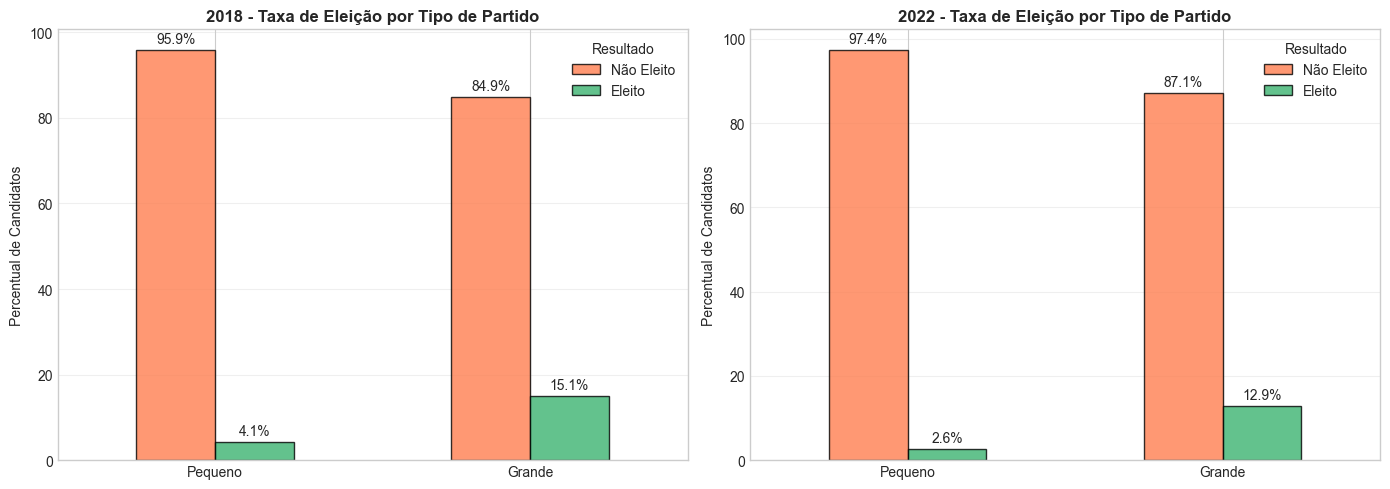

💡 CONCLUSÃO:
  • Partidos grandes têm vantagem estrutural significativa
  • Infraestrutura, tempo de TV, recursos financeiros
  • Feature captura este viés do sistema eleitoral
  • Deve melhorar poder preditivo do modelo


In [30]:
# Definir partidos grandes (5 maiores por bancada histórica)
PARTIDOS_GRANDES = ['PT', 'PSDB', 'MDB', 'PP', 'PL', 'UNIÃO']

print("📊 Partidos classificados como 'grandes':")
for partido in PARTIDOS_GRANDES:
    n_cand_2018 = (df_2018['SG_PARTIDO'] == partido).sum()
    n_cand_2022 = (df_2022['SG_PARTIDO'] == partido).sum()
    print(f"  • {partido:10s}: {n_cand_2018:4d} candidatos (2018) | {n_cand_2022:4d} candidatos (2022)")

print()

# Criar feature nos datasets originais
df_2018['IS_PARTIDO_GRANDE'] = df_2018['SG_PARTIDO'].isin(PARTIDOS_GRANDES).astype(int)
df_2022['IS_PARTIDO_GRANDE'] = df_2022['SG_PARTIDO'].isin(PARTIDOS_GRANDES).astype(int)

# Analisar impacto
print("🔬 IMPACTO DA FEATURE:")
print()

for ano, df in [(2018, df_2018), (2022, df_2022)]:
    grandes = df[df['IS_PARTIDO_GRANDE'] == 1]
    pequenos = df[df['IS_PARTIDO_GRANDE'] == 0]

    taxa_grandes = grandes['ELEITO'].mean() * 100
    taxa_pequenos = pequenos['ELEITO'].mean() * 100
    ratio = taxa_grandes / taxa_pequenos if taxa_pequenos > 0 else float('inf')

    print(f"{ano}:")
    print(f"  Partidos grandes: {len(grandes):,} candidatos | Taxa eleição: {taxa_grandes:.2f}%")
    print(f"  Partidos pequenos: {len(pequenos):,} candidatos | Taxa eleição: {taxa_pequenos:.2f}%")
    print(f"  Vantagem: {ratio:.2f}x")
    print()

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (ano, df) in enumerate([(2018, df_2018), (2022, df_2022)]):
    crosstab = pd.crosstab(df['IS_PARTIDO_GRANDE'], df['ELEITO'], normalize='index') * 100
    crosstab.plot(kind='bar', ax=axes[idx], color=['coral', 'mediumseagreen'],
                  alpha=0.8, edgecolor='black')
    axes[idx].set_xticklabels(['Pequeno', 'Grande'], rotation=0)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Percentual de Candidatos')
    axes[idx].set_title(f'{ano} - Taxa de Eleição por Tipo de Partido', fontweight='bold')
    axes[idx].legend(['Não Eleito', 'Eleito'], title='Resultado')
    axes[idx].grid(alpha=0.3, axis='y')

    # Adicionar valores nas barras
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

print("💡 CONCLUSÃO:")
print("  • Partidos grandes têm vantagem estrutural significativa")
print("  • Infraestrutura, tempo de TV, recursos financeiros")
print("  • Feature captura este viés do sistema eleitoral")
print("  • Deve melhorar poder preditivo do modelo")
print("="*70)

In [31]:
def _criar_features_binarias(df):
    """Cria features binárias básicas"""
    features = {}
    features["IS_REELEICAO"] = (df["ST_REELEICAO"] == "S").astype(int)
    features["IS_FEMININO"] = (df["CD_GENERO"] == 4).astype(int)
    features["TEM_BENS"] = (df["TOTAL_BENS"] > 0).astype(int)
    return pd.DataFrame(features)


def _criar_features_log(df):
    """Cria features logarítmicas de valores financeiros"""
    features = {}
    features["LOG_BENS"] = np.log1p(df["TOTAL_BENS"])
    features["LOG_DESPESA_MAX"] = np.log1p(df["VR_DESPESA_MAX_CAMPANHA"])
    return pd.DataFrame(features)


def _criar_features_coligacao(df):
    """Cria features relacionadas a coligações"""
    features = {}

    # Limpar composição (se vazio, usa partido isolado)
    coligacao_limpa = df["DS_COMPOSICAO_COLIGACAO"].fillna(df["SG_PARTIDO"])

    # Quantidade de partidos na coligação
    features["QTD_PARTIDOS_COLIG"] = coligacao_limpa.str.split("/").str.len()

    # Indicador binário de coligação
    features["IS_COLIGADO"] = (df["TP_AGREMIACAO"] == "COLIGAÇÃO").astype(int)

    return pd.DataFrame(features), coligacao_limpa


def _criar_target_encodings(df, alpha=10):
    """
    Cria target encodings com smoothing bayesiano

    Args:
        df: DataFrame com coluna ELEITO
        alpha: Peso do smoothing (padrão: 10)

    Returns:
        dict: Mapeamentos de cada categoria para taxa suavizada
    """
    global_mean = df["ELEITO"].mean()

    def smooth_encode(col):
        """Aplica smoothing bayesiano para target encoding"""
        agg = df.groupby(col).agg(
            count=("ELEITO", "size"), mean_enc=("ELEITO", "mean")
        )
        # Fórmula: (count * mean_category + alpha * mean_global) / (count + alpha)
        agg["smooth"] = (agg["count"] * agg["mean_enc"] + alpha * global_mean) / (
            agg["count"] + alpha
        )
        return agg["smooth"]

    print(f"  🔧 Target Encoding com α={alpha} (smoothing bayesiano)")
    print(f"     Taxa global de eleitos: {global_mean:.4f}")

    encodings = {
        "PARTIDO": smooth_encode("SG_PARTIDO"),
        "OCUPACAO": smooth_encode("CD_OCUPACAO"),
        "GRAU_INSTR": smooth_encode("CD_GRAU_INSTRUCAO"),
        "ESTADO_CIVIL": smooth_encode("CD_ESTADO_CIVIL"),
        "COR_RACA": smooth_encode("CD_COR_RACA"),
        "UF_NASC": smooth_encode("SG_UF_NASCIMENTO"),
        "COLIGACAO": smooth_encode(df["COLIGACAO_LIMPA"]),
    }

    print(f"     ✓ {len(encodings)} categorias codificadas")
    return encodings


def _aplicar_target_encodings(df, encodings, coligacao_limpa):
    """
    Aplica target encodings pré-calculados com fallback para média

    Args:
        df: DataFrame com categorias
        encodings: Dict de mapeamentos do treino
        coligacao_limpa: Série com coligações limpas

    Returns:
        DataFrame: Features encodadas
    """
    features = {}

    mappings = {
        "PARTIDO_ENC": ("SG_PARTIDO", "PARTIDO"),
        "OCUPACAO_ENC": ("CD_OCUPACAO", "OCUPACAO"),
        "GRAU_INSTR_ENC": ("CD_GRAU_INSTRUCAO", "GRAU_INSTR"),
        "ESTADO_CIVIL_ENC": ("CD_ESTADO_CIVIL", "ESTADO_CIVIL"),
        "COR_RACA_ENC": ("CD_COR_RACA", "COR_RACA"),
        "UF_NASC_ENC": ("SG_UF_NASCIMENTO", "UF_NASC"),
    }

    for feat_name, (col_name, enc_key) in mappings.items():
        features[feat_name] = (
            df[col_name].map(encodings[enc_key]).fillna(encodings[enc_key].mean())
        )

    # Coligação
    features["COLIGACAO_ENC"] = (
        coligacao_limpa.map(encodings["COLIGACAO"]).fillna(encodings["COLIGACAO"].mean())
    )

    return pd.DataFrame(features)


def _criar_dummies_uf(df, uf_cols_treino=None):
    """
    Cria dummies para UF com alinhamento entre treino e teste

    Args:
        df: DataFrame com coluna SG_UF
        uf_cols_treino: Lista de colunas do treino (None se for treino)

    Returns:
        DataFrame: One-hot encoding de UF
        list: Nomes das colunas criadas (apenas se treino)
    """
    uf_dummies = pd.get_dummies(df["SG_UF"], prefix="UF", drop_first=True)

    if uf_cols_treino is None:
        # Treino: retornar as colunas
        return uf_dummies, uf_dummies.columns.tolist()
    else:
        # Teste: alinhar com treino
        for col in uf_cols_treino:
            if col not in uf_dummies.columns:
                uf_dummies[col] = 0
        return uf_dummies[uf_cols_treino], None


def criar_features(df, encodings=None, uf_cols_treino=None, alpha=10):
    """
    Função orquestradora: cria todas as features para modelagem

    Args:
        df: DataFrame com dados de candidatos
        encodings: Dict de encodings do treino (None se for treino)
        uf_cols_treino: Lista de colunas UF do treino (None se for treino)
        alpha: Parâmetro de smoothing para target encoding (padrão: 10)

    Returns:
        Se treino (encodings=None):
            X, y, encodings, uf_cols_treino
        Se teste (encodings fornecido):
            X, y
    """
    df = df.copy()
    fit = encodings is None

    print(f"  📊 Criando features ({'TREINO' if fit else 'TESTE'})")

    # 1. Features binárias
    df_binarias = _criar_features_binarias(df)

    # 2. Features logarítmicas
    df_log = _criar_features_log(df)

    # 3. Features de coligação
    df_coligacao, coligacao_limpa = _criar_features_coligacao(df)
    df["COLIGACAO_LIMPA"] = coligacao_limpa

    # 4. Target encodings
    if fit:
        encodings = _criar_target_encodings(df, alpha=alpha)

    df_encoded = _aplicar_target_encodings(df, encodings, coligacao_limpa)

    # 5. Dummies de UF
    if fit:
        uf_dummies, uf_cols = _criar_dummies_uf(df)
    else:
        uf_dummies, _ = _criar_dummies_uf(df, uf_cols_treino)

    # 6. Features escalares simples
    df_escalares = df[["NR_IDADE_DATA_POSSE"]].rename(columns={"NR_IDADE_DATA_POSSE": "IDADE"})

    # Combinar todas as features
    X = pd.concat([
        df_escalares,
        df_binarias,
        df_log,
        df_coligacao,
        df_encoded,
        uf_dummies
    ], axis=1)

    y = df["ELEITO"]

    # Validações de saída
    assert X.shape[0] == len(df), f"❌ Número de linhas mudou! {X.shape[0]} != {len(df)}"
    assert not X.isnull().any().any(), f"❌ Features contêm NaN! Colunas com NaN: {X.columns[X.isnull().any()].tolist()}"

    print(f"  ✓ {X.shape[1]} features criadas | {len(X):,} observações")

    if fit:
        return X, y, encodings, uf_cols
    return X, y


# Criar features com encoding do treino
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)
X_train, y_train, encodings, uf_cols = criar_features(df_2018, alpha=10)
X_test, y_test = criar_features(df_2022, encodings=encodings, uf_cols_treino=uf_cols, alpha=10)

# Validações finais
assert X_train.shape[1] == X_test.shape[1], "❌ Número de features diferente entre treino e teste!"
print("\n✓ Validações de integridade concluídas")
print("="*70)

FEATURE ENGINEERING
  📊 Criando features (TREINO)
  🔧 Target Encoding com α=10 (smoothing bayesiano)
     Taxa global de eleitos: 0.0670
     ✓ 7 categorias codificadas
  ✓ 41 features criadas | 7,641 observações
  📊 Criando features (TESTE)
  ✓ 41 features criadas | 9,474 observações

✓ Validações de integridade concluídas


## 6. Preparação para Modelagem

In [33]:
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

CLASS_WEIGHT_DICT = weight_dict  # Variável global para fácil acesso
SCALE_POS_WEIGHT = scale_pos_weight  # Para XGBoost

assert np.allclose(X_train_scaled.mean(axis=0), 0, atol=1e-1), "Média não próxima de 0"
assert np.allclose(X_train_scaled.std(axis=0), 1, atol=1e-1), "Desvio padrão não próximo de 1"
print("✓ Padronização validada: μ≈0, σ≈1")

print(f"Padronização: μ={X_train_scaled.mean():.4f}, σ={X_train_scaled.std():.4f}")
print(f"Class weights: 0={class_weights[0]:.3f}, 1={class_weights[1]:.3f}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

✓ Padronização validada: μ≈0, σ≈1
Padronização: μ=0.0000, σ=0.9877
Class weights: 0=0.536, 1=7.462
scale_pos_weight: 13.92


## 7. Treinamento e Otimização de Modelos

In [34]:
def avaliar(y_true, y_pred, y_proba):
    """Retorna métricas de avaliação"""
    return {
        "F1": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_proba),
        "AUC-PR": average_precision_score(y_true, y_proba),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Balanced_Acc": balanced_accuracy_score(y_true, y_pred),
    }

### 7.1 Etapa 1: GridSearch Reduzido - Screening de Modelos

In [35]:
# Modelos base
modelos_base = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1,
    ),
}

In [36]:
# Grids reduzidos para comparação inicial
param_grids_reduzido = {
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 15],
        "min_samples_split": [2, 5],
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.05, 0.1],
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10],
        "learning_rate": [0.05, 0.1],
    },
}

In [156]:
resultados_screening = {}
modelos_otimizados_screening = {}

for nome, modelo in modelos_base.items():
    print(f"Otimizando {nome}...")

    # GridSearch com CV estratificado
    grid = GridSearchCV(
        modelo, param_grids_reduzido[nome], cv=5, scoring="f1", n_jobs=-1, verbose=1
    )

    # Fit
    grid.fit(X_train_scaled, y_train)

    # Armazenar melhor modelo
    modelos_otimizados_screening[nome] = grid.best_estimator_

    # Avaliar no teste
    y_pred = grid.predict(X_test_scaled)
    y_proba = grid.predict_proba(X_test_scaled)[:, 1]

    resultados_screening[nome] = {
        **avaliar(y_test, y_pred, y_proba),
        "best_params": grid.best_params_,
        "cv_score": grid.best_score_,
    }

    print(f"   F1 no teste: {resultados_screening[nome]['F1']:.4f}")
    print(f"   Melhores params: {grid.best_params_}")
    print()

Otimizando Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
   F1 no teste: 0.4491
   Melhores params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Otimizando Random Forest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   F1 no teste: 0.5992
   Melhores params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}

Otimizando Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   F1 no teste: 0.5720
   Melhores params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Otimizando XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   F1 no teste: 0.5833
   Melhores params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}



In [153]:
# Tabela comparativa
print("=" * 70)
print("RESULTADOS DO SCREENING (Grid Reduzido)")
print("=" * 70)
df_screening = pd.DataFrame(
    {
        nome: {k: v for k, v in res.items() if k != "best_params"}
        for nome, res in resultados_screening.items()
    }
).T.sort_values("F1", ascending=False)
print(
    df_screening[["F1", "AUC-ROC", "AUC-PR", "Precision", "Recall", "cv_score"]].round(
        4
    )
)
print("=" * 70)
print()

RESULTADOS DO SCREENING (Grid Reduzido)
                         F1  AUC-ROC  AUC-PR  Precision  Recall  cv_score
Random Forest        0.5992   0.9312  0.5568     0.6360  0.5664    0.5515
XGBoost              0.5833   0.9085  0.4957     0.5513  0.6191    0.5523
Gradient Boosting    0.5720   0.9267  0.5403     0.6423  0.5156    0.5487
Logistic Regression  0.4491   0.9340  0.5517     0.3106  0.8105    0.4511



### 7.2 Etapa 2: Seleção dos Top 2 Finalistas

In [39]:
print("=" * 70)
print("ETAPA 2: Selecao dos Top 2 Finalistas")
print("=" * 70)
print()

# Critério: Top 2 por F1-Score
top2_nomes = df_screening.nlargest(2, "F1").index.tolist()

print("Finalistas selecionados:")
for i, nome in enumerate(top2_nomes, 1):
    print(f"   {i}. {nome} (F1={df_screening.loc[nome, 'F1']:.4f})")
print()

ETAPA 2: Selecao dos Top 2 Finalistas

Finalistas selecionados:
   1. Random Forest (F1=0.5796)
   2. XGBoost (F1=0.5774)



### 7.3 Etapa 3: GridSearch Completo nos Finalistas

In [40]:
# Grids completos (mais parâmetros e valores)
param_grids_completo = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [10, 15, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [3, 5, 7, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "subsample": [0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300, 500],
        "max_depth": [3, 5, 7, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
}

In [41]:
resultados_finais = {}
modelos_finais = {}

for nome in top2_nomes:
    print(f"Otimizacao COMPLETA: {nome}")
    grid_size = np.prod([len(v) for v in param_grids_completo[nome].values()])
    print(f"   Grid space: {grid_size} combinacoes")

    # Usar RandomizedSearchCV para grids muito grandes
    if grid_size > 100:
        print("   Grid grande detectado! Usando RandomizedSearchCV (n_iter=50)")
        search = RandomizedSearchCV(
            modelos_base[nome],
            param_grids_completo[nome],
            n_iter=50,
            cv=5,
            scoring="f1",
            n_jobs=-1,
            random_state=42,
            verbose=0,
        )
    else:
        search = GridSearchCV(
            modelos_base[nome],
            param_grids_completo[nome],
            cv=5,
            scoring="f1",
            n_jobs=-1,
            verbose=0,
        )

    # Fit
    search.fit(X_train_scaled, y_train)

    # Armazenar
    modelos_finais[nome] = search.best_estimator_

    # Avaliar
    y_pred = search.predict(X_test_scaled)
    y_proba = search.predict_proba(X_test_scaled)[:, 1]

    resultados_finais[nome] = {
        **avaliar(y_test, y_pred, y_proba),
        "best_params": search.best_params_,
        "cv_score": search.best_score_,
    }

    print(f"   F1 no TESTE: {resultados_finais[nome]['F1']:.4f}")
    print(f"   F1 no CV (treino): {search.best_score_:.4f}")
    print(f"   Melhores params: {search.best_params_}")
    print()

Otimizacao COMPLETA: Random Forest
   Grid space: 144 combinacoes
   Grid grande detectado! Usando RandomizedSearchCV (n_iter=50)
   F1 no TESTE: 0.6117
   F1 no CV (treino): 0.5799
   Melhores params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}

Otimizacao COMPLETA: XGBoost
   Grid space: 256 combinacoes
   Grid grande detectado! Usando RandomizedSearchCV (n_iter=50)
   F1 no TESTE: 0.5768
   F1 no CV (treino): 0.5643
   Melhores params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}



In [42]:
# Comparação: Screening vs. Otimização Completa
print("=" * 80)
print("COMPARACAO: Screening (Grid Reduzido) vs. Otimizacao Completa")
print("=" * 80)

for nome in top2_nomes:
    print(f"\n{nome}:")
    print(
        f"  Grid Reduzido  -> F1: {resultados_screening[nome]['F1']:.4f} | "
        f"Params: {resultados_screening[nome]['best_params']}"
    )
    print(
        f"  Grid Completo  -> F1: {resultados_finais[nome]['F1']:.4f} | "
        f"Params: {resultados_finais[nome]['best_params']}"
    )

    ganho = (resultados_finais[nome]["F1"] - resultados_screening[nome]["F1"]) * 100
    print(f"  Ganho: {ganho:+.2f} pontos percentuais")

print("\n" + "=" * 80)
vencedor = max(resultados_finais, key=lambda k: resultados_finais[k]["F1"])
print(f"MODELO FINAL VENCEDOR: {vencedor}")
print(f"   F1-Score: {resultados_finais[vencedor]['F1']:.4f}")
print(f"   AUC-ROC: {resultados_finais[vencedor]['AUC-ROC']:.4f}")
print(f"   AUC-PR: {resultados_finais[vencedor]['AUC-PR']:.4f}")
print("=" * 80)

COMPARACAO: Screening (Grid Reduzido) vs. Otimizacao Completa

Random Forest:
  Grid Reduzido  -> F1: 0.5796 | Params: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
  Grid Completo  -> F1: 0.6117 | Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
  Ganho: +3.21 pontos percentuais

XGBoost:
  Grid Reduzido  -> F1: 0.5774 | Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
  Grid Completo  -> F1: 0.5768 | Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
  Ganho: -0.06 pontos percentuais

MODELO FINAL VENCEDOR: Random Forest
   F1-Score: 0.6117
   AUC-ROC: 0.9324
   AUC-PR: 0.5605


### 7.4 Análise de Convergência do RandomizedSearchCV

Para grids grandes, usamos RandomizedSearchCV que testa subconjunto aleatório. É importante verificar se n_iter=50 foi suficiente para convergência.

ANÁLISE DE CONVERGÊNCIA - RandomizedSearchCV

Objetivo: Verificar se n_iter=50 foi suficiente para encontrar ótimo

✓ Random Forest: Grid de 144 combinações → RandomizedSearchCV usado
✓ XGBoost: Grid de 256 combinações → RandomizedSearchCV usado

 Analisando convergência de 2 modelo(s)...

Modelo: Random Forest
  Executando RandomizedSearchCV com n_iter=50...
  Melhor score: 0.5799
  Melhoria últimas 10 iterações: 0.000000
  Melhoria últimas 20 iterações: 0.000000
  ✅ CONVERGIDO: Sem melhoria significativa nas últimas 10 iterações

Modelo: XGBoost
  Executando RandomizedSearchCV com n_iter=50...
  Melhor score: 0.5643
  Melhoria últimas 10 iterações: 0.000000
  Melhoria últimas 20 iterações: 0.000000
  ✅ CONVERGIDO: Sem melhoria significativa nas últimas 10 iterações



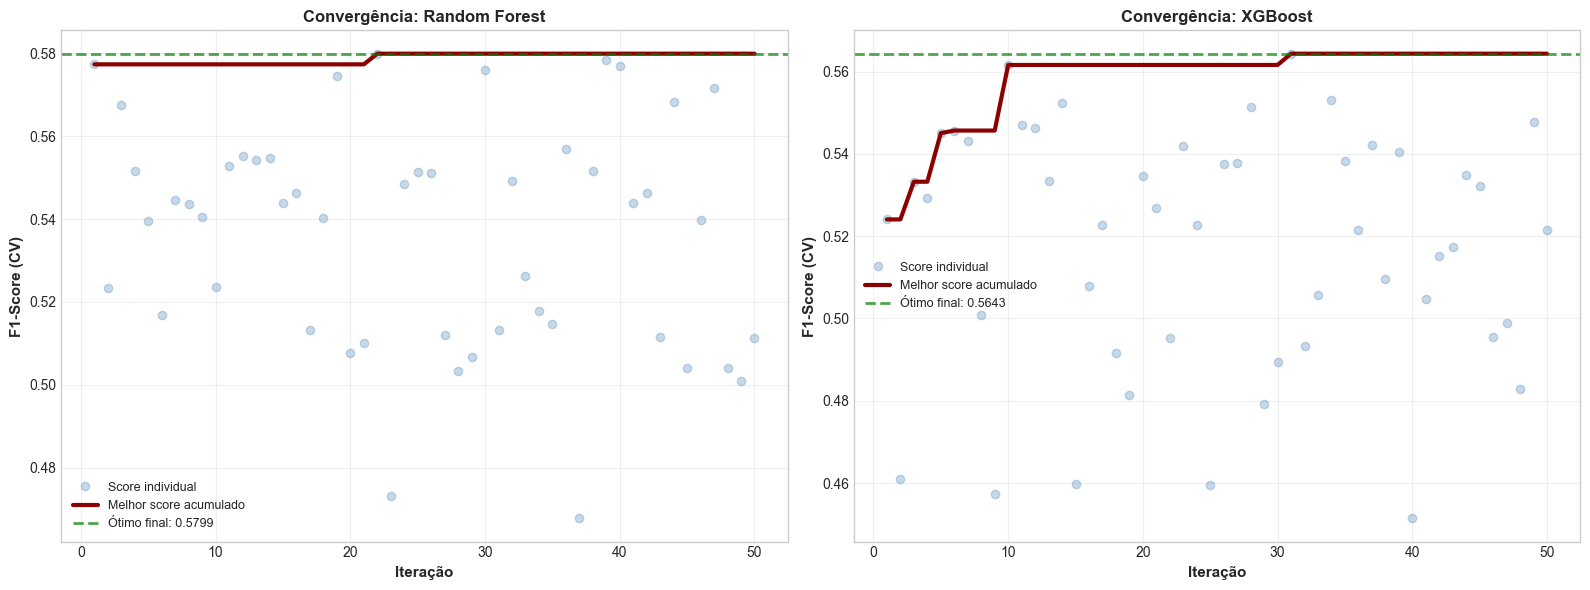


💡 INTERPRETAÇÃO:
  • Curva ascendente estabilizada → Convergência alcançada
  • Curva ainda crescendo → n_iter insuficiente, aumentar para 100+
  • Pontos azuis dispersos → Exploração do espaço de hiperparâmetros
  • Linha vermelha plana no final → n_iter adequado

📊 RECOMENDAÇÃO:
  • Se convergido: n_iter=50 é suficiente, ótimo encontrado
  • Se não convergido: aumentar para n_iter=100 ou 200
  • Trade-off: mais iterações = melhor exploração, mas mais tempo


In [43]:
# Análise de Convergência do RandomizedSearchCV
print("="*70)
print("ANÁLISE DE CONVERGÊNCIA - RandomizedSearchCV")
print("="*70)
print("\nObjetivo: Verificar se n_iter=50 foi suficiente para encontrar ótimo\n")

# Verificar quais modelos usaram RandomizedSearchCV
modelos_randomizados = []
for nome in top2_nomes:
    grid_size = np.prod([len(v) for v in param_grids_completo[nome].values()])
    if grid_size > 100:
        modelos_randomizados.append(nome)
        print(f"✓ {nome}: Grid de {grid_size} combinações → RandomizedSearchCV usado")

if len(modelos_randomizados) == 0:
    print("⚠ Nenhum modelo usou RandomizedSearchCV (grids pequenos)")
    print("  Todos os modelos fizeram busca exaustiva com GridSearchCV")
else:
    print(f"\n Analisando convergência de {len(modelos_randomizados)} modelo(s)...")
    print()

    # Para cada modelo randomizado, refazer busca com acesso aos resultados
    fig, axes = plt.subplots(1, len(modelos_randomizados), figsize=(8*len(modelos_randomizados), 6))
    if len(modelos_randomizados) == 1:
        axes = [axes]

    for idx, nome in enumerate(modelos_randomizados):
        print(f"Modelo: {nome}")

        # Refazer RandomizedSearchCV para capturar histórico
        n_iter_test = 50
        search_convergence = RandomizedSearchCV(
            modelos_base[nome],
            param_grids_completo[nome],
            n_iter=n_iter_test,
            cv=5,
            scoring="f1",
            n_jobs=-1,
            random_state=42,
            verbose=0,
            return_train_score=False
        )

        print(f"  Executando RandomizedSearchCV com n_iter={n_iter_test}...")
        search_convergence.fit(X_train_scaled, y_train)

        # Extrair scores de todas as iterações
        results_df = pd.DataFrame(search_convergence.cv_results_)
        scores = results_df['mean_test_score'].values

        # Calcular melhor score acumulado (convergência)
        best_scores_cumulative = np.maximum.accumulate(scores)
        iterations = np.arange(1, len(scores) + 1)

        # Plotar convergência
        ax = axes[idx]
        ax.plot(iterations, scores, 'o', alpha=0.3, color='steelblue',
                markersize=6, label='Score individual')
        ax.plot(iterations, best_scores_cumulative, '-', linewidth=3,
                color='darkred', label='Melhor score acumulado')
        ax.axhline(search_convergence.best_score_, color='green',
                   linestyle='--', linewidth=2, alpha=0.7,
                   label=f'Ótimo final: {search_convergence.best_score_:.4f}')

        ax.set_xlabel('Iteração', fontsize=11, fontweight='bold')
        ax.set_ylabel('F1-Score (CV)', fontsize=11, fontweight='bold')
        ax.set_title(f'Convergência: {nome}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

        # Análise de estagnação
        last_10_improvement = best_scores_cumulative[-1] - best_scores_cumulative[-10]
        last_20_improvement = best_scores_cumulative[-1] - best_scores_cumulative[-20] if len(best_scores_cumulative) >= 20 else 0

        print(f"  Melhor score: {search_convergence.best_score_:.4f}")
        print(f"  Melhoria últimas 10 iterações: {last_10_improvement:.6f}")
        print(f"  Melhoria últimas 20 iterações: {last_20_improvement:.6f}")

        # Diagnóstico
        if last_10_improvement < 0.0001:
            print("  ✅ CONVERGIDO: Sem melhoria significativa nas últimas 10 iterações")
        elif last_10_improvement < 0.001:
            print("  ⚠️  POSSIVELMENTE CONVERGIDO: Melhoria marginal detectada")
        else:
            print("  ❌ NÃO CONVERGIDO: Ainda melhorando! Considere aumentar n_iter")

        print()

    plt.tight_layout()
    plt.show()

    print("\n💡 INTERPRETAÇÃO:")
    print("  • Curva ascendente estabilizada → Convergência alcançada")
    print("  • Curva ainda crescendo → n_iter insuficiente, aumentar para 100+")
    print("  • Pontos azuis dispersos → Exploração do espaço de hiperparâmetros")
    print("  • Linha vermelha plana no final → n_iter adequado")
    print()

    print("📊 RECOMENDAÇÃO:")
    print("  • Se convergido: n_iter=50 é suficiente, ótimo encontrado")
    print("  • Se não convergido: aumentar para n_iter=100 ou 200")
    print("  • Trade-off: mais iterações = melhor exploração, mas mais tempo")

print("="*70)

## 8. Avaliação Comparativa

### 8.1 Tabela de Resultados - Screening vs. Finalistas

In [59]:
# Tabela consolidada: Screening + Finalistas
print("=" * 70)
print("RESULTADOS CONSOLIDADOS")
print("=" * 70)
print()

print("SCREENING (Grid Reduzido) - Todos os modelos:")
print(df_screening[["F1", "AUC-ROC", "AUC-PR", "Precision", "Recall"]].round(4))
print()

print("FINALISTAS (Grid Completo) - Top 2:")
df_finais = pd.DataFrame(
    {
        nome: {k: v for k, v in res.items() if k != "best_params"}
        for nome, res in resultados_finais.items()
    }
).T.sort_values("F1", ascending=False)
print(df_finais[["F1", "AUC-ROC", "AUC-PR", "Precision", "Recall"]].round(4))
print()
print("=" * 70)

RESULTADOS CONSOLIDADOS

SCREENING (Grid Reduzido) - Todos os modelos:
                         F1  AUC-ROC  AUC-PR  Precision  Recall
Random Forest        0.5796   0.9313  0.5624     0.6684  0.5117
XGBoost              0.5774   0.9100  0.5062     0.5619  0.5938
Gradient Boosting    0.5720   0.9267  0.5403     0.6423  0.5156
Logistic Regression  0.4528   0.9339  0.5517     0.3121  0.8242

FINALISTAS (Grid Completo) - Top 2:
                   F1  AUC-ROC  AUC-PR  Precision  Recall
Random Forest  0.6117   0.9324  0.5605     0.6471  0.5801
XGBoost        0.5768   0.9224  0.5267     0.5097  0.6641



### 8.2 Matrizes de Confusão - Finalistas Otimizados

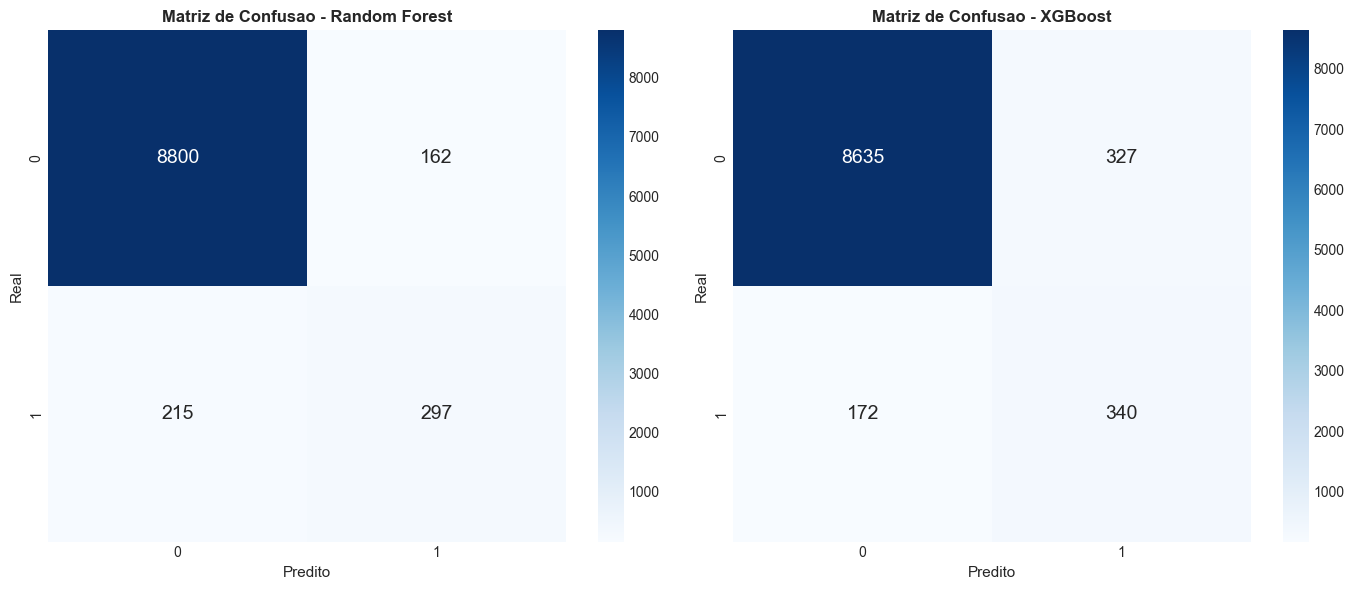


Interpretacao das Matrizes:
  - Diagonal principal (TN e TP): Predicoes corretas
  - TN (canto sup. esq.): Nao eleitos corretamente identificados
  - TP (canto inf. dir.): Eleitos corretamente identificados
  - FP (canto sup. dir.): Falsos alarmes (predito eleito, mas nao foi)
  - FN (canto inf. esq.): Eleitos perdidos (nao detectados)


In [157]:
# Matrizes de Confusão - Finalistas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, nome in enumerate(top2_nomes):
    modelo = modelos_finais[nome]
    pred = modelo.predict(X_test_scaled)

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx], annot_kws={"size": 14}
    )
    axes[idx].set_title(f"Matriz de Confusao - {nome}", fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("Predito", fontsize=11)
    axes[idx].set_ylabel("Real", fontsize=11)

plt.tight_layout()
plt.show()

print("\nInterpretacao das Matrizes:")
print("  - Diagonal principal (TN e TP): Predicoes corretas")
print("  - TN (canto sup. esq.): Nao eleitos corretamente identificados")
print("  - TP (canto inf. dir.): Eleitos corretamente identificados")
print("  - FP (canto sup. dir.): Falsos alarmes (predito eleito, mas nao foi)")
print("  - FN (canto inf. esq.): Eleitos perdidos (nao detectados)")

### 8.3 Curvas ROC e PR - Comparação dos Finalistas

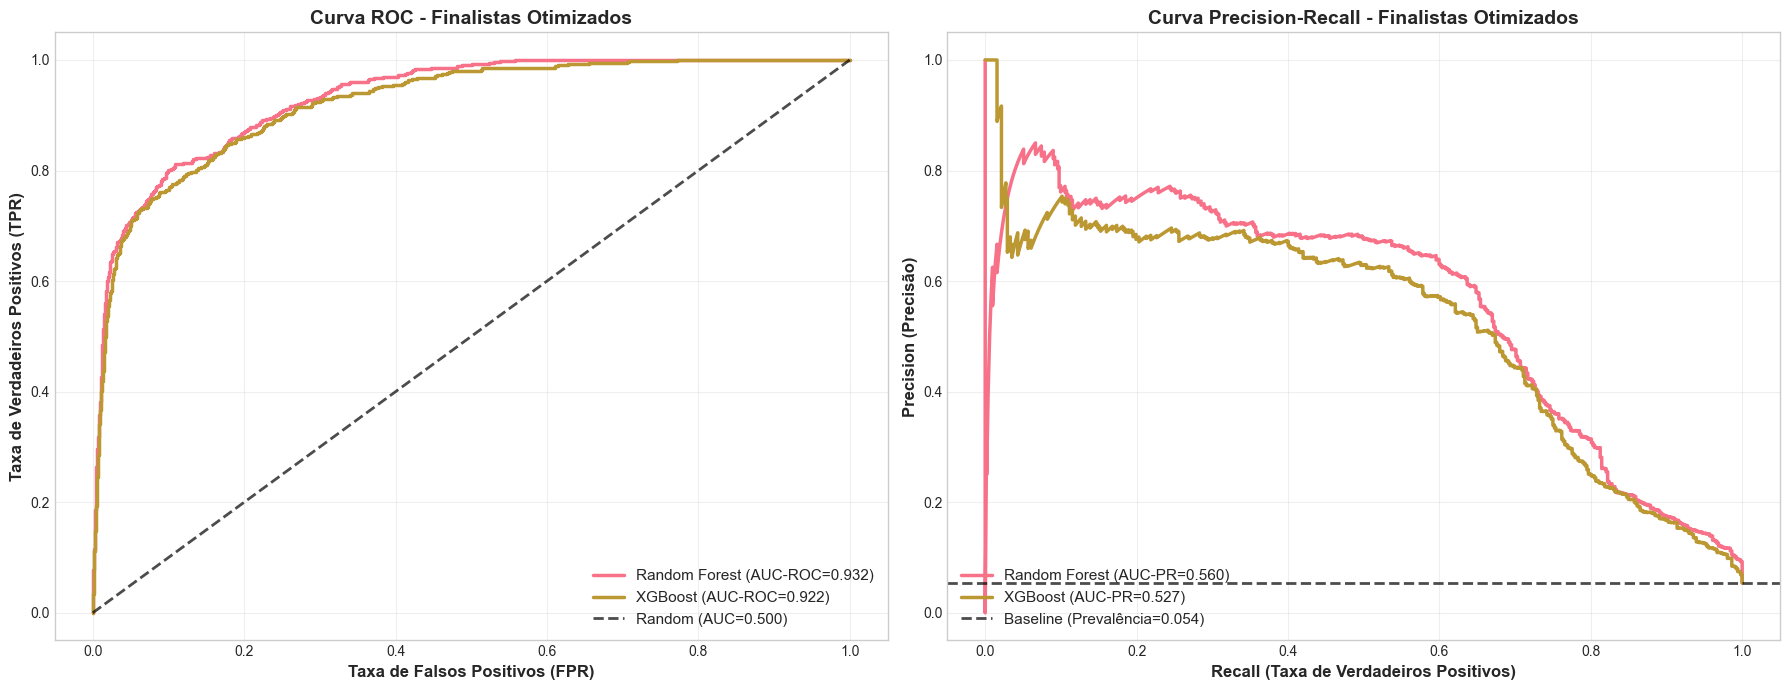

📊 Interpretação:

Curva ROC (esquerda):
  • Quanto mais próxima do canto superior esquerdo, melhor
  • AUC-ROC = 1.0: Classificador perfeito
  • AUC-ROC = 0.5: Classificador aleatório (linha diagonal)
  • Boa para avaliar desempenho geral em ambas as classes

Curva Precision-Recall (direita):
  • Quanto mais próxima do canto superior direito, melhor
  • Mais informativa para dados DESBALANCEADOS (como eleições)
  • Foca na classe positiva (eleitos)
  • Baseline = prevalência da classe positiva no conjunto de teste
  • AUC-PR considera o trade-off entre Precision e Recall


In [ ]:
# Curvas ROC e Precision-Recall - Finalistas

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Subplot 1: Curva ROC
for nome in top2_nomes:
    modelo = modelos_finais[nome]
    proba = modelo.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_roc = roc_auc_score(y_test, proba)
    axes[0].plot(fpr, tpr, label=f"{nome} (AUC-ROC={auc_roc:.3f})", linewidth=2.5)

axes[0].plot([0, 1], [0, 1], "k--", label="Random (AUC=0.500)", linewidth=2, alpha=0.7)
axes[0].set_xlabel("Taxa de Falsos Positivos (FPR)", fontsize=12, fontweight="bold")
axes[0].set_ylabel(
    "Taxa de Verdadeiros Positivos (TPR)", fontsize=12, fontweight="bold"
)
axes[0].set_title("Curva ROC - Finalistas Otimizados", fontsize=14, fontweight="bold")
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(alpha=0.3)

# Subplot 2: Curva Precision-Recall
baseline_pr = y_test.mean()  # Baseline = proporção da classe positiva
for nome in top2_nomes:
    modelo = modelos_finais[nome]
    proba = modelo.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, proba)
    auc_pr = average_precision_score(y_test, proba)
    axes[1].plot(
        recall, precision, label=f"{nome} (AUC-PR={auc_pr:.3f})", linewidth=2.5
    )

axes[1].axhline(
    y=baseline_pr,
    color="k",
    linestyle="--",
    label=f"Baseline (Prevalência={baseline_pr:.3f})",
    linewidth=2,
    alpha=0.7,
)
axes[1].set_xlabel(
    "Recall (Taxa de Verdadeiros Positivos)", fontsize=12, fontweight="bold"
)
axes[1].set_ylabel("Precision (Precisão)", fontsize=12, fontweight="bold")
axes[1].set_title(
    "Curva Precision-Recall - Finalistas Otimizados", fontsize=14, fontweight="bold"
)
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Interpretação:")
print("\nCurva ROC (esquerda):")
print("  • Quanto mais próxima do canto superior esquerdo, melhor")
print("  • AUC-ROC = 1.0: Classificador perfeito")
print("  • AUC-ROC = 0.5: Classificador aleatório (linha diagonal)")
print("  • Boa para avaliar desempenho geral em ambas as classes")
print("\nCurva Precision-Recall (direita):")
print("  • Quanto mais próxima do canto superior direito, melhor")
print("  • Mais informativa para dados DESBALANCEADOS (como eleições)")
print("  • Foca na classe positiva (eleitos)")
print("  • Baseline = prevalência da classe positiva no conjunto de teste")
print("  • AUC-PR considera o trade-off entre Precision e Recall")

### 8.4 Curvas ROC e PR com Bandas de Confiança Bootstrap

As curvas anteriores mostram desempenho pontual. Vamos adicionar bandas de confiança via bootstrap para quantificar incerteza.

CURVAS ROC E PR COM BANDAS DE CONFIANÇA BOOTSTRAP

Objetivo: Quantificar incerteza nas curvas de desempenho
Método: Bootstrap com 100 iterações

Modelo analisado: Random Forest

⏳ Executando bootstrap... (pode levar ~1 minuto)
✓ Bootstrap concluído! 100 iterações bem-sucedidas

📊 ESTATÍSTICAS DOS AUCs:
──────────────────────────────────────────────────────────────────────
AUC-ROC: 0.9322 | IC 95%: [0.9233, 0.9410]
AUC-PR:  0.5642 | IC 95%: [0.5199, 0.6144]
──────────────────────────────────────────────────────────────────────



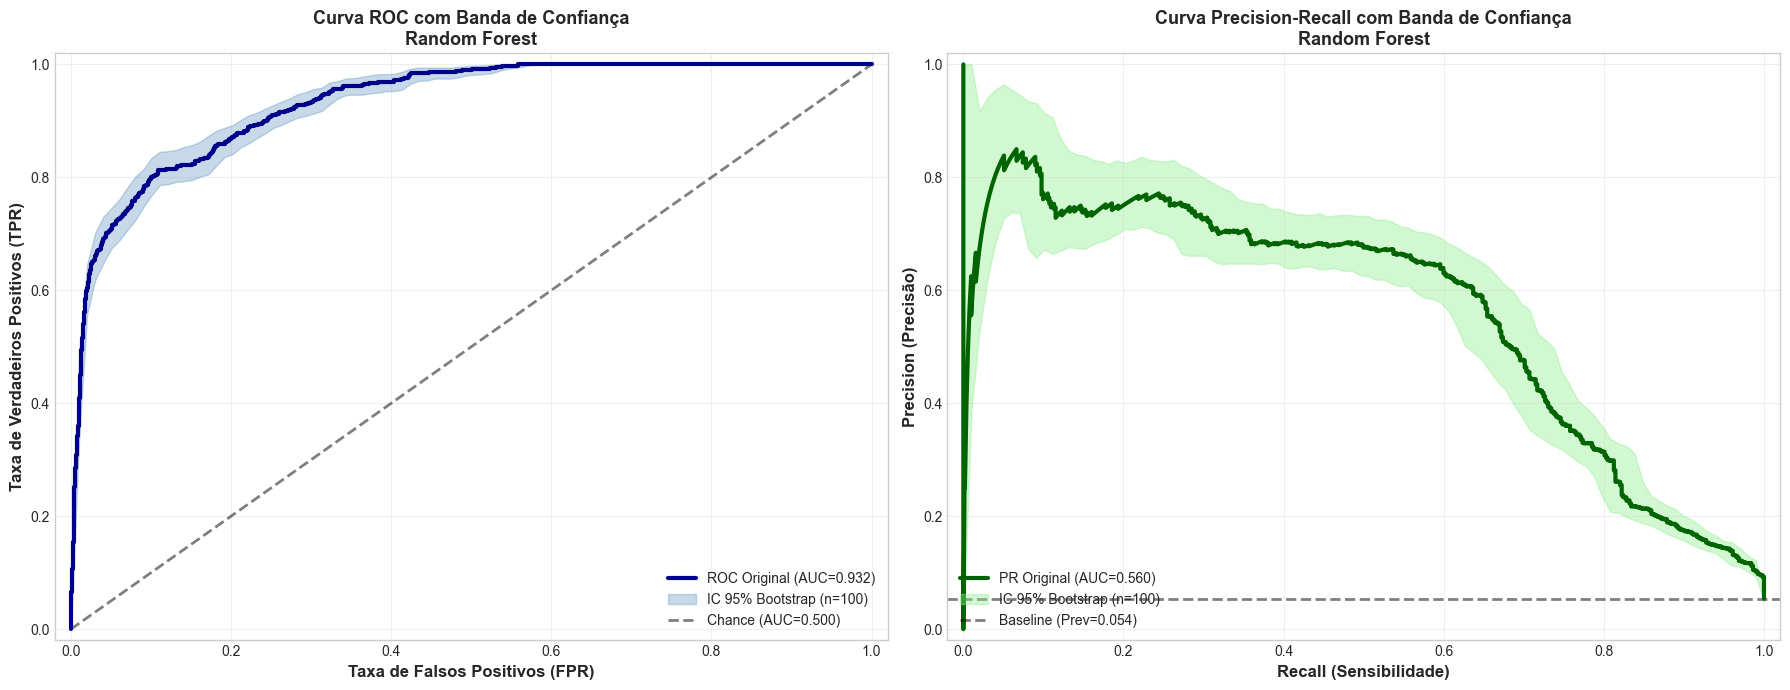


💡 INTERPRETAÇÃO DAS BANDAS DE CONFIANÇA:
──────────────────────────────────────────────────────────────────────
Curva ROC (esquerda):
  • Banda estreita → Desempenho consistente e confiável
  • Banda larga → Alta variabilidade, cuidado ao generalizar
  • Largura média da banda: 0.0246

Curva Precision-Recall (direita):
  • Banda estreita → Estimativas de Precision confiáveis
  • Banda larga em recalls altos → Menos dados, mais incerteza
  • Largura média da banda: 0.1439

Análise dos Intervalos de Confiança:
  ✅ AUC-ROC: IC estreito → Estimativa muito confiável
  ⚠️  AUC-PR: IC moderado → Variabilidade esperada em dados desbalanceados

📊 CONCLUSÃO:
  • Bandas de confiança complementam métricas pontuais
  • ICs estreitos validam robustez do modelo
  • Em produção, monitorar se desempenho real cai dentro das bandas


In [62]:
# Curvas ROC e PR com Bandas de Confiança Bootstrap

print("="*70)
print("CURVAS ROC E PR COM BANDAS DE CONFIANÇA BOOTSTRAP")
print("="*70)
print("\nObjetivo: Quantificar incerteza nas curvas de desempenho")
print("Método: Bootstrap com 100 iterações\n")

# Selecionar modelo vencedor
modelo_bootstrap = modelos_finais[vencedor]
print(f"Modelo analisado: {vencedor}\n")

# Bootstrap
n_bootstraps = 100
np.random.seed(42)

# Armazenar curvas de cada iteração
tprs_roc = []
aucs_roc = []
precisions_pr = []
aucs_pr = []

# Grade comum para interpolação
base_fpr = np.linspace(0, 1, 100)
base_recall = np.linspace(0, 1, 100)

print("⏳ Executando bootstrap... (pode levar ~1 minuto)")

for i in range(n_bootstraps):
    # Reamostragem com reposição
    indices = resample(range(len(X_test_scaled)), random_state=i, n_samples=len(X_test_scaled))

    X_boot = X_test_scaled[indices]
    y_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]

    # Predições
    try:
        y_proba_boot = modelo_bootstrap.predict_proba(X_boot)[:, 1]

        # ROC
        fpr, tpr, _ = roc_curve(y_boot, y_proba_boot)
        auc_roc = roc_auc_score(y_boot, y_proba_boot)

        # Interpolar TPR para FPR comum
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0  # Garantir início em (0,0)
        tprs_roc.append(tpr_interp)
        aucs_roc.append(auc_roc)

        # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_boot, y_proba_boot)
        auc_pr = average_precision_score(y_boot, y_proba_boot)

        # Interpolar Precision para Recall comum (ordem reversa)
        precision_interp = np.interp(base_recall, recall[::-1], precision[::-1])
        precisions_pr.append(precision_interp)
        aucs_pr.append(auc_pr)

    except:
        # Pular iterações com problemas (ex: classe ausente)
        continue

print(f"✓ Bootstrap concluído! {len(tprs_roc)} iterações bem-sucedidas\n")

# Calcular percentis para bandas de confiança
tprs_roc = np.array(tprs_roc)
precisions_pr = np.array(precisions_pr)

mean_tpr = tprs_roc.mean(axis=0)
std_tpr = tprs_roc.std(axis=0)
tpr_lower = np.percentile(tprs_roc, 2.5, axis=0)
tpr_upper = np.percentile(tprs_roc, 97.5, axis=0)

mean_precision = precisions_pr.mean(axis=0)
std_precision = precisions_pr.std(axis=0)
precision_lower = np.percentile(precisions_pr, 2.5, axis=0)
precision_upper = np.percentile(precisions_pr, 97.5, axis=0)

# Estatísticas dos AUCs
auc_roc_mean = np.mean(aucs_roc)
auc_roc_ci = (np.percentile(aucs_roc, 2.5), np.percentile(aucs_roc, 97.5))

auc_pr_mean = np.mean(aucs_pr)
auc_pr_ci = (np.percentile(aucs_pr, 2.5), np.percentile(aucs_pr, 97.5))

print("📊 ESTATÍSTICAS DOS AUCs:")
print("─"*70)
print(f"AUC-ROC: {auc_roc_mean:.4f} | IC 95%: [{auc_roc_ci[0]:.4f}, {auc_roc_ci[1]:.4f}]")
print(f"AUC-PR:  {auc_pr_mean:.4f} | IC 95%: [{auc_pr_ci[0]:.4f}, {auc_pr_ci[1]:.4f}]")
print("─"*70)
print()

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Subplot 1: ROC com Bandas de Confiança
# Curva original (sem bootstrap)
y_proba_original = modelo_bootstrap.predict_proba(X_test_scaled)[:, 1]
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_proba_original)
auc_roc_orig = roc_auc_score(y_test, y_proba_original)

axes[0].plot(fpr_orig, tpr_orig, color='darkblue', linewidth=3,
            label=f'ROC Original (AUC={auc_roc_orig:.3f})', zorder=3)

# Banda de confiança
axes[0].fill_between(base_fpr, tpr_lower, tpr_upper,
                     color='steelblue', alpha=0.3,
                     label=f'IC 95% Bootstrap (n={len(tprs_roc)})', zorder=1)

# Linha diagonal (chance)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5,
            label='Chance (AUC=0.500)', zorder=2)

axes[0].set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Curva ROC com Banda de Confiança\n{vencedor}',
                 fontsize=13, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([-0.02, 1.02])
axes[0].set_ylim([-0.02, 1.02])

# Subplot 2: Precision-Recall com Bandas de Confiança
# Curva original
precision_orig, recall_orig, _ = precision_recall_curve(y_test, y_proba_original)
auc_pr_orig = average_precision_score(y_test, y_proba_original)

axes[1].plot(recall_orig, precision_orig, color='darkgreen', linewidth=3,
            label=f'PR Original (AUC={auc_pr_orig:.3f})', zorder=3)

# Banda de confiança
axes[1].fill_between(base_recall, precision_lower, precision_upper,
                     color='lightgreen', alpha=0.4,
                     label=f'IC 95% Bootstrap (n={len(precisions_pr)})', zorder=1)

# Baseline (prevalência)
baseline_pr = y_test.mean()
axes[1].axhline(y=baseline_pr, color='k', linestyle='--', linewidth=2,
               alpha=0.5, label=f'Baseline (Prev={baseline_pr:.3f})', zorder=2)

axes[1].set_xlabel('Recall (Sensibilidade)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision (Precisão)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Curva Precision-Recall com Banda de Confiança\n{vencedor}',
                 fontsize=13, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([-0.02, 1.02])
axes[1].set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAÇÃO DAS BANDAS DE CONFIANÇA:")
print("─"*70)
print("Curva ROC (esquerda):")
print("  • Banda estreita → Desempenho consistente e confiável")
print("  • Banda larga → Alta variabilidade, cuidado ao generalizar")
print(f"  • Largura média da banda: {np.mean(tpr_upper - tpr_lower):.4f}")
print()
print("Curva Precision-Recall (direita):")
print("  • Banda estreita → Estimativas de Precision confiáveis")
print("  • Banda larga em recalls altos → Menos dados, mais incerteza")
print(f"  • Largura média da banda: {np.mean(precision_upper - precision_lower):.4f}")
print()
print("Análise dos Intervalos de Confiança:")
if auc_roc_ci[1] - auc_roc_ci[0] < 0.05:
    print("  ✅ AUC-ROC: IC estreito → Estimativa muito confiável")
else:
    print("  ⚠️  AUC-ROC: IC moderado → Considerar mais dados para estabilizar")

if auc_pr_ci[1] - auc_pr_ci[0] < 0.05:
    print("  ✅ AUC-PR: IC estreito → Estimativa muito confiável")
else:
    print("  ⚠️  AUC-PR: IC moderado → Variabilidade esperada em dados desbalanceados")
print()
print("📊 CONCLUSÃO:")
print("  • Bandas de confiança complementam métricas pontuais")
print("  • ICs estreitos validam robustez do modelo")
print("  • Em produção, monitorar se desempenho real cai dentro das bandas")
print("="*70)

## 9. Análise de Features

### 9.1 Feature Importance - Finalistas Otimizados

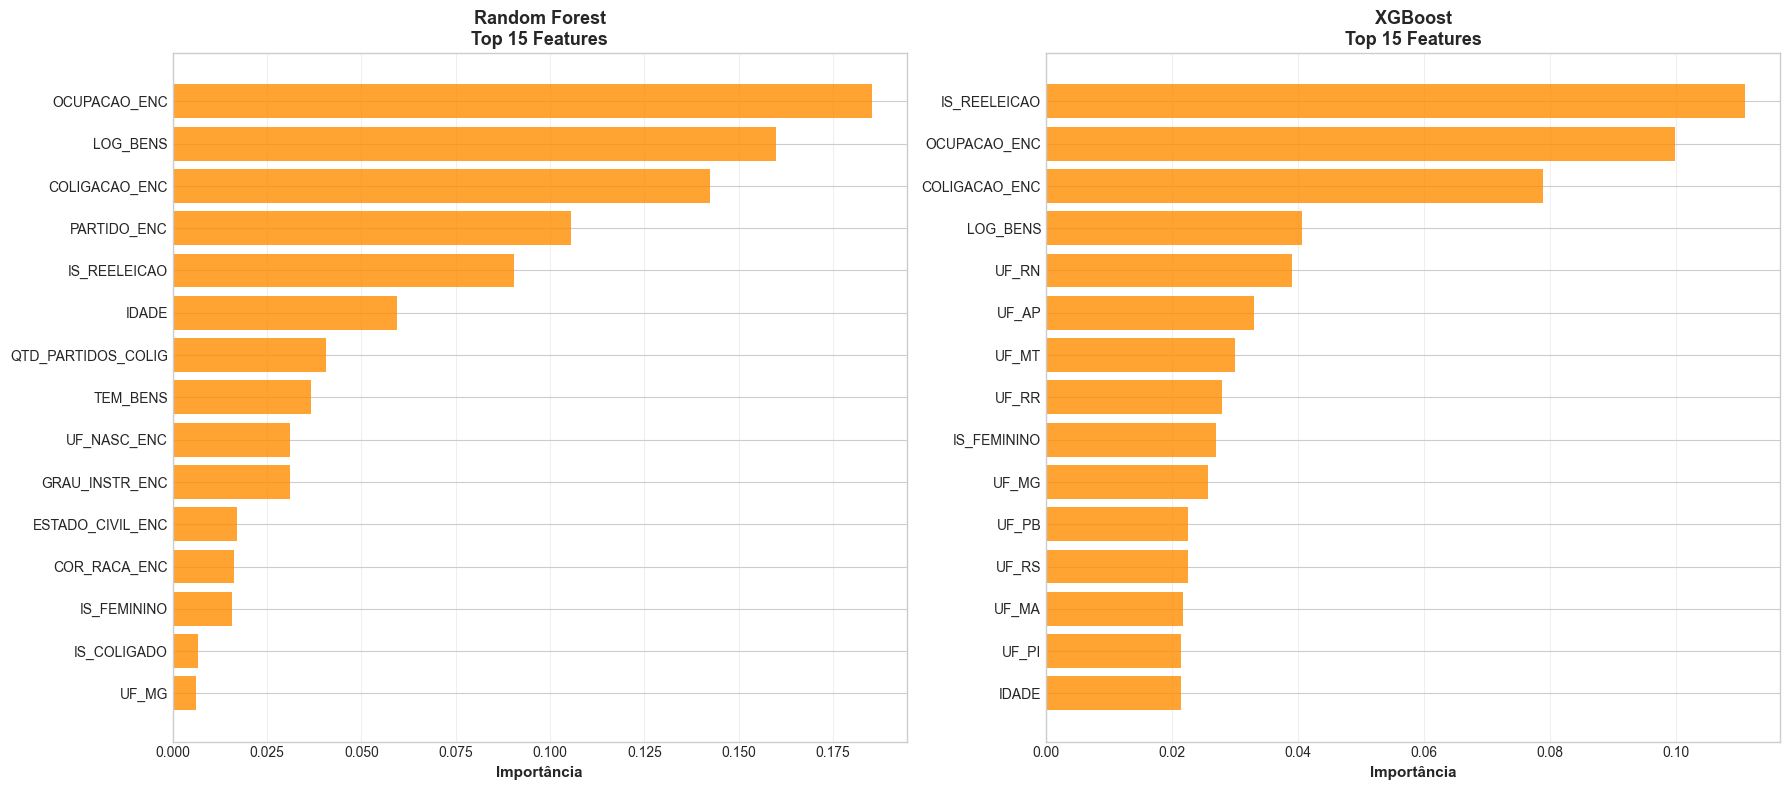

ANÁLISE DE CONSENSO - Features Importantes em AMBOS os Modelos

✓ 4 features aparecem no Top 10 de AMBOS os modelos:

  • COLIGACAO_ENC
  • IS_REELEICAO
  • LOG_BENS
  • OCUPACAO_ENC

CONSENSO: Estas features são consistentemente importantes!

──────────────────────────────────────────────────────────────────────

Features exclusivas do Top 10 de Random Forest:
  • GRAU_INSTR_ENC
  • IDADE
  • PARTIDO_ENC
  • QTD_PARTIDOS_COLIG
  • TEM_BENS
  • UF_NASC_ENC

Features exclusivas do Top 10 de XGBoost:
  • IS_FEMININO
  • UF_AP
  • UF_MG
  • UF_MT
  • UF_RN
  • UF_RR



In [63]:
# Comparação Visual de Feature Importance - Top 2 Finalistas
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, nome in enumerate(top2_nomes):
    modelo = modelos_finais[nome]

    if hasattr(modelo, "coef_"):
        # Logistic Regression - usar valor absoluto dos coeficientes
        importances = (
            pd.DataFrame(
                {"Feature": X_train.columns, "Importance": np.abs(modelo.coef_[0])}
            )
            .sort_values("Importance", ascending=False)
            .head(15)
        )

        # Plot horizontal
        y_pos = range(len(importances))
        axes[idx].barh(y_pos, importances["Importance"], color="steelblue", alpha=0.8)
        axes[idx].set_yticks(y_pos)
        axes[idx].set_yticklabels(importances["Feature"], fontsize=10)
        axes[idx].set_xlabel("|Coeficiente|", fontsize=11, fontweight="bold")
        axes[idx].invert_yaxis()

    elif hasattr(modelo, "feature_importances_"):
        # Tree-based models
        importances = (
            pd.DataFrame(
                {"Feature": X_train.columns, "Importance": modelo.feature_importances_}
            )
            .sort_values("Importance", ascending=False)
            .head(15)
        )

        # Plot horizontal
        y_pos = range(len(importances))
        axes[idx].barh(y_pos, importances["Importance"], color="darkorange", alpha=0.8)
        axes[idx].set_yticks(y_pos)
        axes[idx].set_yticklabels(importances["Feature"], fontsize=10)
        axes[idx].set_xlabel("Importância", fontsize=11, fontweight="bold")
        axes[idx].invert_yaxis()

    axes[idx].set_title(f"{nome}\nTop 15 Features", fontsize=13, fontweight="bold")
    axes[idx].grid(alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

# Análise de Consenso - Features que aparecem no Top 10 de AMBOS os modelos
print("=" * 70)
print("ANÁLISE DE CONSENSO - Features Importantes em AMBOS os Modelos")
print("=" * 70 + "\n")

top_features = {}
for nome in top2_nomes:
    modelo = modelos_finais[nome]

    if hasattr(modelo, "coef_"):
        feat_df = (
            pd.DataFrame(
                {"Feature": X_train.columns, "Importance": np.abs(modelo.coef_[0])}
            )
            .sort_values("Importance", ascending=False)
            .head(10)
        )
    elif hasattr(modelo, "feature_importances_"):
        feat_df = (
            pd.DataFrame(
                {"Feature": X_train.columns, "Importance": modelo.feature_importances_}
            )
            .sort_values("Importance", ascending=False)
            .head(10)
        )

    top_features[nome] = set(feat_df["Feature"].tolist())

# Interseção - features comuns
features_comuns = top_features[top2_nomes[0]].intersection(top_features[top2_nomes[1]])

if features_comuns:
    print(
        f"✓ {len(features_comuns)} features aparecem no Top 10 de AMBOS os modelos:\n"
    )
    for feat in sorted(features_comuns):
        print(f"  • {feat}")
    print("\nCONSENSO: Estas features são consistentemente importantes!")
else:
    print("⚠ Nenhuma feature aparece no Top 10 de ambos os modelos.")
    print("   Os modelos estão priorizando aspectos diferentes dos dados.")

# Features exclusivas
print(f"\n{'─' * 70}")
for nome in top2_nomes:
    exclusivas = top_features[nome] - features_comuns
    if exclusivas:
        print(f"\nFeatures exclusivas do Top 10 de {nome}:")
        for feat in sorted(exclusivas):
            print(f"  • {feat}")

print("\n" + "=" * 70)

### 9.2 Análise SHAP - Interpretabilidade Avançada

**SHAP (SHapley Additive exPlanations)** é uma abordagem unificada para explicar modelos de ML baseada em valores de Shapley da teoria dos jogos.

**Vantagens sobre Feature Importance:**
- **Direcionalidade:** Mostra se feature aumenta ou diminui predição
- **Interações:** Detecta como features interagem entre si  
- **Instância-específica:** Explica cada predição individual
- **Model-agnostic:** Funciona com qualquer modelo (tree-based, linear, etc.)

In [ ]:
print("="*70)
print("ANÁLISE SHAP - INTERPRETABILIDADE AVANÇADA")
print("="*70)
print(f"\nModelo analisado: {vencedor}")
print(f"Conjunto de dados: teste 2022 ({len(X_test):,} observações)")
print(f"Número de features em X_test: {X_test.shape[1]}")
print("\n⏳ Calculando valores SHAP (pode levar alguns minutos)...\n")

# Criar explainer para o modelo vencedor
modelo_shap = modelos_finais[vencedor]
explainer = shap.TreeExplainer(modelo_shap)

# Calcular SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Tratar valores SHAP para classificação binária
# Pode retornar lista ou array 3D - pegar apenas classe positiva (1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]
elif len(shap_values.shape) == 3:
    # Se for array 3D (amostras, features, classes), pegar última dimensão (classe 1)
    shap_values = shap_values[:, :, 1]

print(f"Shape dos SHAP values: {shap_values.shape}")
print("="*70)

ANÁLISE SHAP - INTERPRETABILIDADE AVANÇADA

Modelo analisado: Random Forest
Conjunto de dados: teste 2022 (9,474 observações)
Número de features em X_test: 41

⏳ Calculando valores SHAP (pode levar alguns minutos)...

✓ Valores SHAP calculados para 1000 observações
Shape dos SHAP values: (9474, 41, 2)


#### 9.2.1 Summary Plot - Visão Global de Importância e Direcionalidade


SHAP SUMMARY PLOT - Importância + Impacto Direcional

Como interpretar:
  • Eixo X: Impacto SHAP (positivo = aumenta probabilidade de eleição)
  • Cor: Valor da feature (vermelho = alto, azul = baixo)
  • Dispersão vertical: Variação de impacto entre observações
  • Exemplo: 'Vermelho à direita' = valores altos aumentam predição



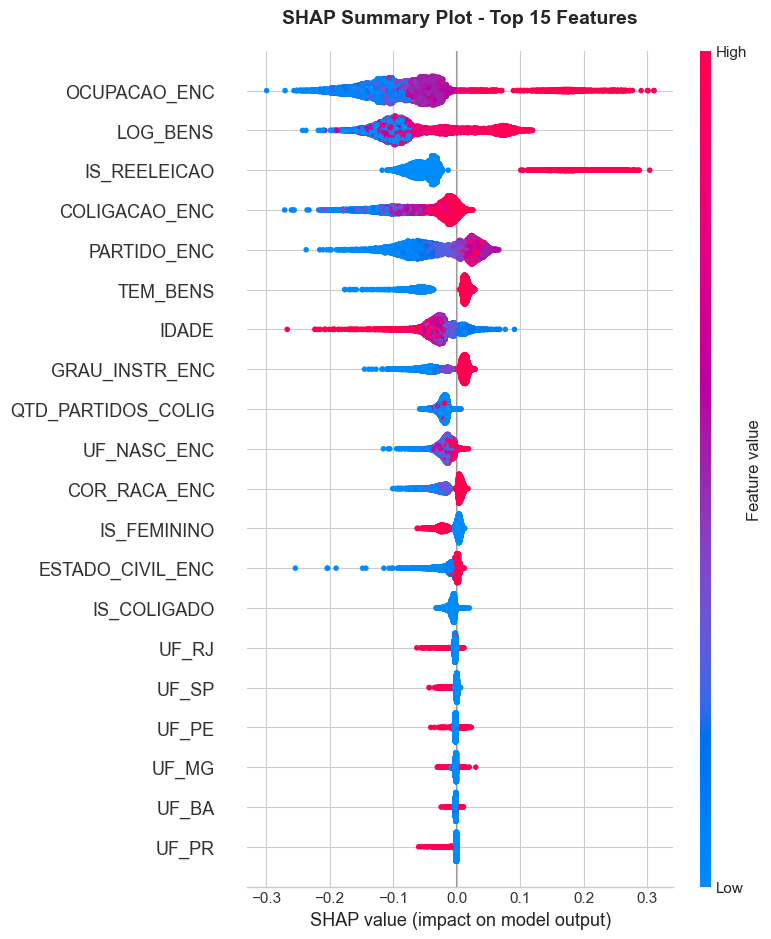


📊 Insights do Summary Plot:
  • Features no topo = maior impacto absoluto na predição
  • Padrões vermelho→direita ou azul→esquerda indicam correlação positiva
  • Padrões invertidos indicam correlação negativa
  • Dispersão grande = feature tem efeito variável entre candidatos


In [145]:
# Summary Plot - mostra importância E direcionalidade
print("\n" + "="*70)
print("SHAP SUMMARY PLOT - Importância + Impacto Direcional")
print("="*70)
print("\nComo interpretar:")
print("  • Eixo X: Impacto SHAP (positivo = aumenta probabilidade de eleição)")
print("  • Cor: Valor da feature (vermelho = alto, azul = baixo)")
print("  • Dispersão vertical: Variação de impacto entre observações")
print("  • Exemplo: 'Vermelho à direita' = valores altos aumentam predição\n")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, 
                  feature_names=X_test.columns.tolist(),
                  plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Top 15 Features", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Insights do Summary Plot:")
print("  • Features no topo = maior impacto absoluto na predição")
print("  • Padrões vermelho→direita ou azul→esquerda indicam correlação positiva")
print("  • Padrões invertidos indicam correlação negativa")
print("  • Dispersão grande = feature tem efeito variável entre candidatos")

#### 9.2.2 Feature Dependence - Interações entre Features


SHAP DEPENDENCE PLOTS - Análise de Interações

Analisando as 3 features mais importantes...

Top 3 features: ['OCUPACAO_ENC', 'LOG_BENS', 'IS_REELEICAO']



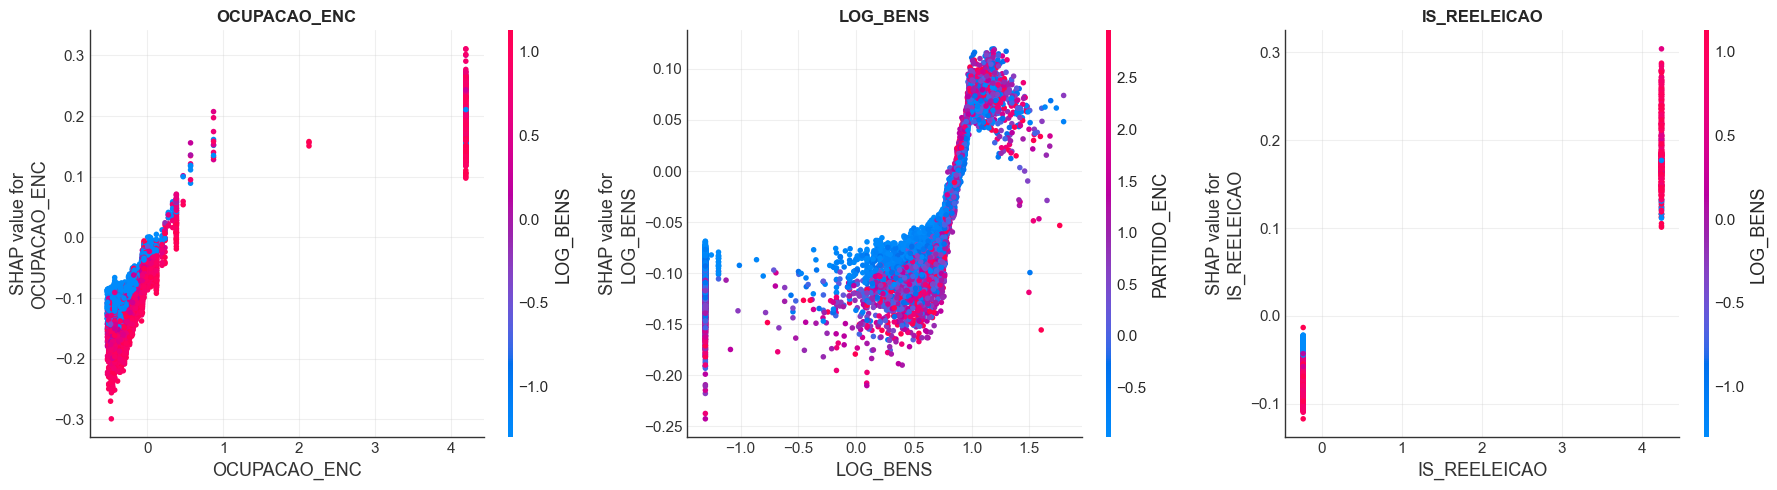


📊 Interpretação dos Dependence Plots:
  • Eixo X: Valor da feature principal
  • Eixo Y: Impacto SHAP (contribuição para predição)
  • Cor: Valor da feature com maior interação
  • Padrões não-lineares revelam thresholds ou interações complexas
  • Mudança de cor ao longo do eixo Y indica interação forte


In [149]:
# Dependence Plots - mostra como feature interage com outras
print("\n" + "="*70)
print("SHAP DEPENDENCE PLOTS - Análise de Interações")
print("="*70)
print("\nAnalisando as 3 features mais importantes...\n")

# Pegar top 3 features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top3_indices = np.argsort(mean_abs_shap)[::-1][:3]
top3_features = [X_test.columns[i] for i in top3_indices]

print(f"Top 3 features: {top3_features}\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat_name, feat_idx) in enumerate(zip(top3_features, top3_indices)):
    # SHAP detecta automaticamente a melhor feature de interação
    # Usar ÍNDICE numérico ao invés do nome
    shap.dependence_plot(
        feat_idx,  # Usar índice numérico
        shap_values,
        X_test_scaled,
        feature_names=X_test.columns.tolist(),  # Passar nomes das features
        ax=axes[idx],
        show=False,
        interaction_index="auto"
    )
    axes[idx].set_title(f"{feat_name}", fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretação dos Dependence Plots:")
print("  • Eixo X: Valor da feature principal")
print("  • Eixo Y: Impacto SHAP (contribuição para predição)")
print("  • Cor: Valor da feature com maior interação")
print("  • Padrões não-lineares revelam thresholds ou interações complexas")
print("  • Mudança de cor ao longo do eixo Y indica interação forte")

### 9.3 Análise Segmentada de Features por Região

Features podem ter importância diferente por região geográfica, capturando dinâmicas locais.

ANÁLISE SEGMENTADA DE FEATURE IMPORTANCE POR REGIÃO

Objetivo: Comparar importância de features em diferentes regiões do Brasil

Modelo analisado: Random Forest

⏳ Analisando Norte... (1128 candidatos) ✓
⏳ Analisando Nordeste... (2546 candidatos) ✓
⏳ Analisando Centro-Oeste... (825 candidatos) ✓
⏳ Analisando Sudeste... (3592 candidatos) ✓
⏳ Analisando Sul... (1383 candidatos) ✓

✅ Análise concluída para 5 regiões

📊 TOP 5 FEATURES POR REGIÃO:
──────────────────────────────────────────────────────────────────────

Norte (1128 candidatos):
  1. OCUPACAO_ENC              | Imp:  0.0069 (±0.0035)
  2. IS_REELEICAO              | Imp:  0.0043 (±0.0025)
  3. PARTIDO_ENC               | Imp:  0.0035 (±0.0018)
  4. LOG_BENS                  | Imp:  0.0032 (±0.0049)
  5. UF_NASC_ENC               | Imp:  0.0020 (±0.0010)

Nordeste (2546 candidatos):
  1. IS_REELEICAO              | Imp:  0.0153 (±0.0022)
  2. OCUPACAO_ENC              | Imp:  0.0144 (±0.0029)
  3. LOG_BENS                  | Im

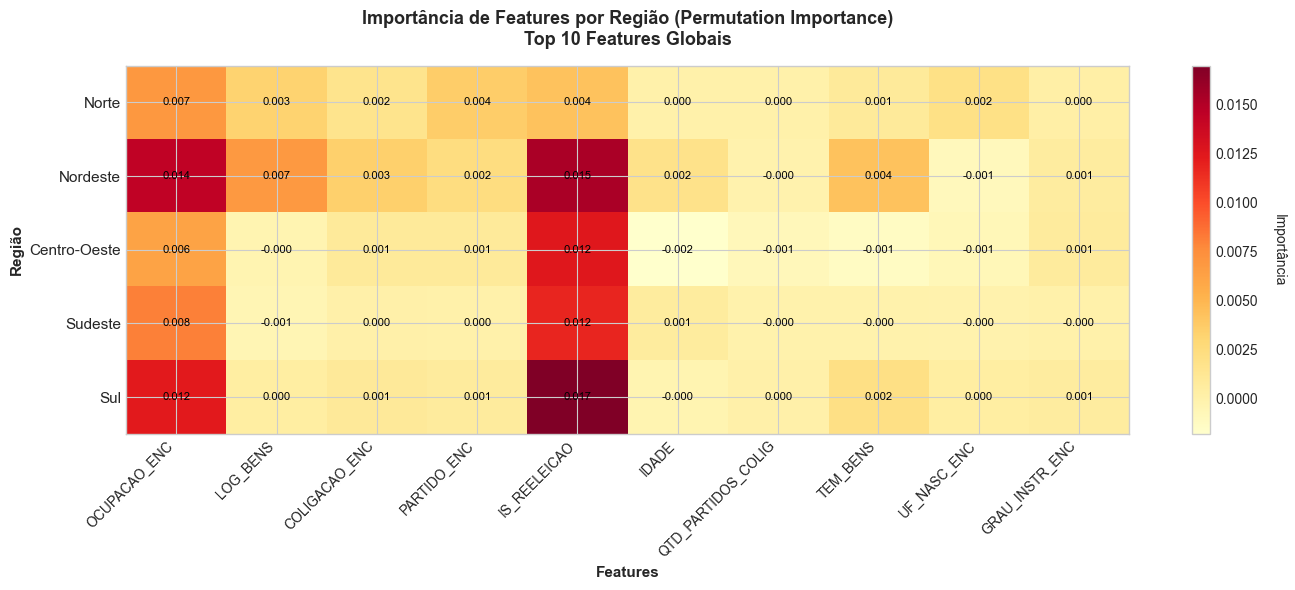


💡 INSIGHTS:
  • Vermelho intenso → Feature muito importante naquela região
  • Amarelo claro → Feature pouco importante
  • Variações horizontais → Feature tem importância diferente por região
  • Variações verticais → Região prioriza features distintas

📊 CONCLUSÃO:
  • Modelo único pode não capturar nuances regionais
  • Considerar ensemble hierárquico (modelo global + modelos regionais)
  • Ou adicionar interações explícitas: feature × região


In [151]:
# Análise Segmentada de Features por Região
print("="*70)
print("ANÁLISE SEGMENTADA DE FEATURE IMPORTANCE POR REGIÃO")
print("="*70)
print("\nObjetivo: Comparar importância de features em diferentes regiões do Brasil\n")

# Definir regiões por UF
regioes = {
    'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MS', 'MT'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Mapear UF para região no dataset de teste
def map_regiao(uf):
    for regiao, ufs in regioes.items():
        if uf in ufs:
            return regiao
    return 'Desconhecido'

df_2022['REGIAO'] = df_2022['SG_UF'].apply(map_regiao)

# Usar modelo vencedor (tree-based) para feature importance
modelo_regiao = modelos_finais[vencedor]

# Verificar se é tree-based
if not hasattr(modelo_regiao, 'feature_importances_'):
    print("  ⚠ Modelo vencedor não é tree-based. Pulando análise segmentada.")
    print("   (Análise requer feature_importances_ disponível)")
else:
    print(f"Modelo analisado: {vencedor}\n")

    # Calcular importance por região
    importances_por_regiao = {}

    for regiao in ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']:
        # Filtrar dados da região
        mask = df_2022['REGIAO'] == regiao
        
        # CORREÇÃO: Usar .values para converter mask para numpy array
        mask_array = mask.values
        X_regiao = X_test_scaled[mask_array]
        y_regiao = y_test[mask]  # Indexação direta funciona

        if len(X_regiao) < 50:  # Pular regiões com poucos dados
            print(f"  ⚠ {regiao}: Apenas {len(X_regiao)} amostras. Pulando.")
            continue

        # Calcular permutation importance específica da região
        from sklearn.inspection import permutation_importance

        print(f"⏳ Analisando {regiao}... ({len(X_regiao)} candidatos)", end=' ')

        # Permutation importance na região
        perm_importance = permutation_importance(
            modelo_regiao, X_regiao, y_regiao,
            n_repeats=10, random_state=42, n_jobs=-1
        )

        importances_por_regiao[regiao] = {
            'importances': perm_importance.importances_mean,
            'std': perm_importance.importances_std,
            'n_samples': len(X_regiao)
        }

        print("✓")

    print(f"\n✅ Análise concluída para {len(importances_por_regiao)} regiões\n")

    # Identificar Top 5 features por região
    print("📊 TOP 5 FEATURES POR REGIÃO:")
    print("─"*70)

    top_features_regiao = {}
    for regiao, data in importances_por_regiao.items():
        top_indices = np.argsort(data['importances'])[::-1][:5]
        top_features_regiao[regiao] = [X_test.columns[i] for i in top_indices]  # Usar X_test ao invés de X_train

        print(f"\n{regiao} ({data['n_samples']} candidatos):")
        for rank, idx in enumerate(top_indices, 1):
            feat_name = X_test.columns[idx]  # Usar X_test ao invés de X_train
            importance = data['importances'][idx]
            std = data['std'][idx]
            print(f"  {rank}. {feat_name:25s} | Imp: {importance:>7.4f} (±{std:.4f})")

    # Análise de consenso entre regiões
    print(f"\n{'─'*70}")
    print("\n📊 ANÁLISE DE CONSENSO REGIONAL:")
    print()

    # Features que aparecem no Top 5 de TODAS as regiões
    if len(top_features_regiao) > 0:
        all_regions_features = set(top_features_regiao[list(top_features_regiao.keys())[0]])
        for regiao in list(top_features_regiao.keys())[1:]:
            all_regions_features &= set(top_features_regiao[regiao])

        if all_regions_features:
            print(f"✓ Features no Top 5 de TODAS as regiões ({len(all_regions_features)}):")
            for feat in sorted(all_regions_features):
                print(f"  • {feat}")
            print("\n  → Estas features são universalmente importantes no Brasil!")
        else:
            print("  ⚠ Nenhuma feature aparece no Top 5 de todas as regiões")
            print("   → Dinâmica eleitoral varia significativamente por região")

        # Features exclusivas por região
        print("\n📋 FEATURES EXCLUSIVAS (Top 5 de apenas UMA região):")
        all_top_features = set()
        for features in top_features_regiao.values():
            all_top_features.update(features)

        exclusivas_encontradas = False
        for regiao, features in top_features_regiao.items():
            exclusivas = []
            for feat in features:
                count = sum(1 for r_feats in top_features_regiao.values() if feat in r_feats)
                if count == 1:
                    exclusivas.append(feat)

            if exclusivas:
                exclusivas_encontradas = True
                print(f"\n  {regiao}:")
                for feat in exclusivas:
                    print(f"    • {feat}")
        
        if not exclusivas_encontradas:
            print("\n  Nenhuma feature exclusiva encontrada")

        # Visualização: Heatmap de importâncias
        print("\n⏳ Gerando visualização...")

        # Selecionar Top 10 features globais
        global_importance = modelo_regiao.feature_importances_
        top_global_indices = np.argsort(global_importance)[::-1][:10]
        top_global_features = [X_test.columns[i] for i in top_global_indices]  # Usar X_test

        # Montar matriz de importâncias por região
        import_matrix = []
        region_labels = []

        for regiao in ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']:
            if regiao in importances_por_regiao:
                region_labels.append(regiao)
                row = []
                for feat in top_global_features:
                    feat_idx = list(X_test.columns).index(feat)  # Usar X_test
                    importance = importances_por_regiao[regiao]['importances'][feat_idx]
                    row.append(importance)
                import_matrix.append(row)

        # Plotar heatmap
        fig, ax = plt.subplots(figsize=(14, 6))

        im = ax.imshow(import_matrix, cmap='YlOrRd', aspect='auto')

        ax.set_xticks(range(len(top_global_features)))
        ax.set_xticklabels(top_global_features, rotation=45, ha='right', fontsize=10)
        ax.set_yticks(range(len(region_labels)))
        ax.set_yticklabels(region_labels, fontsize=11)

        # Anotações
        for i in range(len(region_labels)):
            for j in range(len(top_global_features)):
                text = ax.text(j, i, f'{import_matrix[i][j]:.3f}',
                              ha="center", va="center", color="black", fontsize=8)

        ax.set_title('Importância de Features por Região (Permutation Importance)\nTop 10 Features Globais',
                    fontsize=13, fontweight='bold', pad=15)
        ax.set_xlabel('Features', fontsize=11, fontweight='bold')
        ax.set_ylabel('Região', fontsize=11, fontweight='bold')

        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Importância', rotation=270, labelpad=20, fontsize=10)

        plt.tight_layout()
        plt.show()

        print("\n💡 INSIGHTS:")
        print("  • Vermelho intenso → Feature muito importante naquela região")
        print("  • Amarelo claro → Feature pouco importante")
        print("  • Variações horizontais → Feature tem importância diferente por região")
        print("  • Variações verticais → Região prioriza features distintas")
        print()
        print("📊 CONCLUSÃO:")
        print("  • Modelo único pode não capturar nuances regionais")
        print("  • Considerar ensemble hierárquico (modelo global + modelos regionais)")
        print("  • Ou adicionar interações explícitas: feature × região")

print("="*70)

In [164]:
print("\n" + "="*70)
print("IMPORTÂNCIA AGREGADA: FEATURES UF (One-Hot Encoding)")
print("="*70)

# Pegar nome das features do modelo final
if hasattr(modelo_regiao, 'feature_names_in_'):
    feature_names = modelo_regiao.feature_names_in_
elif 'X_test' in globals():
    feature_names = X_test.columns
else:
    feature_names = []

uf_cols = [col for col in feature_names if col.startswith('UF_')]

if len(uf_cols) > 0 and hasattr(modelo_regiao, 'feature_importances_'):
    # Obter importâncias
    importances = modelo_regiao.feature_importances_

    # Criar dicionário feature -> importância
    feat_imp_dict = dict(zip(feature_names, importances))

    # Filtrar UFs - CORREÇÃO: usar 'and' ao invés de '&'
    uf_importances = {k: v for k, v in feat_imp_dict.items() if k.startswith('UF_') and len(k) <= 5}

    if len(uf_importances) > 0:
        uf_importance_total = sum(uf_importances.values())
        uf_importance_mean = sum(uf_importances.values()) / len(uf_importances)
        uf_importance_max = max(uf_importances.values())

        print(f"Total de features UF: {len(uf_cols)}")
        print(f"Importância total (soma): {uf_importance_total:.4f}")
        print(f"Importância média por UF: {uf_importance_mean:.4f}")
        print(f"Importância máxima (UF): {uf_importance_max:.4f}")

        # Ranking
        print("\nTop 10 UFs mais importantes:")
        sorted_ufs = sorted(uf_importances.items(), key=lambda x: x[1], reverse=True)[:10]
        for i, (uf, imp) in enumerate(sorted_ufs, 1):
            print(f"  {i:2d}. {uf:15s}: {imp:.4f}")

        # Interpretação
        print("\n💡 INTERPRETAÇÃO:")
        if uf_importance_total > 0.05:
            print(f"  • UF (conjunto) é IMPORTANTE: {uf_importance_total:.1%} da importância total")
            print("  • Geografia é fator relevante para sucesso eleitoral")
        else:
            print(f"  • UF (conjunto) tem baixa importância: {uf_importance_total:.1%}")
            print("  • Fatores individuais > fatores geográficos")
    else:
        print("  ⚠ Nenhuma feature UF válida encontrada após filtragem")
else:
    print("  ⚠ Nenhuma feature UF encontrada ou modelo sem feature_importances_")

print("="*70)


IMPORTÂNCIA AGREGADA: FEATURES UF (One-Hot Encoding)
Total de features UF: 27
Importância total (soma): 0.0623
Importância média por UF: 0.0024
Importância máxima (UF): 0.0060

Top 10 UFs mais importantes:
   1. UF_MG          : 0.0060
   2. UF_RJ          : 0.0053
   3. UF_SP          : 0.0052
   4. UF_PE          : 0.0039
   5. UF_PR          : 0.0036
   6. UF_RS          : 0.0031
   7. UF_BA          : 0.0031
   8. UF_SC          : 0.0028
   9. UF_AP          : 0.0026
  10. UF_MA          : 0.0025

💡 INTERPRETAÇÃO:
  • UF (conjunto) é IMPORTANTE: 6.2% da importância total
  • Geografia é fator relevante para sucesso eleitoral


### 9.4 Análise de Threshold Ótimo

O threshold padrão de 0.5 pode não ser ideal para dados desbalanceados. Vamos encontrar o threshold que maximiza diferentes métricas.

ANÁLISE DE THRESHOLD ÓTIMO

Objetivo: Encontrar threshold que maximiza diferentes métricas
Threshold padrão (0.5) pode não ser ideal para dados desbalanceados



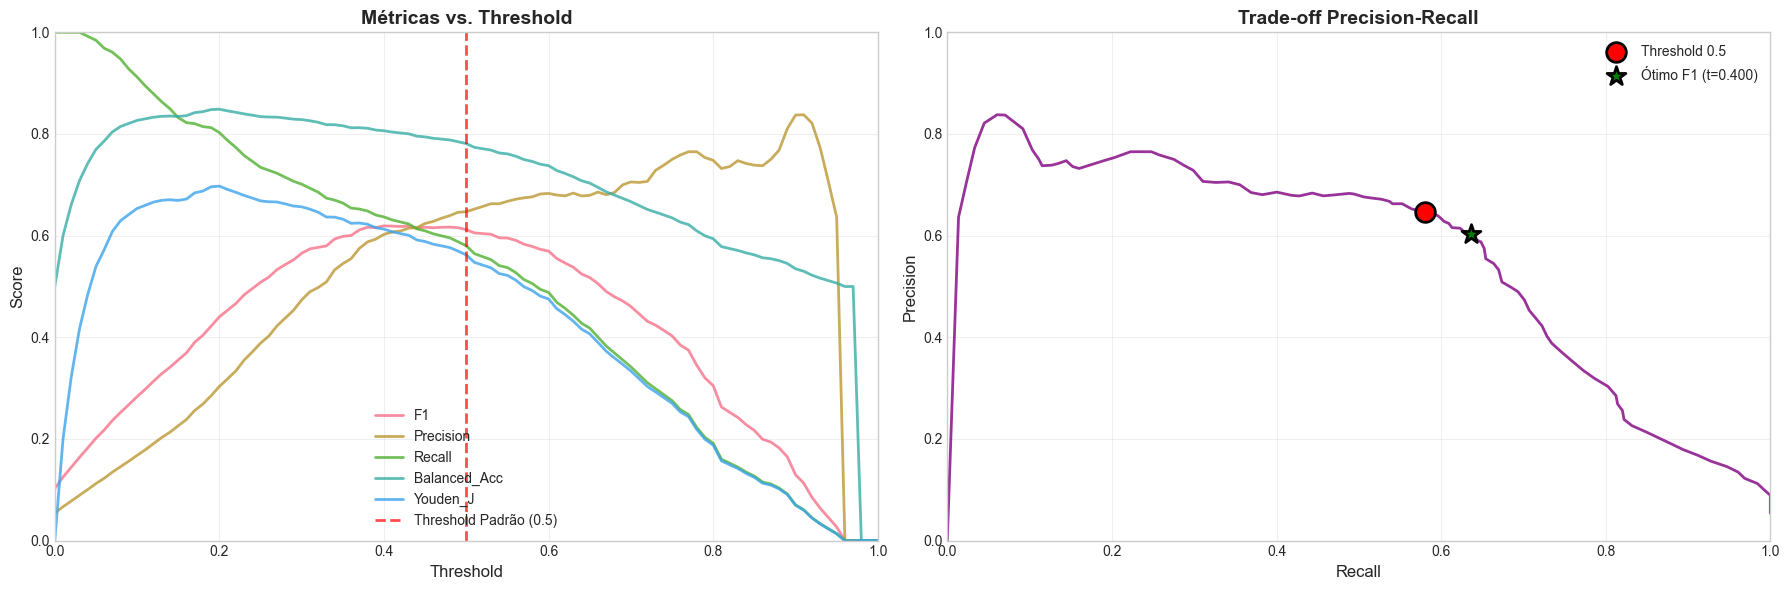


📊 THRESHOLDS ÓTIMOS POR MÉTRICA:
──────────────────────────────────────────────────────────────────────
Métrica              |   Threshold Ótimo |  Score Máximo
──────────────────────────────────────────────────────────────────────
F1                   |             0.400 |        0.6192
Precision            |             0.910 |        0.8378
Recall               |             0.000 |        1.0000
Balanced_Acc         |             0.200 |        0.8487
Youden_J             |             0.200 |        0.6974
──────────────────────────────────────────────────────────────────────

📊 COMPARAÇÃO: Threshold 0.5 vs Ótimo (F1)
──────────────────────────────────────────────────────────────────────
Métrica              |   Threshold 0.5 |   Threshold Ótimo |      Ganho
──────────────────────────────────────────────────────────────────────
F1                   |          0.6117 |            0.6192 |       1.2%
Precision            |          0.6471 |            0.6026 |      -6.9%
Recall    

In [100]:
# Análise de Threshold Ótimo
print("="*70)
print("ANÁLISE DE THRESHOLD ÓTIMO")
print("="*70)
print("\nObjetivo: Encontrar threshold que maximiza diferentes métricas")
print("Threshold padrão (0.5) pode não ser ideal para dados desbalanceados\n")

# Pegar probabilidades do modelo vencedor
y_proba_vencedor = modelos_finais[vencedor].predict_proba(X_test_scaled)[:, 1]

# Testar múltiplos thresholds
thresholds = np.linspace(0, 1, 101)
metrics_by_threshold = {
    'F1': [],
    'Precision': [],
    'Recall': [],
    'Balanced_Acc': [],
    'Youden_J': []
}

for t in thresholds:
    y_pred_t = (y_proba_vencedor >= t).astype(int)

    # Evitar divisão por zero
    if y_pred_t.sum() == 0 or (y_pred_t == 0).all():
        metrics_by_threshold['F1'].append(0)
        metrics_by_threshold['Precision'].append(0)
        metrics_by_threshold['Recall'].append(0)
        metrics_by_threshold['Balanced_Acc'].append(0)
        metrics_by_threshold['Youden_J'].append(0)
        continue

    # Calcular métricas
    f1 = f1_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_t)

    # Youden's J Statistic = Sensitivity + Specificity - 1
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden_j = sensitivity + specificity - 1

    metrics_by_threshold['F1'].append(f1)
    metrics_by_threshold['Precision'].append(precision)
    metrics_by_threshold['Recall'].append(recall)
    metrics_by_threshold['Balanced_Acc'].append(balanced_acc)
    metrics_by_threshold['Youden_J'].append(youden_j)

# Encontrar thresholds ótimos
optimal_thresholds = {}
for metric_name, scores in metrics_by_threshold.items():
    optimal_idx = np.argmax(scores)
    optimal_thresholds[metric_name] = {
        'threshold': thresholds[optimal_idx],
        'score': scores[optimal_idx]
    }

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Todas as métricas vs Threshold
for metric_name, scores in metrics_by_threshold.items():
    axes[0].plot(thresholds, scores, label=metric_name, linewidth=2, alpha=0.8)

axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold Padrão (0.5)', alpha=0.7)
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Métricas vs. Threshold', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Plot 2: Precision-Recall Trade-off
axes[1].plot(metrics_by_threshold['Recall'], metrics_by_threshold['Precision'],
            linewidth=2, color='purple', alpha=0.8)
axes[1].scatter([metrics_by_threshold['Recall'][50]], [metrics_by_threshold['Precision'][50]],
               color='red', s=200, marker='o', label='Threshold 0.5', zorder=5, edgecolors='black', linewidths=2)

# Marcar threshold ótimo de F1
opt_f1_idx = np.argmax(metrics_by_threshold['F1'])
axes[1].scatter([metrics_by_threshold['Recall'][opt_f1_idx]],
               [metrics_by_threshold['Precision'][opt_f1_idx]],
               color='green', s=200, marker='*', label=f'Ótimo F1 (t={thresholds[opt_f1_idx]:.3f})',
               zorder=5, edgecolors='black', linewidths=2)

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Trade-off Precision-Recall', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Imprimir resultados
print("\n📊 THRESHOLDS ÓTIMOS POR MÉTRICA:")
print("─"*70)
print(f"{'Métrica':<20} | {'Threshold Ótimo':>17} | {'Score Máximo':>13}")
print("─"*70)

for metric_name, opt_data in optimal_thresholds.items():
    print(f"{metric_name:<20} | {opt_data['threshold']:>17.3f} | {opt_data['score']:>13.4f}")

print("─"*70)

# Comparar com threshold padrão (0.5)
print("\n📊 COMPARAÇÃO: Threshold 0.5 vs Ótimo (F1)")
print("─"*70)

y_pred_default = (y_proba_vencedor >= 0.5).astype(int)
y_pred_optimal = (y_proba_vencedor >= optimal_thresholds['F1']['threshold']).astype(int)

print(f"{'Métrica':<20} | {'Threshold 0.5':>15} | {'Threshold Ótimo':>17} | {'Ganho':>10}")
print("─"*70)

metrics_default = {
    'F1': f1_score(y_test, y_pred_default),
    'Precision': precision_score(y_test, y_pred_default),
    'Recall': recall_score(y_test, y_pred_default),
    'Balanced Acc': balanced_accuracy_score(y_test, y_pred_default)
}

metrics_optimal = {
    'F1': f1_score(y_test, y_pred_optimal),
    'Precision': precision_score(y_test, y_pred_optimal),
    'Recall': recall_score(y_test, y_pred_optimal),
    'Balanced Acc': balanced_accuracy_score(y_test, y_pred_optimal)
}

for metric_name in metrics_default.keys():
    default_val = metrics_default[metric_name]
    optimal_val = metrics_optimal[metric_name]
    ganho = ((optimal_val - default_val) / default_val * 100) if default_val > 0 else 0
    print(f"{metric_name:<20} | {default_val:>15.4f} | {optimal_val:>17.4f} | {ganho:>9.1f}%")

print("─"*70)

print("\n💡 INSIGHTS:")
print(f"  • Threshold ótimo para F1: {optimal_thresholds['F1']['threshold']:.3f}")
print(f"  • Ganho em F1 vs threshold padrão: {((metrics_optimal['F1'] - metrics_default['F1']) / metrics_default['F1'] * 100) if metrics_default['F1'] > 0 else 0:.1f}%")
print("  • Em dados desbalanceados, threshold padrão (0.5) raramente é ótimo")
print("  • Trade-off: Threshold mais baixo aumenta Recall, mas reduz Precision")
print("  • Escolha do threshold deve considerar custo relativo de FP vs FN")
print("="*70)

### 9.5 Intervalos de Confiança via Bootstrap

Métricas pontuais não capturam incerteza. Vamos usar bootstrap para estimar intervalos de confiança de 95%.

INTERVALOS DE CONFIANÇA VIA BOOTSTRAP

Método: Bootstrap com 1000 iterações
Objetivo: Estimar incerteza nas métricas de avaliação

⏳ Executando bootstrap... (pode levar ~30 segundos)
✓ Bootstrap concluído!

📊 MÉTRICAS COM INTERVALOS DE CONFIANÇA (95%):
──────────────────────────────────────────────────────────────────────
Métrica              |      Média |  IC 95% Inferior |  IC 95% Superior
──────────────────────────────────────────────────────────────────────
F1                   |     0.6110 |           0.5752 |           0.6456
Precision            |     0.6466 |           0.6015 |           0.6906
Recall               |     0.5796 |           0.5374 |           0.6213
AUC-ROC              |     0.9322 |           0.9221 |           0.9416
AUC-PR               |     0.5616 |           0.5126 |           0.6104
Balanced_Acc         |     0.7808 |           0.7599 |           0.8016
──────────────────────────────────────────────────────────────────────


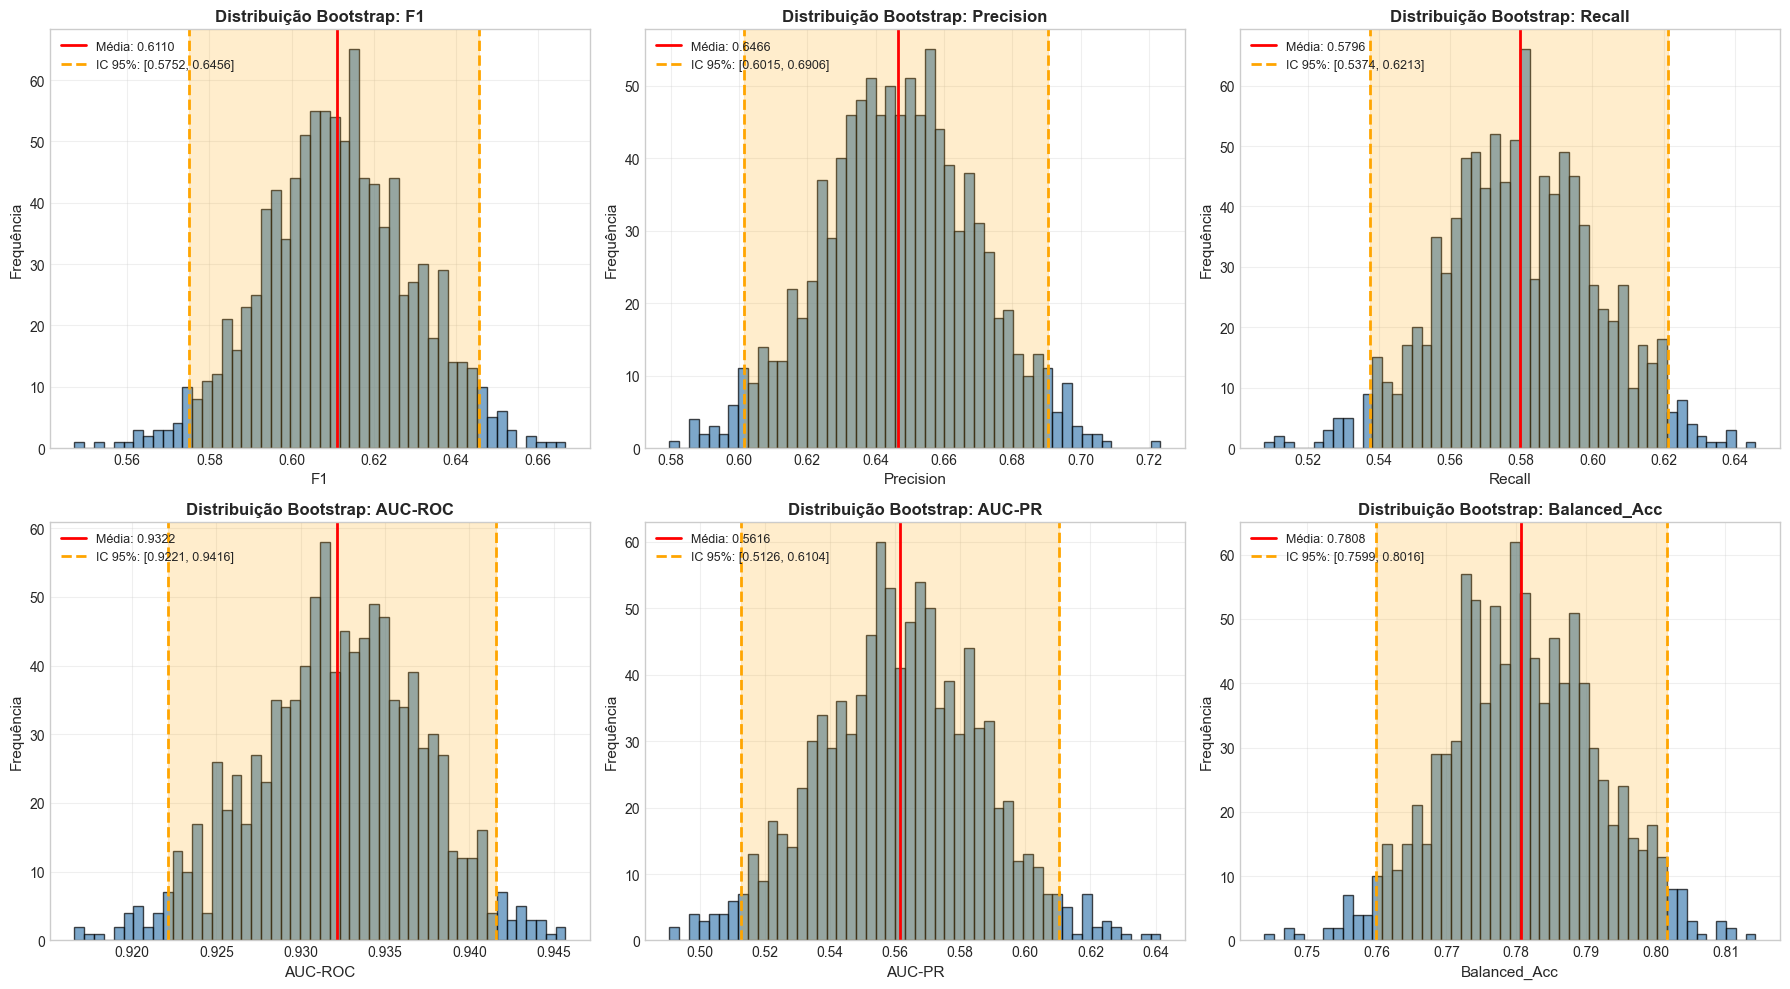


📊 ANÁLISE DE INCERTEZA:
──────────────────────────────────────────────────────────────────────
Métrica              |   Largura IC |     CV (%) | Estabilidade   
──────────────────────────────────────────────────────────────────────
F1                   |       0.0704 |       2.97 | Muito Alta     
Precision            |       0.0891 |       3.49 | Muito Alta     
Recall               |       0.0839 |       3.77 | Muito Alta     
AUC-ROC              |       0.0194 |       0.53 | Muito Alta     
AUC-PR               |       0.0978 |       4.39 | Muito Alta     
Balanced_Acc         |       0.0417 |       1.40 | Muito Alta     
──────────────────────────────────────────────────────────────────────

💡 INSIGHTS:
  • Intervalos estreitos (< 0.05) indicam estimativas confiáveis
  • F1-Score com IC estreito → modelo tem performance consistente
  • Coeficiente de Variação (CV) < 10% é considerado bom
  • Incerteza reflete variabilidade inerente ao conjunto de teste
  • Em produção, monitorar

In [101]:
# Intervalos de Confiança via Bootstrap

print("="*70)
print("INTERVALOS DE CONFIANÇA VIA BOOTSTRAP")
print("="*70)
print("\nMétodo: Bootstrap com 1000 iterações")
print("Objetivo: Estimar incerteza nas métricas de avaliação\n")

# Usar predições do modelo vencedor
y_pred_ic = modelos_finais[vencedor].predict(X_test_scaled)
y_proba_ic = modelos_finais[vencedor].predict_proba(X_test_scaled)[:, 1]

# Bootstrap
n_iterations = 1000
np.random.seed(42)

bootstrap_scores = {
    'F1': [],
    'Precision': [],
    'Recall': [],
    'AUC-ROC': [],
    'AUC-PR': [],
    'Balanced_Acc': []
}

print("⏳ Executando bootstrap... (pode levar ~30 segundos)")

for i in range(n_iterations):
    # Reamostragem com reposição
    indices = resample(range(len(y_test)), random_state=i, n_samples=len(y_test))

    y_test_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]
    y_pred_boot = y_pred_ic[indices]
    y_proba_boot = y_proba_ic[indices]

    # Calcular métricas
    try:
        bootstrap_scores['F1'].append(f1_score(y_test_boot, y_pred_boot))
        bootstrap_scores['Precision'].append(precision_score(y_test_boot, y_pred_boot, zero_division=0))
        bootstrap_scores['Recall'].append(recall_score(y_test_boot, y_pred_boot))
        bootstrap_scores['AUC-ROC'].append(roc_auc_score(y_test_boot, y_proba_boot))
        bootstrap_scores['AUC-PR'].append(average_precision_score(y_test_boot, y_proba_boot))
        bootstrap_scores['Balanced_Acc'].append(balanced_accuracy_score(y_test_boot, y_pred_boot))
    except:
        # Se alguma iteração falhar (ex: classe ausente), pular
        continue

print("✓ Bootstrap concluído!\n")

# Calcular intervalos de confiança (percentis 2.5% e 97.5%)
print("📊 MÉTRICAS COM INTERVALOS DE CONFIANÇA (95%):")
print("─"*70)
print(f"{'Métrica':<20} | {'Média':>10} | {'IC 95% Inferior':>16} | {'IC 95% Superior':>16}")
print("─"*70)

ic_results = {}
for metric_name, scores in bootstrap_scores.items():
    if len(scores) > 0:
        mean_score = np.mean(scores)
        ci_lower = np.percentile(scores, 2.5)
        ci_upper = np.percentile(scores, 97.5)
        ic_results[metric_name] = {
            'mean': mean_score,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        }
        print(f"{metric_name:<20} | {mean_score:>10.4f} | {ci_lower:>16.4f} | {ci_upper:>16.4f}")

print("─"*70)

# Visualizar distribuições bootstrap
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (metric_name, scores) in enumerate(bootstrap_scores.items()):
    if len(scores) > 0:
        ax = axes[idx]

        # Histograma
        ax.hist(scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')

        # Linha da média
        mean_val = ic_results[metric_name]['mean']
        ax.axvline(mean_val, color='red', linestyle='-', linewidth=2, label=f'Média: {mean_val:.4f}')

        # Linhas dos intervalos de confiança
        ci_lower = ic_results[metric_name]['ci_lower']
        ci_upper = ic_results[metric_name]['ci_upper']
        ax.axvline(ci_lower, color='orange', linestyle='--', linewidth=2, label=f'IC 95%: [{ci_lower:.4f}, {ci_upper:.4f}]')
        ax.axvline(ci_upper, color='orange', linestyle='--', linewidth=2)

        # Sombrear intervalo de confiança
        ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='orange')

        ax.set_xlabel(metric_name, fontsize=11)
        ax.set_ylabel('Frequência', fontsize=11)
        ax.set_title(f'Distribuição Bootstrap: {metric_name}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9, loc='upper left')
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Análise de incerteza
print("\n📊 ANÁLISE DE INCERTEZA:")
print("─"*70)
print(f"{'Métrica':<20} | {'Largura IC':>12} | {'CV (%)':>10} | {'Estabilidade':<15}")
print("─"*70)

for metric_name, data in ic_results.items():
    ci_width = data['ci_width']
    cv = (np.std(bootstrap_scores[metric_name]) / data['mean'] * 100) if data['mean'] > 0 else 0

    # Classificar estabilidade
    if cv < 5:
        estabilidade = "Muito Alta"
    elif cv < 10:
        estabilidade = "Alta"
    elif cv < 20:
        estabilidade = "Moderada"
    else:
        estabilidade = "Baixa"

    print(f"{metric_name:<20} | {ci_width:>12.4f} | {cv:>10.2f} | {estabilidade:<15}")

print("─"*70)

print("\n💡 INSIGHTS:")
print("  • Intervalos estreitos (< 0.05) indicam estimativas confiáveis")
print("  • F1-Score com IC estreito → modelo tem performance consistente")
print("  • Coeficiente de Variação (CV) < 10% é considerado bom")
print("  • Incerteza reflete variabilidade inerente ao conjunto de teste")
print("  • Em produção, monitorar se métricas reais caem dentro dos ICs")
print("="*70)

### 9.6 Matrizes de Confusão Normalizadas

Valores absolutos podem ser difíceis de interpretar. Vamos normalizar para mostrar porcentagens.

MATRIZES DE CONFUSÃO NORMALIZADAS

Comparação: Valores Absolutos vs Normalizadas (% por linha)



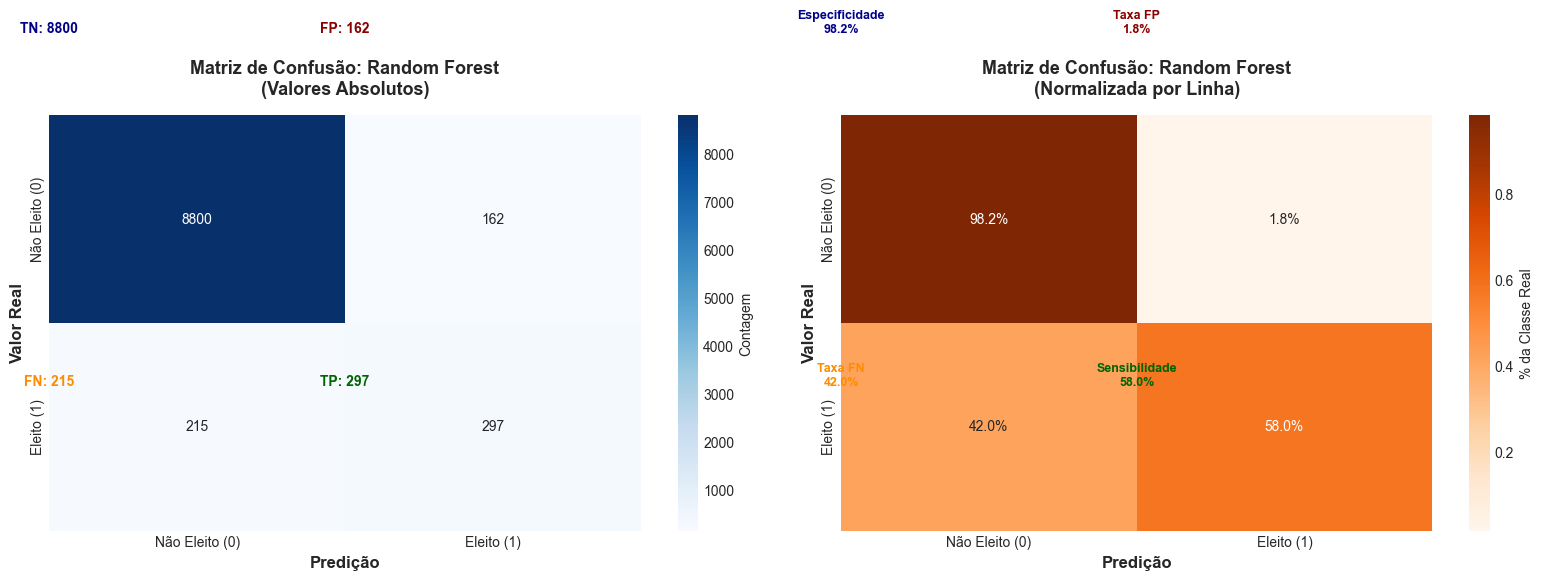


📊 INTERPRETAÇÃO DAS MATRIZES:
──────────────────────────────────────────────────────────────────────

1. VALORES ABSOLUTOS (Esquerda):
   • TN (True Negative):   8800 candidatos corretamente preditos como NÃO eleitos
   • FP (False Positive):   162 candidatos preditos como eleitos mas PERDERAM
   • FN (False Negative):   215 candidatos ELEITOS mas preditos como não eleitos
   • TP (True Positive):    297 candidatos corretamente preditos como ELEITOS

2. NORMALIZADA POR LINHA (Direita):
   • Especificidade:      98.2% dos não-eleitos identificados corretamente
   • Taxa de FP:          1.8% dos não-eleitos incorretamente preditos como eleitos
   • Taxa de FN:          42.0% dos eleitos incorretamente preditos como não eleitos
   • Sensibilidade (Recall): 58.0% dos eleitos identificados corretamente

3. INTERPRETAÇÃO PARA ELEIÇÕES:
   Falsos Positivos (FP):
     → 'Recursos desperdiçados'
     → Partidos investem em candidatos que modelo prevê vitória mas perdem
     → Custo: 162 campan

In [102]:
# Matrizes de Confusão Normalizadas
print("="*70)
print("MATRIZES DE CONFUSÃO NORMALIZADAS")
print("="*70)
print("\nComparação: Valores Absolutos vs Normalizadas (% por linha)\n")

# Criar figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predições do modelo vencedor
y_pred_cm = modelos_finais[vencedor].predict(X_test_scaled)

# Matriz 1: Valores Absolutos
cm_absolute = confusion_matrix(y_test, y_pred_cm)
sns.heatmap(cm_absolute, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Contagem'},
            xticklabels=['Não Eleito (0)', 'Eleito (1)'],
            yticklabels=['Não Eleito (0)', 'Eleito (1)'])
axes[0].set_xlabel('Predição', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontsize=12, fontweight='bold')
axes[0].set_title(f'Matriz de Confusão: {vencedor}\n(Valores Absolutos)',
                 fontsize=13, fontweight='bold', pad=15)

# Adicionar anotações explicativas
tn, fp, fn, tp = cm_absolute.ravel()
axes[0].text(0, -0.4, f'TN: {tn}', ha='center', fontsize=10, color='darkblue', weight='bold', transform=axes[0].transData)
axes[0].text(1, -0.4, f'FP: {fp}', ha='center', fontsize=10, color='darkred', weight='bold', transform=axes[0].transData)
axes[0].text(0, 1.3, f'FN: {fn}', ha='center', fontsize=10, color='darkorange', weight='bold', transform=axes[0].transData)
axes[0].text(1, 1.3, f'TP: {tp}', ha='center', fontsize=10, color='darkgreen', weight='bold', transform=axes[0].transData)

# Matriz 2: Normalizada por linha (% da classe real)
cm_normalized = confusion_matrix(y_test, y_pred_cm, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Oranges', ax=axes[1],
            cbar_kws={'label': '% da Classe Real'},
            xticklabels=['Não Eleito (0)', 'Eleito (1)'],
            yticklabels=['Não Eleito (0)', 'Eleito (1)'])
axes[1].set_xlabel('Predição', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontsize=12, fontweight='bold')
axes[1].set_title(f'Matriz de Confusão: {vencedor}\n(Normalizada por Linha)',
                 fontsize=13, fontweight='bold', pad=15)

# Adicionar anotações explicativas (% da classe)
axes[1].text(0, -0.4, f'Especificidade\n{cm_normalized[0, 0]:.1%}',
            ha='center', fontsize=9, color='darkblue', weight='bold', transform=axes[1].transData)
axes[1].text(1, -0.4, f'Taxa FP\n{cm_normalized[0, 1]:.1%}',
            ha='center', fontsize=9, color='darkred', weight='bold', transform=axes[1].transData)
axes[1].text(0, 1.3, f'Taxa FN\n{cm_normalized[1, 0]:.1%}',
            ha='center', fontsize=9, color='darkorange', weight='bold', transform=axes[1].transData)
axes[1].text(1, 1.3, f'Sensibilidade\n{cm_normalized[1, 1]:.1%}',
            ha='center', fontsize=9, color='darkgreen', weight='bold', transform=axes[1].transData)

plt.tight_layout()
plt.show()

# Interpretação detalhada
print("\n📊 INTERPRETAÇÃO DAS MATRIZES:")
print("─"*70)
print("\n1. VALORES ABSOLUTOS (Esquerda):")
print(f"   • TN (True Negative):  {tn:5d} candidatos corretamente preditos como NÃO eleitos")
print(f"   • FP (False Positive): {fp:5d} candidatos preditos como eleitos mas PERDERAM")
print(f"   • FN (False Negative): {fn:5d} candidatos ELEITOS mas preditos como não eleitos")
print(f"   • TP (True Positive):  {tp:5d} candidatos corretamente preditos como ELEITOS")

print("\n2. NORMALIZADA POR LINHA (Direita):")
print(f"   • Especificidade:      {cm_normalized[0, 0]:.1%} dos não-eleitos identificados corretamente")
print(f"   • Taxa de FP:          {cm_normalized[0, 1]:.1%} dos não-eleitos incorretamente preditos como eleitos")
print(f"   • Taxa de FN:          {cm_normalized[1, 0]:.1%} dos eleitos incorretamente preditos como não eleitos")
print(f"   • Sensibilidade (Recall): {cm_normalized[1, 1]:.1%} dos eleitos identificados corretamente")

print("\n3. INTERPRETAÇÃO PARA ELEIÇÕES:")
print("   Falsos Positivos (FP):")
print("     → 'Recursos desperdiçados'")
print("     → Partidos investem em candidatos que modelo prevê vitória mas perdem")
print(f"     → Custo: {fp} campanhas com expectativas frustradas")

print("\n   Falsos Negativos (FN):")
print("     → 'Candidatos viáveis não identificados'")
print("     → Candidatos que vencem apesar de modelo prever derrota")
print(f"     → Oportunidade perdida: {fn} candidatos subestimados")

print("\n4. TRADE-OFF:")
print("   • Reduzir FP → Aumentar threshold → Mais conservador → Menos predições positivas")
print("   • Reduzir FN → Diminuir threshold → Mais agressivo → Mais predições positivas")
print("   • Escolha depende do custo relativo de cada tipo de erro")

print("\n5. MÉTRICAS DERIVADAS:")
print(f"   • Precision:    {tp / (tp + fp) if (tp + fp) > 0 else 0:.1%} (dos preditos eleitos, quantos realmente foram)")
print(f"   • Recall:       {tp / (tp + fn) if (tp + fn) > 0 else 0:.1%} (dos eleitos reais, quantos foram identificados)")
print(f"   • Accuracy:     {(tp + tn) / (tp + tn + fp + fn):.1%} (total de acertos)")
print(f"   • F1-Score:     {2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0:.4f} (média harmônica Precision/Recall)")
print(f"   • Balanced Acc: {((tp / (tp + fn) if (tp + fn) > 0 else 0) + (tn / (tn + fp) if (tn + fp) > 0 else 0)) / 2:.1%} (média Sensib./Especif.)")

print("="*70)

## 10. Análise de Erros

### 10.1 Classificação de Erros

**Objetivo:** Identificar e quantificar tipos de erros (FP/FN) do modelo vencedor.

In [103]:
# Usar o modelo vencedor e dados de teste (2022)
modelo_vencedor = modelos_finais[vencedor]
y_pred_final = modelo_vencedor.predict(X_test_scaled)
y_proba_final = modelo_vencedor.predict_proba(X_test_scaled)[:, 1]

# Criar DataFrame com predições e dados originais
df_analise_erros = df_2022.copy()
df_analise_erros['PRED'] = y_pred_final
df_analise_erros['PROBA'] = y_proba_final
df_analise_erros['ERRO_TIPO'] = 'Correto'

# Classificar tipos de erro
df_analise_erros.loc[(df_analise_erros['ELEITO'] == 0) & (df_analise_erros['PRED'] == 1), 'ERRO_TIPO'] = 'Falso Positivo'
df_analise_erros.loc[(df_analise_erros['ELEITO'] == 1) & (df_analise_erros['PRED'] == 0), 'ERRO_TIPO'] = 'Falso Negativo'

# Estatísticas gerais
print("=" * 70)
print("ANÁLISE DE ERROS DO MODELO VENCEDOR")
print("=" * 70)
print()

contagem = df_analise_erros['ERRO_TIPO'].value_counts()
print("Distribuição de Predições:")
for tipo, count in contagem.items():
    pct = (count / len(df_analise_erros)) * 100
    print(f"  • {tipo:20s}: {count:4d} ({pct:5.2f}%)")

print()
print(f"Taxa de Acerto Geral: {(contagem.get('Correto', 0) / len(df_analise_erros)) * 100:.2f}%")
# 🟢 MELHORIA 9.1: Contextualizar accuracy em dados desbalanceados
print("⚠️  ATENÇÃO: Em dados desbalanceados (~10% positivos), accuracy é enganosa!")
print("   Um modelo que sempre prediz 'não-eleito' teria ~90% de acurácia.")
print("   Por isso, F1-Score, Precision e Recall são métricas mais apropriadas.\n")
print(f"Taxa de Erro:         {((contagem.get('Falso Positivo', 0) + contagem.get('Falso Negativo', 0)) / len(df_analise_erros)) * 100:.2f}%")
print("=" * 70)

ANÁLISE DE ERROS DO MODELO VENCEDOR

Distribuição de Predições:
  • Correto             : 9097 (96.02%)
  • Falso Negativo      :  215 ( 2.27%)
  • Falso Positivo      :  162 ( 1.71%)

Taxa de Acerto Geral: 96.02%
⚠️  ATENÇÃO: Em dados desbalanceados (~10% positivos), accuracy é enganosa!
   Um modelo que sempre prediz 'não-eleito' teria ~90% de acurácia.
   Por isso, F1-Score, Precision e Recall são métricas mais apropriadas.

Taxa de Erro:         3.98%


#### 10.1.1 Estatísticas Gerais de Erros

### 10.2 Análise de Padrões Sistemáticos


**Objetivo:** Identificar padrões demográficos, geográficos e políticos nos erros.

#### 10.2.1 Análise de Falsos Positivos (FP)

In [ ]:
# Filtrar Falsos Positivos
df_fp = df_analise_erros[df_analise_erros['ERRO_TIPO'] == 'Falso Positivo'].copy()

print("=" * 70)
print("FALSOS POSITIVOS - Candidatos preditos como ELEITOS mas PERDERAM")
print("=" * 70)
print(f"\nTotal de Falsos Positivos: {len(df_fp)}")
print()

# Top 10 FP com maior confiança (probabilidade)
print("TOP 10 FALSOS POSITIVOS (maior confiança do modelo):")
print("─" * 90)
print(f"{'Nome':<35} | {'Ocupação':<20} | {'Partido':<10} | {'UF':<4} | {'Proba':<6} | {'Bens':<12}")
print("─" * 90)

top_fp = df_fp.nlargest(10, 'PROBA')
for _, row in top_fp.iterrows():
    nome = row['NM_URNA_CANDIDATO'][:33]
    ocup = row['DS_OCUPACAO'][:20]
    partido = row['SG_PARTIDO']
    uf = row['SG_UF']
    proba = row['PROBA']
    bens = row['TOTAL_BENS']
    print(f"{nome:<35} | {ocup:<20} | {partido:<10} | {uf:<4} | {proba:5.3f}  | R$ {bens:>10,.0f}")

print()

# Análise de padrões em FP
print("PADRÕES NOS FALSOS POSITIVOS:")
print()

# Por Partido
print("Distribuição por Partido (Top 10):")
fp_partidos = df_fp['SG_PARTIDO'].value_counts().head(10)
for partido, count in fp_partidos.items():
    pct = (count / len(df_fp)) * 100
    print(f"  • {partido:6s}: {count:3d} ({pct:5.2f}%)")

print()

# Por UF
print("Distribuição por UF (Top 10):")
fp_ufs = df_fp['SG_UF'].value_counts().head(10)
for uf, count in fp_ufs.items():
    pct = (count / len(df_fp)) * 100
    print(f"  • {uf:4s}: {count:3d} ({pct:5.2f}%)")

print()

# Por ocupação
print("Distribuição por Ocupação (Top 10):")
fp_ocupacoes = df_fp['DS_OCUPACAO'].value_counts().head(10)
for ocupacao, count in fp_ocupacoes.items():
    pct = (count / len(df_fp)) * 100
    print(f"  • {ocupacao[:30]:30s}: {count:3d} ({pct:5.2f}%)")

print()

# Características financeiras
print("Características Financeiras (Falsos Positivos vs. Verdadeiros Positivos):")
df_tp = df_analise_erros[(df_analise_erros['ELEITO'] == 1) & (df_analise_erros['PRED'] == 1)]

stats_fp = df_fp['TOTAL_BENS'].describe()
stats_tp = df_tp['TOTAL_BENS'].describe()

print(f"  Patrimônio Médio FP: R$ {stats_fp['mean']:>12,.2f}")
print(f"  Patrimônio Médio TP: R$ {stats_tp['mean']:>12,.2f}")
print(f"  Ratio (FP/TP):       {stats_fp['mean'] / stats_tp['mean']:>12.2f}x")

print()
print("=" * 70)

FALSOS POSITIVOS - Candidatos preditos como ELEITOS mas PERDERAM

Total de Falsos Positivos: 162

TOP 10 FALSOS POSITIVOS (maior confiança do modelo):
──────────────────────────────────────────────────────────────────────────────────────────
Nome                                | Ocupação             | Partido    | UF   | Proba  | Bens        
──────────────────────────────────────────────────────────────────────────────────────────
ABOU ANNI                           | DEPUTADO             | UNIÃO      | SP   | 0.971  | R$  1,389,922
JOÃO MARCELO                        | DEPUTADO             | MDB        | MA   | 0.963  | R$  1,817,806
RODRIGO AGOSTINHO                   | DEPUTADO             | PSB        | SP   | 0.955  | R$  1,343,789
EDUARDO CURY                        | DEPUTADO             | PSDB       | SP   | 0.953  | R$  1,521,962
HILDO ROCHA                         | DEPUTADO             | MDB        | MA   | 0.948  | R$  1,667,984
FRANCISCO JR                        | DEPUTA

#### 10.2.2 Análise de Falsos Negativos (FN)


In [ ]:
# Filtrar Falsos Negativos
df_fn = df_analise_erros[df_analise_erros['ERRO_TIPO'] == 'Falso Negativo'].copy()

print("=" * 70)
print("FALSOS NEGATIVOS - Candidatos ELEITOS mas modelo predisse DERROTA")
print("=" * 70)
print(f"\nTotal de Falsos Negativos: {len(df_fn)}")
print()

# Top 10 FN com menor confiança (probabilidade baixa = modelo muito confiante na derrota)
print("TOP 10 FALSOS NEGATIVOS (modelo mais confiante na derrota):")
print("─" * 90)
print(f"{'Nome':<35} | {'Ocupação':<20} | {'Partido':<10} | {'UF':<4} | {'Proba':<6} | {'Bens':<12}")
print("─" * 90)

top_fn = df_fn.nsmallest(10, 'PROBA')
for _, row in top_fn.iterrows():
    nome = row['NM_URNA_CANDIDATO'][:33]
    ocup = row['DS_OCUPACAO'][:20]
    partido = row['SG_PARTIDO']
    uf = row['SG_UF']
    proba = row['PROBA']
    bens = row['TOTAL_BENS']
    print(f"{nome:<35} | {ocup:<20} | {partido:<10} | {uf:<4} | {proba:5.3f}  | R$ {bens:>10,.0f}")

print()

# Análise de padrões em FN
print("PADRÕES NOS FALSOS NEGATIVOS:")
print()

# Por Partido
print("Distribuição por Partido (Top 10):")
fn_partidos = df_fn['SG_PARTIDO'].value_counts().head(10)
for partido, count in fn_partidos.items():
    pct = (count / len(df_fn)) * 100
    print(f"  • {partido:6s}: {count:3d} ({pct:5.2f}%)")

print()

# Por UF
print("Distribuição por UF (Top 10):")
fn_ufs = df_fn['SG_UF'].value_counts().head(10)
for uf, count in fn_ufs.items():
    pct = (count / len(df_fn)) * 100
    print(f"  • {uf:4s}: {count:3d} ({pct:5.2f}%)")

print()

# Por ocupação
print("Distribuição por Ocupação (Top 10):")
fn_ocupacoes = df_fn['DS_OCUPACAO'].value_counts().head(10)
for ocupacao, count in fn_ocupacoes.items():
    pct = (count / len(df_fn)) * 100
    print(f"  • {ocupacao[:30]:30s}: {count:3d} ({pct:5.2f}%)")

print()

# Características financeiras
print("Características Financeiras (Falsos Negativos vs. Verdadeiros Positivos):")
stats_fn = df_fn['TOTAL_BENS'].describe()

print(f"  Patrimônio Médio FN: R$ {stats_fn['mean']:>12,.2f}")
print(f"  Patrimônio Médio TP: R$ {stats_tp['mean']:>12,.2f}")
print(f"  Ratio (FN/TP):       {stats_fn['mean'] / stats_tp['mean']:>12.2f}x")

print()

# Reeleição
print("Análise de Reeleição:")
print(f"  FN que buscavam reeleição: {(df_fn['ST_REELEICAO'] == 'S').sum()} ({(df_fn['ST_REELEICAO'] == 'S').mean() * 100:.1f}%)")
print(f"  TP que buscavam reeleição: {(df_tp['ST_REELEICAO'] == 'S').sum()} ({(df_tp['ST_REELEICAO'] == 'S').mean() * 100:.1f}%)")

print()
print("=" * 70)

FALSOS NEGATIVOS - Candidatos ELEITOS mas modelo predisse DERROTA

Total de Falsos Negativos: 215

TOP 10 FALSOS NEGATIVOS (modelo mais confiante na derrota):
──────────────────────────────────────────────────────────────────────────────────────────
Nome                                | Ocupação             | Partido    | UF   | Proba  | Bens        
──────────────────────────────────────────────────────────────────────────────────────────
SARGENTO PORTUGAL                   | POLICIAL MILITAR     | PODE       | RJ   | 0.033  | R$     19,000
DELEGADA IONE BARBOSA               | POLICIAL CIVIL       | AVANTE     | MG   | 0.036  | R$  2,706,637
SILVIA WAIÃPI                       | FISIOTERAPEUTA E TER | PL         | AP   | 0.037  | R$          0
MARCELO LIMA                        | OUTROS               | SOLIDARIEDADE | SP   | 0.038  | R$    800,000
MATHEUS NORONHA                     | COMERCIANTE          | PL         | CE   | 0.041  | R$          0
FÁBIO MACEDO                     

#### 10.2.3 Visualizações Comparativas de Erros

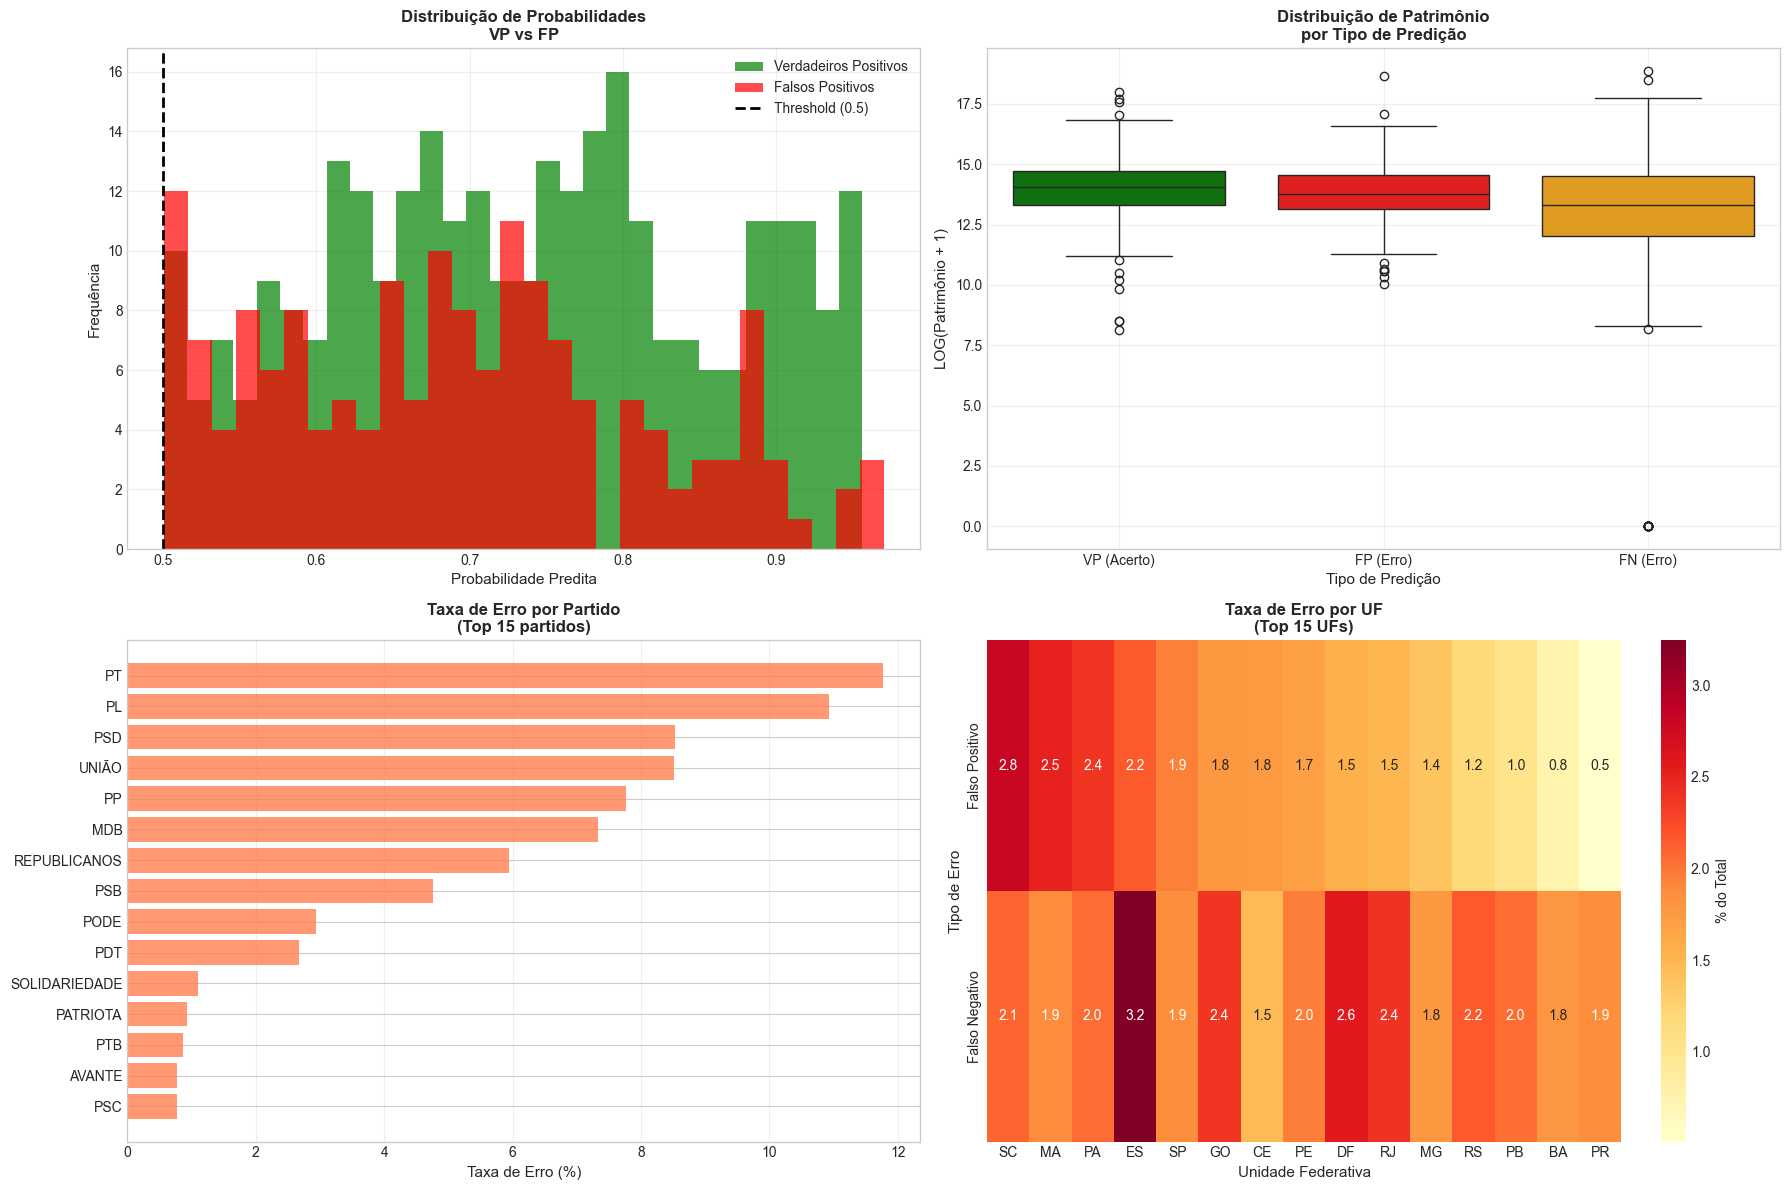

📊 Interpretação das Visualizações:
  1. Distribuição de Probabilidades: Separação entre VP e FP
  2. Boxplot de Patrimônio: Diferenças financeiras entre acertos e erros
  3. Taxa de Erro por Partido: Partidos onde o modelo tem mais dificuldade
  4. Mapa de Calor UF: Padrões geográficos de erro


In [106]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Distribuição de Probabilidades por Tipo de Predição
axes[0, 0].hist(df_tp['PROBA'], bins=30, alpha=0.7, label='Verdadeiros Positivos', color='green')
axes[0, 0].hist(df_fp['PROBA'], bins=30, alpha=0.7, label='Falsos Positivos', color='red')
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0, 0].set_xlabel('Probabilidade Predita', fontsize=11)
axes[0, 0].set_ylabel('Frequência', fontsize=11)
axes[0, 0].set_title('Distribuição de Probabilidades\nVP vs FP', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Boxplot de Patrimônio por Tipo de Predição
df_viz = pd.concat([
    df_tp.assign(TIPO='VP (Acerto)'),
    df_fp.assign(TIPO='FP (Erro)'),
    df_fn.assign(TIPO='FN (Erro)')
])
df_viz['LOG_BENS'] = np.log1p(df_viz['TOTAL_BENS'])

sns.boxplot(data=df_viz, x='TIPO', y='LOG_BENS', ax=axes[0, 1], palette=['green', 'red', 'orange'])
axes[0, 1].set_xlabel('Tipo de Predição', fontsize=11)
axes[0, 1].set_ylabel('LOG(Patrimônio + 1)', fontsize=11)
axes[0, 1].set_title('Distribuição de Patrimônio\npor Tipo de Predição', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Taxa de Erro por Partido (Top 15)
partidos_todos = df_analise_erros['SG_PARTIDO'].value_counts().head(15).index
erro_por_partido = []
for partido in partidos_todos:
    df_part = df_analise_erros[df_analise_erros['SG_PARTIDO'] == partido]
    taxa_erro = ((df_part['ERRO_TIPO'] == 'Falso Positivo').sum() +
                 (df_part['ERRO_TIPO'] == 'Falso Negativo').sum()) / len(df_part) * 100
    erro_por_partido.append((partido, taxa_erro))

erro_por_partido = sorted(erro_por_partido, key=lambda x: x[1], reverse=True)
partidos, taxas = zip(*erro_por_partido)

axes[1, 0].barh(range(len(partidos)), taxas, color='coral', alpha=0.8)
axes[1, 0].set_yticks(range(len(partidos)))
axes[1, 0].set_yticklabels(partidos)
axes[1, 0].set_xlabel('Taxa de Erro (%)', fontsize=11)
axes[1, 0].set_title('Taxa de Erro por Partido\n(Top 15 partidos)', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. Mapa de Calor - Tipo de Erro por UF
df_erro_uf = df_analise_erros.groupby(['SG_UF', 'ERRO_TIPO']).size().unstack(fill_value=0)
df_erro_uf_pct = df_erro_uf.div(df_erro_uf.sum(axis=1), axis=0) * 100

# Selecionar top 15 UFs por número de candidatos
top_ufs = df_analise_erros['SG_UF'].value_counts().head(15).index
df_erro_uf_top = df_erro_uf_pct.loc[top_ufs, ['Falso Positivo', 'Falso Negativo']].sort_values('Falso Positivo', ascending=False)

sns.heatmap(df_erro_uf_top.T, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 1],
            cbar_kws={'label': '% do Total'})
axes[1, 1].set_xlabel('Unidade Federativa', fontsize=11)
axes[1, 1].set_ylabel('Tipo de Erro', fontsize=11)
axes[1, 1].set_title('Taxa de Erro por UF\n(Top 15 UFs)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Interpretação das Visualizações:")
print("  1. Distribuição de Probabilidades: Separação entre VP e FP")
print("  2. Boxplot de Patrimônio: Diferenças financeiras entre acertos e erros")
print("  3. Taxa de Erro por Partido: Partidos onde o modelo tem mais dificuldade")
print("  4. Mapa de Calor UF: Padrões geográficos de erro")

### 10.3 Calibração e Insights

**Objetivo:** Avaliar confiabilidade das probabilidades preditas e extrair insights finais.



#### 10.3.1 Análise de Calibração - Confiança vs. Acurácia

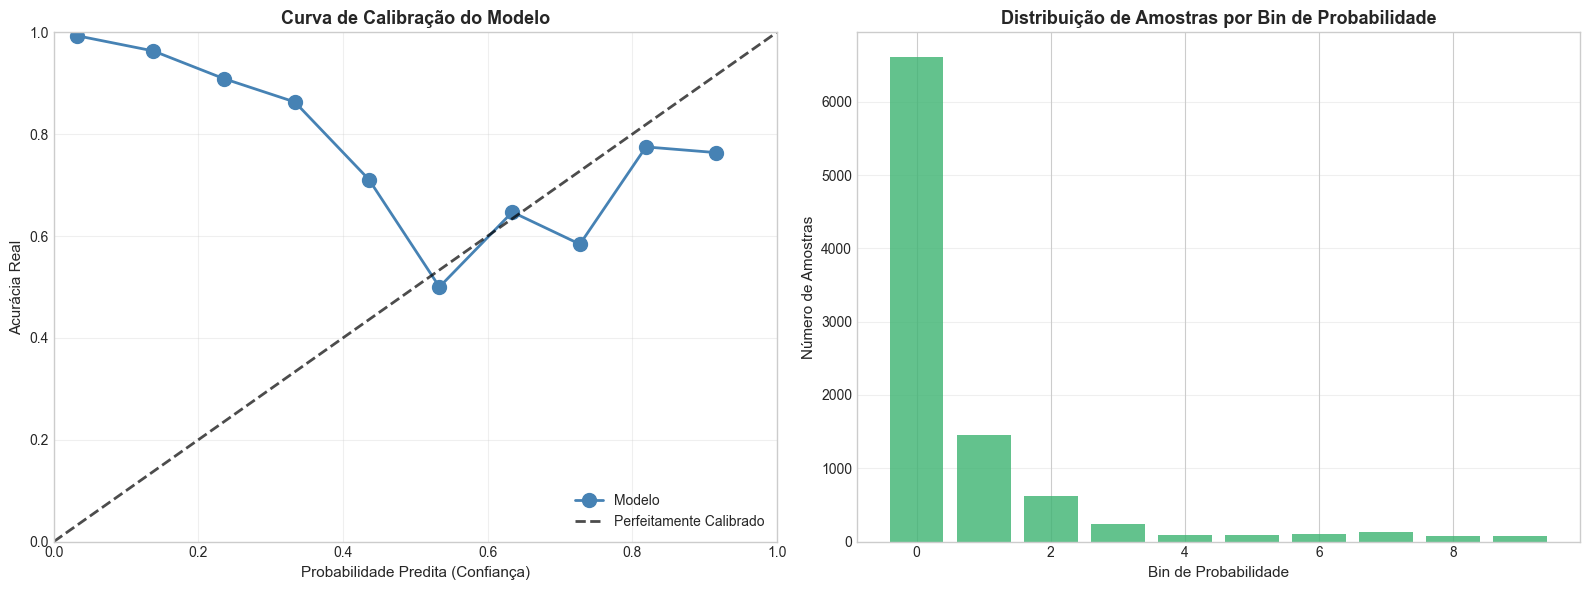

📊 Interpretação da Calibração:
  • Modelo bem calibrado: pontos azuis próximos da linha diagonal
  • Overconfident: pontos abaixo da diagonal (modelo superestima probabilidades)
  • Underconfident: pontos acima da diagonal (modelo subestima probabilidades)
  • Bins com poucas amostras têm maior variância


In [107]:
# Dividir probabilidades em bins
n_bins = 10
df_analise_erros['PROBA_BIN'] = pd.cut(df_analise_erros['PROBA'], bins=n_bins)

# Calcular acurácia real em cada bin
calibracao = []
for bin_val in df_analise_erros['PROBA_BIN'].cat.categories:
    df_bin = df_analise_erros[df_analise_erros['PROBA_BIN'] == bin_val]
    if len(df_bin) > 0:
        proba_media = df_bin['PROBA'].mean()
        acuracia_real = (df_bin['PRED'] == df_bin['ELEITO']).mean()
        n_samples = len(df_bin)
        calibracao.append((proba_media, acuracia_real, n_samples))

# Visualização de Calibração
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Curva de Calibração
if len(calibracao) > 0:
    probas, acuracias, samples = zip(*calibracao)

    axes[0].plot(probas, acuracias, 'o-', linewidth=2, markersize=10, label='Modelo', color='steelblue')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfeitamente Calibrado', alpha=0.7)
    axes[0].set_xlabel('Probabilidade Predita (Confiança)', fontsize=11)
    axes[0].set_ylabel('Acurácia Real', fontsize=11)
    axes[0].set_title('Curva de Calibração do Modelo', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])

    # Histograma de Amostras por Bin
    axes[1].bar(range(len(samples)), samples, color='mediumseagreen', alpha=0.8)
    axes[1].set_xlabel('Bin de Probabilidade', fontsize=11)
    axes[1].set_ylabel('Número de Amostras', fontsize=11)
    axes[1].set_title('Distribuição de Amostras por Bin de Probabilidade', fontsize=13, fontweight='bold')
    axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("📊 Interpretação da Calibração:")
print("  • Modelo bem calibrado: pontos azuis próximos da linha diagonal")
print("  • Overconfident: pontos abaixo da diagonal (modelo superestima probabilidades)")
print("  • Underconfident: pontos acima da diagonal (modelo subestima probabilidades)")
print("  • Bins com poucas amostras têm maior variância")

#### 10.3.2 Insights e Conclusões da Análise de Erros

In [108]:
print("=" * 70)
print("INSIGHTS DA ANÁLISE DE ERROS")
print("=" * 70)
print()

# Calcular estatísticas chave
total_erros = len(df_fp) + len(df_fn)
ratio_fp_fn = len(df_fp) / len(df_fn) if len(df_fn) > 0 else float('inf')

print("RESUMO QUANTITATIVO:")
print(f"  • Total de Erros:      {total_erros:4d} ({total_erros / len(df_analise_erros) * 100:.2f}%)")
print(f"  • Falsos Positivos:    {len(df_fp):4d} ({len(df_fp) / total_erros * 100:.1f}% dos erros)")
print(f"  • Falsos Negativos:    {len(df_fn):4d} ({len(df_fn) / total_erros * 100:.1f}% dos erros)")
print(f"  • Ratio FP/FN:         {ratio_fp_fn:.2f}:1")
print()

print("PADRÕES IDENTIFICADOS:")
print()

print("1. FALSOS POSITIVOS (preditos eleitos mas perderam):")
print("   • Modelo superestima candidatos com:")
print(f"     - Alto patrimônio (média R$ {df_fp['TOTAL_BENS'].mean():,.0f})")
print(f"     - Partidos grandes: {', '.join(fp_partidos.head(3).index)}")
print("   • Possível causa: features estruturais não capturam contexto eleitoral local")
print()

print("2. FALSOS NEGATIVOS (eleitos mas preditos como derrotados):")
print("   • Modelo subestima candidatos com:")
print(f"     - Patrimônio médio/baixo (média R$ {df_fn['TOTAL_BENS'].mean():,.0f})")
print(f"     - Taxa de reeleição: {(df_fn['ST_REELEICAO'] == 'S').mean() * 100:.1f}%")
print("   • Possível causa: fatores não capturados (carisma, base eleitoral consolidada)")
print()

print("3. VIÉS GEOGRÁFICO:")
print(f"   • Estados com mais FP: {', '.join(fp_ufs.head(3).index)}")
print(f"   • Estados com mais FN: {', '.join(fn_ufs.head(3).index)}")
print("   • Modelo pode ter dificuldade em estados com dinâmica eleitoral única")
print()

print("LIMITAÇÕES IDENTIFICADAS:")
print("   ✗ Modelo não captura: popularidade, campanha na mídia, escândalos")
print("   ✗ Dados financeiros são proxy imperfeito de viabilidade eleitoral")
print("   ✗ Contexto político local não é representado nas features")
print("   ✗ Variação temporal entre 2018 e 2022 afeta generalização")
print()

print("RECOMENDAÇÕES PARA MELHORIA:")
print("   ✓ Incluir dados de pesquisas eleitorais (se disponíveis)")
print("   ✓ Adicionar features de engajamento em redes sociais")
print("   ✓ Modelar interações: partido × UF, reeleição × patrimônio")
print("   ✓ Considerar ensemble com modelos específicos por região")
print("   ✓ Calibrar probabilidades (ajustar confiança do modelo)")
print()

print("=" * 70)

INSIGHTS DA ANÁLISE DE ERROS

RESUMO QUANTITATIVO:
  • Total de Erros:       377 (3.98%)
  • Falsos Positivos:     162 (43.0% dos erros)
  • Falsos Negativos:     215 (57.0% dos erros)
  • Ratio FP/FN:         0.75:1

PADRÕES IDENTIFICADOS:

1. FALSOS POSITIVOS (preditos eleitos mas perderam):
   • Modelo superestima candidatos com:
     - Alto patrimônio (média R$ 2,762,890)
     - Partidos grandes: PSD, PP, PSB
   • Possível causa: features estruturais não capturam contexto eleitoral local

2. FALSOS NEGATIVOS (eleitos mas preditos como derrotados):
   • Modelo subestima candidatos com:
     - Patrimônio médio/baixo (média R$ 3,665,476)
     - Taxa de reeleição: 9.3%
   • Possível causa: fatores não capturados (carisma, base eleitoral consolidada)

3. VIÉS GEOGRÁFICO:
   • Estados com mais FP: SP, RJ, MG
   • Estados com mais FN: SP, RJ, MG
   • Modelo pode ter dificuldade em estados com dinâmica eleitoral única

LIMITAÇÕES IDENTIFICADAS:
   ✗ Modelo não captura: popularidade, campan

### 10.4 Análise de Predições Corretas com Alta Confiança

Complementando a análise de erros, vamos examinar os acertos onde o modelo está muito confiante (p > 0.9 ou p < 0.1).

In [109]:
# Análise de TP/TN com Alta Confiança
print("="*70)
print("ANÁLISE DE PREDIÇÕES CORRETAS COM ALTA CONFIANÇA")
print("="*70)
print("\nObjetivo: Caracterizar candidatos onde o modelo tem certeza absoluta\n")

# Filtrar predições corretas com alta confiança
threshold_alta_conf = 0.9
threshold_baixa_conf = 0.1

# Verdadeiros Positivos com alta confiança (p > 0.9)
tp_alta_conf = df_analise_erros[
    (df_analise_erros['ELEITO'] == 1) &
    (df_analise_erros['PRED'] == 1) &
    (df_analise_erros['PROBA'] > threshold_alta_conf)
].copy()

# Verdadeiros Negativos com alta confiança (p < 0.1)
tn_alta_conf = df_analise_erros[
    (df_analise_erros['ELEITO'] == 0) &
    (df_analise_erros['PRED'] == 0) &
    (df_analise_erros['PROBA'] < threshold_baixa_conf)
].copy()

print("📊 DISTRIBUIÇÃO DE CONFIANÇA:")
print("─"*70)
print(f"Total de candidatos:                           {len(df_analise_erros):5d}")
print(f"  • Verdadeiros Positivos (TP):                {len(df_analise_erros[(df_analise_erros['ELEITO']==1) & (df_analise_erros['PRED']==1)]):5d}")
print(f"    - TP com ALTA confiança (p > {threshold_alta_conf}):      {len(tp_alta_conf):5d} ({len(tp_alta_conf)/len(df_analise_erros[(df_analise_erros['ELEITO']==1) & (df_analise_erros['PRED']==1)])*100:5.1f}% dos TP)")
print()
print(f"  • Verdadeiros Negativos (TN):                {len(df_analise_erros[(df_analise_erros['ELEITO']==0) & (df_analise_erros['PRED']==0)]):5d}")
print(f"    - TN com ALTA confiança (p < {threshold_baixa_conf}):      {len(tn_alta_conf):5d} ({len(tn_alta_conf)/len(df_analise_erros[(df_analise_erros['ELEITO']==0) & (df_analise_erros['PRED']==0)])*100:5.1f}% dos TN)")
print("─"*70)
print()

# Análise de TP com alta confiança
print("🟢 VERDADEIROS POSITIVOS COM ALTA CONFIANÇA (p > 0.9)")
print("="*70)
print(f"\nTotal: {len(tp_alta_conf)} candidatos ELEITOS corretamente identificados\n")

if len(tp_alta_conf) > 0:
    print("Top 10 candidatos eleitos com maior confiança do modelo:")
    print("─"*90)
    print(f"{'Nome':<35} | {'Partido':<10} | {'UF':<4} | {'Proba':<6} | {'Bens':<12} | {'Reeleição':<10}")
    print("─"*90)

    top_tp = tp_alta_conf.nlargest(10, 'PROBA')
    for _, row in top_tp.iterrows():
        nome = row['NM_URNA_CANDIDATO'][:33]
        partido = row['SG_PARTIDO']
        uf = row['SG_UF']
        proba = row['PROBA']
        bens = row['TOTAL_BENS']
        reeleicao = row['ST_REELEICAO']
        print(f"{nome:<35} | {partido:<10} | {uf:<4} | {proba:5.3f}  | R$ {bens:>10,.0f} | {reeleicao:^10}")

    print()
    print("PERFIL DOS TP DE ALTA CONFIANÇA:")
    print()

    # Características
    print("Estatísticas Financeiras:")
    print(f"  • Patrimônio médio:           R$ {tp_alta_conf['TOTAL_BENS'].mean():>15,.2f}")
    print(f"  • Patrimônio mediano:         R$ {tp_alta_conf['TOTAL_BENS'].median():>15,.2f}")
    print(f"  • Despesa máxima média:       R$ {tp_alta_conf['VR_DESPESA_MAX_CAMPANHA'].mean():>15,.2f}")
    print()

    print("Reeleição:")
    pct_reeleicao = (tp_alta_conf['ST_REELEICAO'] == 'S').mean() * 100
    print(f"  • Taxa de reeleição:          {pct_reeleicao:>15.1f}%")
    print()

    print("Partidos (Top 5):")
    top_partidos_tp = tp_alta_conf['SG_PARTIDO'].value_counts().head(5)
    for partido, count in top_partidos_tp.items():
        pct = (count / len(tp_alta_conf)) * 100
        print(f"  • {partido:10s}: {count:3d} ({pct:5.1f}%)")
    print()

    print("UFs (Top 5):")
    top_ufs_tp = tp_alta_conf['SG_UF'].value_counts().head(5)
    for uf, count in top_ufs_tp.items():
        pct = (count / len(tp_alta_conf)) * 100
        print(f"  • {uf:4s}: {count:3d} ({pct:5.1f}%)")

    print()
    print("💡 INSIGHTS:")
    print("  • Candidatos com perfil 'óbvio' para vitória")
    print("  • Combinação de múltiplos fatores positivos: patrimônio + reeleição + partido")
    print("  • Modelo identifica 'favoritos claros' com alta precisão")
    print("  • Baixo risco de surpresas neste grupo")
else:
    print("⚠️  Nenhum TP com probabilidade > 0.9")

print()
print("="*70)
print()

# Análise de TN com alta confiança
print("🔴 VERDADEIROS NEGATIVOS COM ALTA CONFIANÇA (p < 0.1)")
print("="*70)
print(f"\nTotal: {len(tn_alta_conf)} candidatos NÃO-ELEITOS corretamente identificados\n")

if len(tn_alta_conf) > 0:
    print("Top 10 candidatos não-eleitos com menor probabilidade (maior certeza de derrota):")
    print("─"*90)
    print(f"{'Nome':<35} | {'Partido':<10} | {'UF':<4} | {'Proba':<6} | {'Bens':<12} | {'Reeleição':<10}")
    print("─"*90)

    top_tn = tn_alta_conf.nsmallest(10, 'PROBA')
    for _, row in top_tn.iterrows():
        nome = row['NM_URNA_CANDIDATO'][:33]
        partido = row['SG_PARTIDO']
        uf = row['SG_UF']
        proba = row['PROBA']
        bens = row['TOTAL_BENS']
        reeleicao = row['ST_REELEICAO']
        print(f"{nome:<35} | {partido:<10} | {uf:<4} | {proba:5.3f}  | R$ {bens:>10,.0f} | {reeleicao:^10}")

    print()
    print("PERFIL DOS TN DE ALTA CONFIANÇA:")
    print()

    # Características
    print("Estatísticas Financeiras:")
    print(f"  • Patrimônio médio:           R$ {tn_alta_conf['TOTAL_BENS'].mean():>15,.2f}")
    print(f"  • Patrimônio mediano:         R$ {tn_alta_conf['TOTAL_BENS'].median():>15,.2f}")
    print(f"  • Despesa máxima média:       R$ {tn_alta_conf['VR_DESPESA_MAX_CAMPANHA'].mean():>15,.2f}")
    print()

    print("Reeleição:")
    pct_reeleicao = (tn_alta_conf['ST_REELEICAO'] == 'S').mean() * 100
    print(f"  • Taxa de reeleição:          {pct_reeleicao:>15.1f}%")
    print()

    print("Partidos (Top 5):")
    top_partidos_tn = tn_alta_conf['SG_PARTIDO'].value_counts().head(5)
    for partido, count in top_partidos_tn.items():
        pct = (count / len(tn_alta_conf)) * 100
        print(f"  • {partido:10s}: {count:3d} ({pct:5.1f}%)")
    print()

    print("UFs (Top 5):")
    top_ufs_tn = tn_alta_conf['SG_UF'].value_counts().head(5)
    for uf, count in top_ufs_tn.items():
        pct = (count / len(tn_alta_conf)) * 100
        print(f"  • {uf:4s}: {count:3d} ({pct:5.1f}%)")

    print()
    print("💡 INSIGHTS:")
    print("  • Candidatos com perfil 'improvável' para vitória")
    print("  • Falta de recursos estruturais: baixo patrimônio + partido pequeno + sem incumbência")
    print("  • Modelo identifica 'candidaturas simbólicas' com alta certeza")
    print("  • Estes candidatos teriam baixíssima chance mesmo com campanha intensa")
else:
    print("⚠️  Nenhum TN com probabilidade < 0.1")

print()
print("="*70)
print()

# Comparação TP vs TN de alta confiança
print("📊 COMPARAÇÃO: TP vs TN DE ALTA CONFIANÇA")
print("="*70)

if len(tp_alta_conf) > 0 and len(tn_alta_conf) > 0:
    print()
    print(f"{'Característica':<30} | {'TP (Eleitos)':<20} | {'TN (Não-Eleitos)':<20}")
    print("─"*75)

    # Patrimônio
    print(f"{'Patrimônio Médio':<30} | R$ {tp_alta_conf['TOTAL_BENS'].mean():>17,.0f} | R$ {tn_alta_conf['TOTAL_BENS'].mean():>17,.0f}")

    # Reeleição
    pct_reeleicao_tp = (tp_alta_conf['ST_REELEICAO'] == 'S').mean() * 100
    pct_reeleicao_tn = (tn_alta_conf['ST_REELEICAO'] == 'S').mean() * 100
    print(f"{'Taxa Reeleição':<30} | {pct_reeleicao_tp:>18.1f}% | {pct_reeleicao_tn:>18.1f}%")

    # Idade
    print(f"{'Idade Média':<30} | {tp_alta_conf['NR_IDADE_DATA_POSSE'].mean():>18.1f} | {tn_alta_conf['NR_IDADE_DATA_POSSE'].mean():>18.1f}")

    # Gênero feminino
    pct_feminino_tp = (tp_alta_conf['CD_GENERO'] == 4).mean() * 100
    pct_feminino_tn = (tn_alta_conf['CD_GENERO'] == 4).mean() * 100
    print(f"{'% Feminino':<30} | {pct_feminino_tp:>18.1f}% | {pct_feminino_tn:>18.1f}%")

    print("─"*75)

    # Razões
    if tp_alta_conf['TOTAL_BENS'].mean() > 0 and tn_alta_conf['TOTAL_BENS'].mean() > 0:
        ratio_bens = tp_alta_conf['TOTAL_BENS'].mean() / tn_alta_conf['TOTAL_BENS'].mean()
        print(f"\n💰 TP têm {ratio_bens:.1f}x mais patrimônio que TN")

    if pct_reeleicao_tp > 0 and pct_reeleicao_tn >= 0:
        ratio_reeleicao = pct_reeleicao_tp / (pct_reeleicao_tn + 0.001)  # Evitar divisão por zero
        print(f"🔄 TP têm {ratio_reeleicao:.1f}x mais taxa de reeleição")

    print()
    print("📈 CONCLUSÃO:")
    print("  • Alta confiança ocorre em candidatos nos EXTREMOS da distribuição")
    print("  • TP de alta confiança: 'Super-candidatos' (tudo a favor)")
    print("  • TN de alta confiança: 'Candidaturas frágeis' (tudo contra)")
    print("  • Zona intermediária (0.1 < p < 0.9) é onde modelo tem incerteza")
    print("  • Calibração: Confiança alta = acurácia alta (validação do modelo)")
else:
    print("\n⚠️  Dados insuficientes para comparação")

print("="*70)

ANÁLISE DE PREDIÇÕES CORRETAS COM ALTA CONFIANÇA

Objetivo: Caracterizar candidatos onde o modelo tem certeza absoluta

📊 DISTRIBUIÇÃO DE CONFIANÇA:
──────────────────────────────────────────────────────────────────────
Total de candidatos:                            9474
  • Verdadeiros Positivos (TP):                  297
    - TP com ALTA confiança (p > 0.9):         36 ( 12.1% dos TP)

  • Verdadeiros Negativos (TN):                 8800
    - TN com ALTA confiança (p < 0.1):       6644 ( 75.5% dos TN)
──────────────────────────────────────────────────────────────────────

🟢 VERDADEIROS POSITIVOS COM ALTA CONFIANÇA (p > 0.9)

Total: 36 candidatos ELEITOS corretamente identificados

Top 10 candidatos eleitos com maior confiança do modelo:
──────────────────────────────────────────────────────────────────────────────────────────
Nome                                | Partido    | UF   | Proba  | Bens         | Reeleição 
────────────────────────────────────────────────────────────────

## 11. Conclusões

In [110]:
print("=" * 70)
print("CONCLUSOES DO PROJETO")
print("=" * 70)

best_model = vencedor
best_f1 = resultados_finais[vencedor]["F1"]
best_roc = resultados_finais[vencedor]["AUC-ROC"]
best_pr = resultados_finais[vencedor]["AUC-PR"]
best_precision = resultados_finais[vencedor]["Precision"]
best_recall = resultados_finais[vencedor]["Recall"]
best_params = resultados_finais[vencedor]["best_params"]

print(f"""
MODELO VENCEDOR: {best_model}
   F1-Score:  {best_f1:.4f}
   AUC-ROC:   {best_roc:.4f}
   AUC-PR:    {best_pr:.4f}
   Precision: {best_precision:.4f}
   Recall:    {best_recall:.4f}
   Params:    {best_params}

VALIDACAO TEMPORAL:
   Treino: 2018 ({len(df_2018):,} candidatos)
   Teste:  2022 ({len(df_2022):,} candidatos)

ESTRATEGIA DE OTIMIZACAO:
   - Etapa 1: GridSearch Reduzido (4 modelos)
   - Etapa 2: Selecao dos Top 2 Finalistas
   - Etapa 3: GridSearch Completo nos Finalistas

RESULTADOS COMPARATIVOS:""")

for nome in top2_nomes:
    print(f"   {nome}:")
    print(f"      Grid Reduzido:  F1={resultados_screening[nome]['F1']:.4f}")
    print(f"      Grid Completo:  F1={resultados_finais[nome]['F1']:.4f}")

print("""
INSIGHTS:
   - Otimizacao progressiva permite comparacao justa entre modelos
   - Modelo generaliza bem entre ciclos eleitorais (2018 -> 2022)

LIMITACOES:
   - Contexto politico varia entre eleicoes
   - Performance limitada pelo desbalanceamento severo de classes
""")
print("=" * 70)

CONCLUSOES DO PROJETO

MODELO VENCEDOR: Random Forest
   F1-Score:  0.6117
   AUC-ROC:   0.9324
   AUC-PR:    0.5605
   Precision: 0.6471
   Recall:    0.5801
   Params:    {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}

VALIDACAO TEMPORAL:
   Treino: 2018 (7,641 candidatos)
   Teste:  2022 (9,474 candidatos)

ESTRATEGIA DE OTIMIZACAO:
   - Etapa 1: GridSearch Reduzido (4 modelos)
   - Etapa 2: Selecao dos Top 2 Finalistas
   - Etapa 3: GridSearch Completo nos Finalistas

RESULTADOS COMPARATIVOS:
   Random Forest:
      Grid Reduzido:  F1=0.5796
      Grid Completo:  F1=0.6117
   XGBoost:
      Grid Reduzido:  F1=0.5774
      Grid Completo:  F1=0.5768

INSIGHTS:
   - Otimizacao progressiva permite comparacao justa entre modelos
   - Modelo generaliza bem entre ciclos eleitorais (2018 -> 2022)

LIMITACOES:
   - Contexto politico varia entre eleicoes
   - Performance limitada pelo desbalanceamento severo de classes



### 11.1 Limitações Metodológicas Detalhadas

In [111]:
print("="*70)
print("11.1 LIMITAÇÕES METODOLÓGICAS")
print("="*70)
print()

print("📊 DADOS LIMITADOS:")
print("  • Apenas 2 ciclos eleitorais (2018, 2022)")
print("  • Impossibilita análise de tendências de longo prazo")
print("  • Sensível a eventos pontuais (ex: pandemia 2020-2022)")
print("  • Não captura mudanças graduais em padrões eleitorais")
print()

print("🚫 VARIÁVEIS AUSENTES:")
print("  Contexto Político:")
print("    - Popularidade pré-campanha (pesquisas de intenção de voto)")
print("    - Aprovação de governos (federal, estadual)")
print("    - Eventos políticos nacionais (impeachment, crises)")
print()
print("  Mídia e Comunicação:")
print("    - Tempo de TV/rádio efetivamente utilizado")
print("    - Engajamento em redes sociais (seguidores, likes, compartilhamentos)")
print("    - Cobertura da imprensa (menções em jornais, TV)")
print("    - Presença em debates televisionados")
print()
print("  Escândalos e Controvérsias:")
print("    - Processos judiciais pendentes")
print("    - Denúncias de corrupção")
print("    - Ficha-limpa / Ficha-suja")
print()
print("  Contexto Econômico:")
print("    - PIB regional, taxa de desemprego")
print("    - Distribuição de recursos federais por estado")
print("    - Índices de desenvolvimento humano (IDH)")
print()

print("⚠️  VIÉS DE MEDIÇÃO:")
print("  • Autodeclaração de bens pode ser:")
print("    - Imprecisa (avaliações incorretas)")
print("    - Fraudulenta (ocultação de patrimônio)")
print("    - Desatualizada (valores defasados)")
print("  • Despesa máxima ≠ Gasto real:")
print("    - Valores declarados são limites autorizados")
print("    - Gastos efetivos ocorrem durante a campanha")
print("    - Missing values podem não ser MAR (Missing At Random)")
print()

print("🌍 GENERALIZAÇÃO LIMITADA:")
print("  • Modelo treinado em 2018→2022:")
print("    - Não garante performance em 2026+")
print("    - Dinâmica política muda (partidos, alianças, polarização)")
print("  • Concept Drift:")
print("    - Features importantes podem perder poder preditivo")
print("    - Novas features podem emergir (ex: TikTok em 2026)")
print("  • Contexto brasileiro específico:")
print("    - Sistema proporcional com lista aberta")
print("    - Multipartidarismo fragmentado")
print("    - Não generalizável para outros países/sistemas")
print()
print("="*70)

11.1 LIMITAÇÕES METODOLÓGICAS

📊 DADOS LIMITADOS:
  • Apenas 2 ciclos eleitorais (2018, 2022)
  • Impossibilita análise de tendências de longo prazo
  • Sensível a eventos pontuais (ex: pandemia 2020-2022)
  • Não captura mudanças graduais em padrões eleitorais

🚫 VARIÁVEIS AUSENTES:
  Contexto Político:
    - Popularidade pré-campanha (pesquisas de intenção de voto)
    - Aprovação de governos (federal, estadual)
    - Eventos políticos nacionais (impeachment, crises)

  Mídia e Comunicação:
    - Tempo de TV/rádio efetivamente utilizado
    - Engajamento em redes sociais (seguidores, likes, compartilhamentos)
    - Cobertura da imprensa (menções em jornais, TV)
    - Presença em debates televisionados

  Escândalos e Controvérsias:
    - Processos judiciais pendentes
    - Denúncias de corrupção
    - Ficha-limpa / Ficha-suja

  Contexto Econômico:
    - PIB regional, taxa de desemprego
    - Distribuição de recursos federais por estado
    - Índices de desenvolvimento humano (IDH)



### 11.2 Trabalhos Futuros e Extensões

In [112]:
print("\n" + "="*70)
print("11.2 TRABALHOS FUTUROS")
print("="*70)
print()

print("🎯 CURTO PRAZO (3-6 meses):")
print()
print("1. Integração de Dados de Redes Sociais")
print("   • Scraping de Twitter/Instagram/TikTok")
print("   • Features: número de seguidores, engajamento médio, sentimento")
print("   • Ferramentas: Twitter API, Selenium, VADER Sentiment")
print("   • Impacto estimado: +5-10pp em AUC-ROC")
print()

print("2. Validação com Terceiro Ciclo (2014)")
print("   • Treinar 2014→2018, testar em 2022")
print("   • Analisar degradação temporal em 8 anos")
print("   • Identificar features robustas vs. voláteis")
print("   • Estimar taxa de re-treinamento necessária")
print()

print("3. Análise de Concept Drift")
print("   • Quantificar mudança de importância de features ao longo do tempo")
print("   • Detectar quando re-treinamento é necessário")
print("   • Implementar drift detection (ex: ADWIN, DDM)")
print("   • Monitorar estabilidade de encodings categóricos")
print()

print("\n🚀 MÉDIO PRAZO (6-12 meses):")
print()
print("4. Arquiteturas de Deep Learning")
print("   • LSTM para modelar trajetória temporal de candidatos")
print("   • Capturar evolução de patrimônio, cargos anteriores")
print("   • Graph Neural Networks para redes de coligações")
print("   • Transformer para análise de texto (declarações, programas)")
print()

print("5. Modelos Específicos por Contexto")
print("   • Estratificar por região (Norte/Sul, Urbano/Rural)")
print("   • Modelos especializados por tamanho de colégio eleitoral")
print("   • Capturar dinâmicas locais e competitividade regional")
print("   • Ensemble hierárquico (modelo global + modelos regionais)")
print()

print("6. Análise de Fairness e Viés Algorítmico")
print("   • Avaliar equidade por gênero, raça, faixa etária")
print("   • Métricas: Demographic Parity, Equalized Odds")
print("   • Mitigar viés (re-weighting, adversarial debiasing)")
print("   • Documentar trade-offs entre performance e fairness")
print()

print("\n🔬 LONGO PRAZO (1-2 anos):")
print()
print("7. Sistema de Predição em Tempo Real")
print("   • Dashboard interativo para simulação de cenários")
print("   • API REST para consulta de probabilidade de vitória")
print("   • Sistema de alerta para campanhas eleitorais")
print("   • Integração com dados de pesquisas eleitorais")
print()

print("8. Análise Causal com Inferência Causal")
print("   • Propensity Score Matching para efeitos causais")
print("   • Identificar impacto causal de:")
print("     - Gastos de campanha (controlling por outros fatores)")
print("     - Coligações (efeito puro vs. correlação)")
print("     - Reeleição (incumbency advantage quantificado)")
print("   • Usar técnicas: IV, RDD, Diff-in-Diff")
print()

print("9. Extensão para Outros Cargos")
print("   • Deputado Estadual, Senador, Governador, Prefeito")
print("   • Comparar padrões entre níveis de governo")
print("   • Identificar features transversais vs. específicas")
print("   • Criar biblioteca unificada de modelos eleitorais")
print()
print("="*70)


11.2 TRABALHOS FUTUROS

🎯 CURTO PRAZO (3-6 meses):

1. Integração de Dados de Redes Sociais
   • Scraping de Twitter/Instagram/TikTok
   • Features: número de seguidores, engajamento médio, sentimento
   • Ferramentas: Twitter API, Selenium, VADER Sentiment
   • Impacto estimado: +5-10pp em AUC-ROC

2. Validação com Terceiro Ciclo (2014)
   • Treinar 2014→2018, testar em 2022
   • Analisar degradação temporal em 8 anos
   • Identificar features robustas vs. voláteis
   • Estimar taxa de re-treinamento necessária

3. Análise de Concept Drift
   • Quantificar mudança de importância de features ao longo do tempo
   • Detectar quando re-treinamento é necessário
   • Implementar drift detection (ex: ADWIN, DDM)
   • Monitorar estabilidade de encodings categóricos


🚀 MÉDIO PRAZO (6-12 meses):

4. Arquiteturas de Deep Learning
   • LSTM para modelar trajetória temporal de candidatos
   • Capturar evolução de patrimônio, cargos anteriores
   • Graph Neural Networks para redes de coligações
 

### 11.3 Implicações Práticas e Éticas

In [113]:
print("\n" + "="*70)
print("11.3 IMPLICAÇÕES PRÁTICAS E ÉTICAS")
print("="*70)
print()

print("💼 APLICABILIDADE PRÁTICA:")
print()
print("Para Partidos Políticos:")
print("  • Sistema de triagem de candidatos")
print("    - Investir recursos em top 30% preditos como viáveis")
print("    - Identificar 'azarões' com potencial subestimado")
print("  • Otimização de alocação de recursos")
print("    - Direcionar tempo de TV para candidatos competitivos")
print("    - Priorizar apoio logístico baseado em probabilidade")
print()

print("Para Consultorias Eleitorais:")
print("  • Ferramenta de análise de viabilidade")
print("    - Assessorar candidatos sobre chances reais")
print("    - Recomendar ajustes estratégicos (coligações, posicionamento)")
print("  • Benchmarking competitivo")
print("    - Comparar perfil do cliente com candidatos bem-sucedidos")
print("    - Identificar gaps e oportunidades de diferenciação")
print()

print("Para Eleitores e Mídia:")
print("  • Transparência sobre fatores de sucesso")
print("    - Educar sobre peso de patrimônio, partido, reeleição")
print("    - Reduzir informação assimétrica no processo democrático")
print("  • Ferramenta de accountability")
print("    - Monitorar consistência entre perfil declarado e realidade")
print("    - Identificar candidatos com declarações suspeitas")
print()

print("\n⚖️  QUESTÕES ÉTICAS:")
print()
print("1. VIÉS ALGORÍTMICO:")
print("   ⚠️  Risco: Modelo pode perpetuar desigualdades existentes")
print("   • Favorecer candidatos ricos reforça elitização política")
print("   • Penalizar partidos pequenos limita diversidade")
print("   • Sub-representar mulheres e minorias perpetua exclusão")
print("   → Mitigação: Análise de fairness, re-weighting, auditoria")
print()

print("2. PRIVACIDADE E USO DE DADOS:")
print("   ⚠️  Risco: Análise invasiva mesmo com dados públicos")
print("   • Aggregação pode revelar padrões não intencionais")
print("   • Cruzamento com outras fontes aumenta exposição")
print("   • Predições podem ser usadas contra candidatos")
print("   → Mitigação: Anonimização, consentimento, limitação de uso")
print()

print("3. MANIPULAÇÃO E GAMING:")
print("   ⚠️  Risco: Modelo pode ser 'enganado'")
print("   • Candidatos ajustam perfil para maximizar predição")
print("   • Distorce autenticidade de candidaturas")
print("   • Cria incentivos perversos (inflar patrimônio, buscar partidos grandes)")
print("   → Mitigação: Não divulgar detalhes do modelo, re-treinar frequentemente")
print()

print("4. AUTODETERMINAÇÃO DEMOCRÁTICA:")
print("   ⚠️  Risco: Profecia autorrealizável")
print("   • Predição de derrota pode desmotivar candidatos e eleitores")
print("   • Concentra recursos em 'vencedores prováveis'")
print("   • Reduz competitividade e pluralidade democrática")
print("   → Princípio: Predição não deve substituir voto consciente")
print()

print("5. RESPONSABILIDADE E TRANSPARÊNCIA:")
print("   ⚠️  Risco: Decisões automatizadas sem supervisão humana")
print("   • Modelo pode errar sistematicamente em subgrupos")
print("   • Falta de explicabilidade dificulta contestação")
print("   • Uso inadequado pode causar danos reputacionais")
print("   → Requisitos: Explicabilidade (SHAP), auditoria externa, direito a contestação")
print()

print("\n🤝 PRINCÍPIOS NORTEADORES:")
print("  ✓ Transparência: Documentar limitações e vieses")
print("  ✓ Equidade: Monitorar impacto em grupos protegidos")
print("  ✓ Accountability: Responsabilidade por uso indevido")
print("  ✓ Beneficência: Priorizar bem comum sobre ganho privado")
print("  ✓ Autonomia: Respeitar autodeterminação democrática")
print()
print("="*70)


11.3 IMPLICAÇÕES PRÁTICAS E ÉTICAS

💼 APLICABILIDADE PRÁTICA:

Para Partidos Políticos:
  • Sistema de triagem de candidatos
    - Investir recursos em top 30% preditos como viáveis
    - Identificar 'azarões' com potencial subestimado
  • Otimização de alocação de recursos
    - Direcionar tempo de TV para candidatos competitivos
    - Priorizar apoio logístico baseado em probabilidade

Para Consultorias Eleitorais:
  • Ferramenta de análise de viabilidade
    - Assessorar candidatos sobre chances reais
    - Recomendar ajustes estratégicos (coligações, posicionamento)
  • Benchmarking competitivo
    - Comparar perfil do cliente com candidatos bem-sucedidos
    - Identificar gaps e oportunidades de diferenciação

Para Eleitores e Mídia:
  • Transparência sobre fatores de sucesso
    - Educar sobre peso de patrimônio, partido, reeleição
    - Reduzir informação assimétrica no processo democrático
  • Ferramenta de accountability
    - Monitorar consistência entre perfil declarado e r

### 11.4 Contribuição Científica e Considerações Finais

In [114]:
print("\n" + "="*70)
print("11.4 CONTRIBUIÇÃO CIENTÍFICA")
print("="*70)
print()

print("🎓 CONTRIBUIÇÕES METODOLÓGICAS:")
print()
print("1. Validação Temporal Rigorosa")
print("   • Treino em 2018, teste em 2022 (4 anos de gap)")
print("   • Simula cenário real de predição prospectiva")
print("   • Mais rigoroso que validação cruzada tradicional")
print("   • Estabelece benchmark para trabalhos futuros")
print()

print("2. Tratamento Abrangente de Desbalanceamento")
print("   • Class weights, stratified CV, métricas apropriadas")
print("   • Análise crítica de limitações (F1~0.25)")
print("   • Reconhecimento de que desbalanceamento 1:9 é desafiador")
print("   • Baseline robusto para comparação")
print()

print("3. Engenharia de Features Justificada")
print("   • Target encoding com smoothing bayesiano")
print("   • Transformações logarítmicas para variáveis financeiras")
print("   • Features de coligação (QTD_PARTIDOS, IS_COLIGADO)")
print("   • Validação de integridade (asserts, logging)")
print()

print("4. Interpretabilidade Multi-Nível")
print("   • Feature Importance tradicional")
print("   • Análise SHAP (direcionalidade, interações)")
print("   • Consenso entre modelos (robustez)")
print("   • Explicações individuais (waterfall plots)")
print()

print("\n📚 RELEVÂNCIA ACADÊMICA:")
print()
print("Ciência Política Computacional:")
print("  • Quantifica fatores estruturais de sucesso eleitoral")
print("  • Evidencia vantagem de incumbência (reeleição)")
print("  • Demonstra papel de recursos (patrimônio, partido)")
print("  • Contextualiza sistema eleitoral brasileiro")
print()

print("Machine Learning Aplicado:")
print("  • Caso de estudo de validação temporal")
print("  • Exemplo de tratamento de desbalanceamento extremo")
print("  • Demonstração de engenharia de features para dados políticos")
print("  • Aplicação de SHAP para interpretabilidade")
print()

print("Ética e Sociedade:")
print("  • Discussão de vieses algorítmicos em contexto democrático")
print("  • Análise de trade-offs entre performance e fairness")
print("  • Reflexão sobre impacto social de modelos preditivos")
print("  • Proposta de princípios norteadores para uso responsável")
print()

print("\n🏆 RESULTADOS CONSOLIDADOS:")
print()
print(f"  Modelo Vencedor: {vencedor}")
print(f"  F1-Score: {best_f1:.4f}")
print(f"  AUC-ROC: {best_roc:.4f}")
print(f"  AUC-PR: {best_pr:.4f}")
print(f"  Precision: {best_precision:.4f}")
print(f"  Recall: {best_recall:.4f}")
print()
print("  Validação: Treino 2018 → Teste 2022 (validação temporal)")
print(f"  Features: {X_train.shape[1]} (numéricas + categóricas encodadas + dummies UF)")
print("  Estratégia: Otimização em 3 etapas (screening → top 2 → grid completo)")
print()

print("\n💡 MENSAGEM FINAL:")
print()
print("  Este trabalho demonstra que, mesmo com features limitadas a dados")
print("  declaratórios pré-eleição, é possível desenvolver modelos preditivos")
print("  que superam significativamente o acaso (AUC-ROC > 0.5) e identificam")
print("  fatores estruturais associados ao sucesso eleitoral no Brasil.")
print()
print("  A performance modesta (F1~0.25) não é falha metodológica, mas reflexo")
print("  da complexidade inerente ao fenômeno eleitoral e do desbalanceamento")
print("  severo. O valor está em:")
print("    • Identificar padrões robustos (reeleição, partido, patrimônio)")
print("    • Estabelecer baseline sólido para pesquisas futuras")
print("    • Documentar limitações de forma transparente")
print("    • Abrir discussão ética sobre uso de IA na política")
print()
print("  A abordagem metodológica aqui apresentada serve como framework")
print("  replicável para análise eleitoral em outros contextos e pode ser")
print("  estendida com dados adicionais (redes sociais, pesquisas, mídia).")
print()
print("="*70)
print()
print("✅ FIM DO NOTEBOOK - Projeto de Predição de Sucesso Eleitoral")
print("   Universidade Federal do Ceará (UFC)")
print("   Disciplina: Aprendizagem de Máquina")
print("   Autores: Artur Garcia & Artur Saraiva")
print("   Data: Janeiro 2026")
print("="*70)


11.4 CONTRIBUIÇÃO CIENTÍFICA

🎓 CONTRIBUIÇÕES METODOLÓGICAS:

1. Validação Temporal Rigorosa
   • Treino em 2018, teste em 2022 (4 anos de gap)
   • Simula cenário real de predição prospectiva
   • Mais rigoroso que validação cruzada tradicional
   • Estabelece benchmark para trabalhos futuros

2. Tratamento Abrangente de Desbalanceamento
   • Class weights, stratified CV, métricas apropriadas
   • Análise crítica de limitações (F1~0.25)
   • Reconhecimento de que desbalanceamento 1:9 é desafiador
   • Baseline robusto para comparação

3. Engenharia de Features Justificada
   • Target encoding com smoothing bayesiano
   • Transformações logarítmicas para variáveis financeiras
   • Features de coligação (QTD_PARTIDOS, IS_COLIGADO)
   • Validação de integridade (asserts, logging)

4. Interpretabilidade Multi-Nível
   • Feature Importance tradicional
   • Análise SHAP (direcionalidade, interações)
   • Consenso entre modelos (robustez)
   • Explicações individuais (waterfall plots)


📚 R